In [35]:
import sys
# Set the path to the repository here
sys.path.append("../")
import detr_tf
from detr_tf.inference import get_model_inference, numpy_bbox_to_image
import matplotlib.pyplot as plt
import numpy as np
import time
import imagesize

In [2]:
import tensorflow as tf
tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 1:
    print("GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
import warnings

warnings.filterwarnings("ignore")

GPU


In [3]:
from detr_tf.training_config import TrainingConfig
from os.path import expanduser
import os

class CustomConfig(TrainingConfig):

    def __init__(self):
        super().__init__()        
        # Dataset info
        self.datadir = os.path.join("../data/WIDERface/")
        # The model is trained using fixed size images.
        # The following is the desired target image size, but it can be change based on your
        # dataset
        #self.image_size = (480, 720)
        self.image_size = 376, 672
        # Batch size
        self.batch_size = 1
        # Using the target batch size , the training loop will agregate the gradient on 38 steps
        # before to update the weights
        self.target_batch = 8

config = CustomConfig()

In [4]:
def numpy_fc(idx, fc, outputs_types=(tf.float32, tf.float32, tf.int64, tf.string), **params):
    """
    Call a numpy function on each given ID (`idx`) and load the associated image and labels (bbbox and cls)
    """
    def _np_function(_idx):
        return fc(_idx, **params)
    return tf.numpy_function(_np_function, [idx], outputs_types)

def pad_labels(images: tf.Tensor, t_bbox: tf.Tensor, t_class: tf.Tensor, filename:tf.string):
    """ Pad the bbox by adding [0, 0, 0, 0] at the end
    and one header to indicate how maby bbox are set.
    Do the same with the labels. 
    """
    nb_bbox = tf.shape(t_bbox)[0]

    bbox_header = tf.expand_dims(nb_bbox, axis=0)
    bbox_header = tf.expand_dims(bbox_header, axis=0)
    bbox_header = tf.pad(bbox_header, [[0, 0], [0, 3]])
    bbox_header = tf.cast(bbox_header, tf.float32)
    cls_header = tf.constant([[0]], dtype=tf.int64)

    # print(t_bbox, t_class, nb_bbox)
    # print("here")
    # Padd bbox and class
    t_bbox = tf.pad(t_bbox, [[0, 100 - 1 - nb_bbox], [0, 0]], mode='CONSTANT', constant_values=0)#100 init for both
    t_class = tf.pad(t_class, [[0, 100 - 1 - nb_bbox], [0, 0]], mode='CONSTANT', constant_values=0)

    t_bbox = tf.concat([bbox_header, t_bbox], axis=0)
    t_class = tf.concat([cls_header, t_class], axis=0)

    return images, t_bbox, t_class,filename

In [28]:
#For loading the WIDER FACE dataset


import tensorflow as tf
from random import shuffle
import pandas as pd
import imageio

from detr_tf.inference import numpy_bbox_to_image
from detr_tf import bbox
import numpy as np

from detr_tf.data import processing
from detr_tf.data.transformation import detr_transform

# Set the class name.
CLASS_NAMES = ["head"]
# Add the background class at the begining
CLASS_NAMES = ["background"] + CLASS_NAMES

def load_wider_data_from_index(index, class_names, filenames, anns, config, augmentation):
    # Open the image
    
    #image = imageio.imread(os.path.join(config.datadir, f"{train_val}", filenames[img_id]))
    image = imageio.imread(filenames[index],as_gray=False, pilmode="RGB")
    # Select all the annotatiom (bbox and class) on this image
    image_anns = anns[anns["filename"] == filenames[index]]    
    #print(filenames[index], image.shape)
    
    # Convert all string class to number (the target class)
    t_class = image_anns["class"].map(lambda x: class_names.index(x)).to_numpy()
    # Select the width&height of each image (should be the same since all the ann belongs to the same image)
    width = image_anns["width"].to_numpy()
    height = image_anns["height"].to_numpy()
    # Select the xmin, ymin, xmax and ymax of each bbox, Then, normalized the bbox to be between and 0 and 1
    # Finally, convert the bbox from xmin,ymin,xmax,ymax to x_center,y_center,width,height
    bbox_list = image_anns[["xmin", "ymin", "xmax", "ymax"]].to_numpy()
    bbox_list = bbox_list / [width[0], height[0], width[0], height[0]] 
    t_bbox = bbox.xy_min_xy_max_to_xcycwh(bbox_list)
    
    # Transform and augment image with bbox and class if needed
    image, t_bbox, t_class = detr_transform(image, t_bbox, t_class, config, augmentation=augmentation)

    # Normalized image
    image = processing.normalized_images(image, config)
    filename = filenames[index]
            
    return image.astype(np.float32), t_bbox.astype(np.float32), np.ndarray.astype(np.expand_dims(t_class, axis=-1), np.int64), filename

def load_wider(train_val,batch_size, config, augmentation=False):
    """ Load the hardhat dataset
    """
    anns = pd.read_csv(f'{train_val}.csv')
    print(anns)
    CLASS_NAMES = ["background"] + anns["class"].unique().tolist()
    filenames = anns["filename"].unique().tolist()
    indexes = list(range(0, len(filenames)))
    #shuffle(indexes)
    
    # Set the background class to 0
    unique_class = anns["class"].unique()
    unique_class.sort()
    config.background_class = 0
    class_names = ["background"] + unique_class.tolist()

    dataset = tf.data.Dataset.from_tensor_slices(indexes)
    dataset = dataset.map(lambda idx: numpy_fc(
        idx, load_wider_data_from_index, 
        class_names=class_names, filenames=filenames, anns=anns, config=config, augmentation=augmentation)
    ,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    

    # Filter labels to be sure to keep only sample with at least one bbox
    dataset = dataset.filter(lambda imgs, tbbox, tclass, filename: tf.shape(tbbox)[0] > 0)
    # Pad bbox and labels
    dataset = dataset.map(pad_labels, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Batch images
    dataset = dataset.batch(batch_size, drop_remainder=True)
    
    return dataset, class_names

In [20]:
train = pd.read_csv('train.csv')
val = pd.read_csv('val.csv')

In [7]:
from detr_tf.networks.detr import get_detr_model

#TransferLearning
detr = get_detr_model(config, include_top=False, nb_class=2, weights="detr")
#detr.load_weights("detr-learn-third10.ckpt")
detr.summary()

Load weights from weights/detr\detr.ckpt
(6, None, 100, 256)
Model: "detr_finetuning"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
detr (Model)                    (6, None, 100, 256)  41449152    input_2[0][0]                    
__________________________________________________________________________________________________
pos_layer (Sequential)          (6, None, 100, 4)    132612      detr[1][0]                       
__________________________________________________________________________________________________
cls_layer (Dense)               (6, None, 100, 2)    514         detr[1][0]                       
_______________________

In [24]:
valid_iterator, valid_class_names = load_wider("val", config.batch_size, config, augmentation=False)

       Unnamed: 0                                           filename  width  \
0               0  ../data/WIDERface/WIDER_val/images/0--Parade/0...   1024   
1               1  ../data/WIDERface/WIDER_val/images/0--Parade/0...   1024   
2               2  ../data/WIDERface/WIDER_val/images/0--Parade/0...   1024   
3               3  ../data/WIDERface/WIDER_val/images/0--Parade/0...   1024   
4               4  ../data/WIDERface/WIDER_val/images/0--Parade/0...   1024   
...           ...                                                ...    ...   
25069       25069  ../data/WIDERface/WIDER_val/images/9--Press_Co...   1024   
25070       25070  ../data/WIDERface/WIDER_val/images/9--Press_Co...   1024   
25071       25071  ../data/WIDERface/WIDER_val/images/9--Press_Co...   1024   
25072       25072  ../data/WIDERface/WIDER_val/images/9--Press_Co...   1024   
25073       25073  ../data/WIDERface/WIDER_val/images/9--Press_Co...   1024   

       height class  xmin  ymin  xmax  ymax  
0    

## Testing

In [9]:
#detr.load_weights("detr-learn-third10.ckpt")
detr.load_weights("detr-transfolearn-third.ckpt")

In [21]:
from detr_tf import bbox
import torch

def nms(boxes, scores, overlap=0.4, top_k=100):
    """Apply non-maximum suppression at test time to avoid detecting too many
    overlapping bounding boxes for a given object.
    Args:
        boxes: (tensor) The location preds for the img, Shape: [num_priors,4].
        scores: (tensor) The class predscores for the img, Shape:[num_priors].
        overlap: (float) The overlap thresh for suppressing unnecessary boxes.
        top_k: (int) The Maximum number of box preds to consider.
    Return:
        The indices of the kept boxes with respect to num_priors.
    """

    scores = np.array(scores)
    scores = torch.tensor(scores)
    #boxes = boxes.numpy()
    boxes = torch.tensor(boxes)
    #print(scores.numpy().shape)
    keep = scores.new(scores.size(0)).zero_().long()
    #keep = tf.fill(scores.shape, 0.0)
    #keep = tf.fill(tf.shape(Y), 0.0)
    #print(tf.size(boxes).numpy())
    #if tf.size(boxes).numpy() == 0:
    count = 0
    if scores.numpy().shape[0] == 0:
        return keep, count
    if boxes.numel() ==0:
        return keep, count
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    #area = (x2-x1)*(y2-y1)
    v, idx = scores.sort(0)  # sort in ascending order
    #idx = np.argsort(scores)
    # I = I[v >= 0.01]
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    # keep = torch.Tensor()
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        # keep.append(i)
        keep[count] = i
        count += 1
        if idx.size(0) == 1:
            break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w * h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter / union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep.numpy(), count

def boxes_output(image, bbox_list, labels=None, scores=None, class_name=[], config=None):
    """ Numpy function used to display the bbox (target or prediction)
    """
    assert(image.dtype == np.float32 and image.dtype == np.float32 and len(image.shape) == 3)

    if config is not None and config.normalized_method == "torch_resnet":
        channel_avg = np.array([0.485, 0.456, 0.406])
        channel_std = np.array([0.229, 0.224, 0.225])
        image = (image * channel_std) + channel_avg
        image = (image*255).astype(np.uint8)
    elif config is not None and config.normalized_method == "tf_resnet":
        image = image + mean
        image = image[..., ::-1]
        image = image  / 255
        
    bbox_xcycwh = bbox.np_rescale_bbox_xcycwh(bbox_list, (image.shape[0], image.shape[1])) 
    #print(image.shape, bbox_list.shape)
    bbox_x1y1x2y2 = bbox.np_xcycwh_to_xy_min_xy_max(bbox_xcycwh)

    if scores is not None:
        keep, count = nms(bbox_x1y1x2y2, scores)
        if count!=0:
            bbox_x1y1x2y2 = bbox_x1y1x2y2[keep]

    # Set the labels if not defined
    if labels is None: labels = np.zeros((bbox_x1y1x2y2.shape[0]))

    return bbox_x1y1x2y2

def xy_min_xy_max_to_xywh(box: np.array) -> np.array:
    # convert the bbox from [xmin, ymin, xmax, ymax] to [x_center, y_center, w, h]
    #bbox_xcycwh = np.concatenate([bbox[:, :2] + ((bbox[:, 2:] - bbox[:, :2]) / 2), bbox[:, 2:] - bbox[:, :2]], axis=-1)
    
    bbox_xcycwh = np.zeros((box.shape[0],box.shape[1]))
    bbox_xcycwh[:,0] = box[:,0]
    bbox_xcycwh[:,1] = box[:,1]
    bbox_xcycwh[:,2] = box[:,2]-box[:,0]
    bbox_xcycwh[:,3] = box[:,3]-box[:,1]
    
    return bbox_xcycwh

In [22]:
from PIL import Image
import cv2

WIDER_IMG_DIR = '../data/WIDERface/WIDER_val/images/'
WIDER_FOLD_DIR = '../data/WIDERface/wider_face_split/'
WIDER_RESULT_DIR = '../data/WIDERface/WIDER_eval/WFPred'
WIDER_RESULT_IMG_DIR = '../data/WIDERface/WIDER_eval/images/'

In [25]:
i=0

box = []
scores =[]

f_names = []

for valid_images, target_bbox, target_class, filename in valid_iterator:
    
    #print(filename.numpy()[0].decode("utf-8"))
    start = time.time()
    m_outputs = detr(valid_images, training=False)
    predicted_bbox, predicted_labels, predicted_scores = get_model_inference(m_outputs, config.background_class, bbox_format="xy_center")
    now=(time.time()-start)
    #print("Done predictions with time %.3f s"%now)
    #print(predicted_scores)
    
    #result = numpy_bbox_to_image(
    #    np.array(valid_images[0]),filename
    #    np.array(predicted_bbox),
    #    np.array(predicted_labels),
    #    scores=np.array(predicted_scores),
    #    class_name=class_names, 
    #    config=config
    #)
    boxes = boxes_output(valid_images[0], predicted_bbox, scores=predicted_scores)
    #renormalization
        
    bboxes = xy_min_xy_max_to_xywh(boxes)#x_min, y_min, w, h
    box.append(bboxes)
    scores.append(predicted_scores)
    f_names.append(filename.numpy()[0].decode("utf-8"))
    
    print('Detect %04d th image costs %.4f' % (i, now))
    #fout.write('%s\n' % line)
    #fout.write('%d\n' % len(bboxes))
    #for i,box in enumerate(bboxes):
        #x1, y1, w, h  = box
        #print('%d %d %d %d %lf' % (x1, y1, w, h, predicted_scores[i]))
        #fout.write('%d %d %d %d %lf\n' % (x1, y1, w, h, predicted_scores[i]))
    
    
    #plt.imshow(result)
    #for i,box in enumerate(boxes):
    #    x1, y1, w, h  = box
    #    plt.plot(x1, y1, "og", markersize=5)
    #plt.savefig("pic%i.jpg"%i)
    #plt.show()
    i+=1
    #if i>20:
    #    break

Detect 0000 th image costs 6.4141
Detect 0001 th image costs 0.4584
Detect 0002 th image costs 0.4522
Detect 0003 th image costs 0.5833
Detect 0004 th image costs 0.4560
Detect 0005 th image costs 0.4545
Detect 0006 th image costs 0.4679
Detect 0007 th image costs 0.4504
Detect 0008 th image costs 0.4616
Detect 0009 th image costs 0.4891
Detect 0010 th image costs 0.4528
Detect 0011 th image costs 0.6270
Detect 0012 th image costs 0.6596
Detect 0013 th image costs 0.7942
Detect 0014 th image costs 0.6125
Detect 0015 th image costs 0.4639
Detect 0016 th image costs 0.4714
Detect 0017 th image costs 0.4599
Detect 0018 th image costs 0.4796
Detect 0019 th image costs 0.4636
Detect 0020 th image costs 0.5020
Detect 0021 th image costs 0.5760
Detect 0022 th image costs 0.5020
Detect 0023 th image costs 0.5257
Detect 0024 th image costs 0.4999
Detect 0025 th image costs 0.4947
Detect 0026 th image costs 0.4752
Detect 0027 th image costs 0.5400
Detect 0028 th image costs 0.4638
Detect 0029 th

Detect 0241 th image costs 0.6280
Detect 0242 th image costs 0.4768
Detect 0243 th image costs 0.4630
Detect 0244 th image costs 0.6381
Detect 0245 th image costs 0.5517
Detect 0246 th image costs 0.5024
Detect 0247 th image costs 0.4584
Detect 0248 th image costs 0.6506
Detect 0249 th image costs 0.6179
Detect 0250 th image costs 0.4664
Detect 0251 th image costs 0.4704
Detect 0252 th image costs 0.4549
Detect 0253 th image costs 0.4648
Detect 0254 th image costs 0.4629
Detect 0255 th image costs 0.5104
Detect 0256 th image costs 0.4651
Detect 0257 th image costs 0.4719
Detect 0258 th image costs 0.4669
Detect 0259 th image costs 0.4786
Detect 0260 th image costs 0.4939
Detect 0261 th image costs 0.4557
Detect 0262 th image costs 0.4739
Detect 0263 th image costs 0.4974
Detect 0264 th image costs 0.5440
Detect 0265 th image costs 0.5875
Detect 0266 th image costs 0.4592
Detect 0267 th image costs 0.4723
Detect 0268 th image costs 0.4648
Detect 0269 th image costs 0.4652
Detect 0270 th

Detect 0482 th image costs 0.5008
Detect 0483 th image costs 0.4827
Detect 0484 th image costs 0.4824
Detect 0485 th image costs 0.4542
Detect 0486 th image costs 0.5759
Detect 0487 th image costs 0.4744
Detect 0488 th image costs 0.4889
Detect 0489 th image costs 0.4969
Detect 0490 th image costs 0.5054
Detect 0491 th image costs 0.6851
Detect 0492 th image costs 0.5740
Detect 0493 th image costs 0.4998
Detect 0494 th image costs 0.4649
Detect 0495 th image costs 0.4703
Detect 0496 th image costs 0.4505
Detect 0497 th image costs 0.4756
Detect 0498 th image costs 0.6446
Detect 0499 th image costs 0.4812
Detect 0500 th image costs 0.5255
Detect 0501 th image costs 0.4725
Detect 0502 th image costs 0.4693
Detect 0503 th image costs 0.6391
Detect 0504 th image costs 0.6971
Detect 0505 th image costs 0.4889
Detect 0506 th image costs 0.5253
Detect 0507 th image costs 0.4718
Detect 0508 th image costs 0.4613
Detect 0509 th image costs 0.4827
Detect 0510 th image costs 0.6160
Detect 0511 th

Detect 0723 th image costs 0.4916
Detect 0724 th image costs 0.4771
Detect 0725 th image costs 0.6521
Detect 0726 th image costs 0.7291
Detect 0727 th image costs 0.5368
Detect 0728 th image costs 0.5282
Detect 0729 th image costs 0.5802
Detect 0730 th image costs 0.5534
Detect 0731 th image costs 0.5143
Detect 0732 th image costs 0.4629
Detect 0733 th image costs 0.5757
Detect 0734 th image costs 0.4608
Detect 0735 th image costs 0.4844
Detect 0736 th image costs 0.4533
Detect 0737 th image costs 0.4774
Detect 0738 th image costs 0.4966
Detect 0739 th image costs 0.5420
Detect 0740 th image costs 0.4690
Detect 0741 th image costs 0.4609
Detect 0742 th image costs 0.4604
Detect 0743 th image costs 0.4535
Detect 0744 th image costs 0.6911
Detect 0745 th image costs 0.5442
Detect 0746 th image costs 0.5660
Detect 0747 th image costs 0.5370
Detect 0748 th image costs 0.4550
Detect 0749 th image costs 0.5575
Detect 0750 th image costs 0.4499
Detect 0751 th image costs 0.5224
Detect 0752 th

Detect 0964 th image costs 0.5119
Detect 0965 th image costs 0.5845
Detect 0966 th image costs 0.4677
Detect 0967 th image costs 0.5209
Detect 0968 th image costs 0.4663
Detect 0969 th image costs 0.4654
Detect 0970 th image costs 0.4976
Detect 0971 th image costs 0.4601
Detect 0972 th image costs 0.4773
Detect 0973 th image costs 0.6225
Detect 0974 th image costs 0.7156
Detect 0975 th image costs 0.4563
Detect 0976 th image costs 0.6531
Detect 0977 th image costs 0.7001
Detect 0978 th image costs 0.5860
Detect 0979 th image costs 0.4659
Detect 0980 th image costs 0.5250
Detect 0981 th image costs 0.4533
Detect 0982 th image costs 0.4725
Detect 0983 th image costs 0.4789
Detect 0984 th image costs 0.4668
Detect 0985 th image costs 0.4829
Detect 0986 th image costs 0.4619
Detect 0987 th image costs 0.4633
Detect 0988 th image costs 0.5141
Detect 0989 th image costs 0.4667
Detect 0990 th image costs 0.4586
Detect 0991 th image costs 0.5835
Detect 0992 th image costs 0.5700
Detect 0993 th

Detect 1205 th image costs 0.4769
Detect 1206 th image costs 0.4824
Detect 1207 th image costs 0.5139
Detect 1208 th image costs 0.4896
Detect 1209 th image costs 0.4944
Detect 1210 th image costs 0.4999
Detect 1211 th image costs 0.6521
Detect 1212 th image costs 0.5113
Detect 1213 th image costs 0.4884
Detect 1214 th image costs 0.6342
Detect 1215 th image costs 0.6962
Detect 1216 th image costs 0.4883
Detect 1217 th image costs 0.4854
Detect 1218 th image costs 0.4834
Detect 1219 th image costs 0.4779
Detect 1220 th image costs 0.4734
Detect 1221 th image costs 0.5447
Detect 1222 th image costs 0.6466
Detect 1223 th image costs 0.8923
Detect 1224 th image costs 0.4599
Detect 1225 th image costs 0.4784
Detect 1226 th image costs 0.4599
Detect 1227 th image costs 0.4634
Detect 1228 th image costs 0.4804
Detect 1229 th image costs 0.6416
Detect 1230 th image costs 0.7151
Detect 1231 th image costs 0.5123
Detect 1232 th image costs 0.5990
Detect 1233 th image costs 0.6335
Detect 1234 th

Detect 1446 th image costs 0.5055
Detect 1447 th image costs 0.4831
Detect 1448 th image costs 0.4736
Detect 1449 th image costs 0.5122
Detect 1450 th image costs 0.4969
Detect 1451 th image costs 0.4843
Detect 1452 th image costs 0.4959
Detect 1453 th image costs 0.6240
Detect 1454 th image costs 0.7041
Detect 1455 th image costs 0.5240
Detect 1456 th image costs 0.5565
Detect 1457 th image costs 0.4482
Detect 1458 th image costs 0.4674
Detect 1459 th image costs 0.4613
Detect 1460 th image costs 0.4552
Detect 1461 th image costs 0.6441
Detect 1462 th image costs 0.8047
Detect 1463 th image costs 0.5542
Detect 1464 th image costs 0.6531
Detect 1465 th image costs 0.9048
Detect 1466 th image costs 0.4665
Detect 1467 th image costs 0.4636
Detect 1468 th image costs 0.4614
Detect 1469 th image costs 0.4609
Detect 1470 th image costs 0.4775
Detect 1471 th image costs 0.4869
Detect 1472 th image costs 0.6095
Detect 1473 th image costs 0.4606
Detect 1474 th image costs 0.4594
Detect 1475 th

Detect 1687 th image costs 0.5034
Detect 1688 th image costs 0.4704
Detect 1689 th image costs 0.4769
Detect 1690 th image costs 0.6295
Detect 1691 th image costs 0.7912
Detect 1692 th image costs 0.4630
Detect 1693 th image costs 0.4637
Detect 1694 th image costs 0.6586
Detect 1695 th image costs 0.5250
Detect 1696 th image costs 0.4839
Detect 1697 th image costs 0.4591
Detect 1698 th image costs 0.4604
Detect 1699 th image costs 0.4734
Detect 1700 th image costs 0.4627
Detect 1701 th image costs 0.4690
Detect 1702 th image costs 0.6283
Detect 1703 th image costs 0.5224
Detect 1704 th image costs 0.4614
Detect 1705 th image costs 0.4569
Detect 1706 th image costs 0.4631
Detect 1707 th image costs 0.5560
Detect 1708 th image costs 0.4623
Detect 1709 th image costs 0.4527
Detect 1710 th image costs 0.4794
Detect 1711 th image costs 0.4684
Detect 1712 th image costs 0.4972
Detect 1713 th image costs 0.5790
Detect 1714 th image costs 0.4889
Detect 1715 th image costs 0.4739
Detect 1716 th

Detect 1928 th image costs 0.5084
Detect 1929 th image costs 0.4774
Detect 1930 th image costs 0.4959
Detect 1931 th image costs 0.4546
Detect 1932 th image costs 0.4611
Detect 1933 th image costs 0.4674
Detect 1934 th image costs 0.6120
Detect 1935 th image costs 0.4817
Detect 1936 th image costs 0.4599
Detect 1937 th image costs 0.5515
Detect 1938 th image costs 0.5385
Detect 1939 th image costs 0.6491
Detect 1940 th image costs 0.7256
Detect 1941 th image costs 0.4586
Detect 1942 th image costs 0.6516
Detect 1943 th image costs 0.4864
Detect 1944 th image costs 0.4609
Detect 1945 th image costs 0.4869
Detect 1946 th image costs 0.4532
Detect 1947 th image costs 0.5880
Detect 1948 th image costs 0.4592
Detect 1949 th image costs 0.4674
Detect 1950 th image costs 0.4734
Detect 1951 th image costs 0.6330
Detect 1952 th image costs 0.5526
Detect 1953 th image costs 0.4694
Detect 1954 th image costs 0.4992
Detect 1955 th image costs 0.4574
Detect 1956 th image costs 0.4763
Detect 1957 th

Detect 2169 th image costs 0.4679
Detect 2170 th image costs 0.6320
Detect 2171 th image costs 0.4674
Detect 2172 th image costs 0.4629
Detect 2173 th image costs 0.4593
Detect 2174 th image costs 0.4684
Detect 2175 th image costs 0.5290
Detect 2176 th image costs 0.5164
Detect 2177 th image costs 0.4626
Detect 2178 th image costs 0.4688
Detect 2179 th image costs 0.5471
Detect 2180 th image costs 0.4654
Detect 2181 th image costs 0.6305
Detect 2182 th image costs 0.5938
Detect 2183 th image costs 0.4953
Detect 2184 th image costs 0.4784
Detect 2185 th image costs 0.4629
Detect 2186 th image costs 0.4689
Detect 2187 th image costs 0.6606
Detect 2188 th image costs 0.5590
Detect 2189 th image costs 0.4614
Detect 2190 th image costs 0.4612
Detect 2191 th image costs 0.4668
Detect 2192 th image costs 0.4617
Detect 2193 th image costs 0.4659
Detect 2194 th image costs 0.6270
Detect 2195 th image costs 0.6173
Detect 2196 th image costs 0.4748
Detect 2197 th image costs 0.4836
Detect 2198 th

Detect 2410 th image costs 0.4820
Detect 2411 th image costs 0.4551
Detect 2412 th image costs 0.5505
Detect 2413 th image costs 0.4538
Detect 2414 th image costs 0.5004
Detect 2415 th image costs 0.4591
Detect 2416 th image costs 0.4603
Detect 2417 th image costs 0.4623
Detect 2418 th image costs 0.4589
Detect 2419 th image costs 0.5495
Detect 2420 th image costs 0.4626
Detect 2421 th image costs 0.4669
Detect 2422 th image costs 0.4568
Detect 2423 th image costs 0.5134
Detect 2424 th image costs 0.4608
Detect 2425 th image costs 0.4611
Detect 2426 th image costs 0.4660
Detect 2427 th image costs 0.4530
Detect 2428 th image costs 0.4654
Detect 2429 th image costs 0.5625
Detect 2430 th image costs 0.6996
Detect 2431 th image costs 0.7942
Detect 2432 th image costs 0.6616
Detect 2433 th image costs 0.4779
Detect 2434 th image costs 0.4729
Detect 2435 th image costs 0.4532
Detect 2436 th image costs 0.4819
Detect 2437 th image costs 0.6395
Detect 2438 th image costs 0.6370
Detect 2439 th

Detect 2651 th image costs 0.4869
Detect 2652 th image costs 0.4889
Detect 2653 th image costs 0.4761
Detect 2654 th image costs 0.4514
Detect 2655 th image costs 0.5184
Detect 2656 th image costs 0.4859
Detect 2657 th image costs 0.4584
Detect 2658 th image costs 0.4624
Detect 2659 th image costs 0.4650
Detect 2660 th image costs 0.6360
Detect 2661 th image costs 0.4950
Detect 2662 th image costs 0.6917
Detect 2663 th image costs 0.4557
Detect 2664 th image costs 0.4569
Detect 2665 th image costs 0.4544
Detect 2666 th image costs 0.4919
Detect 2667 th image costs 0.4574
Detect 2668 th image costs 0.4594
Detect 2669 th image costs 0.4602
Detect 2670 th image costs 0.4535
Detect 2671 th image costs 0.4553
Detect 2672 th image costs 0.4601
Detect 2673 th image costs 0.4929
Detect 2674 th image costs 0.4628
Detect 2675 th image costs 0.5595
Detect 2676 th image costs 0.4540
Detect 2677 th image costs 0.4679
Detect 2678 th image costs 0.5127
Detect 2679 th image costs 0.4745
Detect 2680 th

Detect 2892 th image costs 0.4498
Detect 2893 th image costs 0.4759
Detect 2894 th image costs 0.4549
Detect 2895 th image costs 0.4554
Detect 2896 th image costs 0.4778
Detect 2897 th image costs 0.4564
Detect 2898 th image costs 0.4695
Detect 2899 th image costs 0.4865
Detect 2900 th image costs 0.4824
Detect 2901 th image costs 0.4611
Detect 2902 th image costs 0.4609
Detect 2903 th image costs 0.5880
Detect 2904 th image costs 0.4569
Detect 2905 th image costs 0.6416
Detect 2906 th image costs 0.4729
Detect 2907 th image costs 0.5260
Detect 2908 th image costs 0.4899
Detect 2909 th image costs 0.4620
Detect 2910 th image costs 0.5069
Detect 2911 th image costs 0.4756
Detect 2912 th image costs 0.4854
Detect 2913 th image costs 0.4698
Detect 2914 th image costs 0.4925
Detect 2915 th image costs 0.5420
Detect 2916 th image costs 0.5390
Detect 2917 th image costs 0.5154
Detect 2918 th image costs 0.5645
Detect 2919 th image costs 0.6116
Detect 2920 th image costs 0.5265
Detect 2921 th

Detect 3133 th image costs 0.5290
Detect 3134 th image costs 0.5044
Detect 3135 th image costs 0.4539
Detect 3136 th image costs 0.4602
Detect 3137 th image costs 0.5225
Detect 3138 th image costs 0.4793
Detect 3139 th image costs 0.6426
Detect 3140 th image costs 0.8057
Detect 3141 th image costs 0.8192
Detect 3142 th image costs 0.2776
Detect 3143 th image costs 0.2794
Detect 3144 th image costs 0.2846
Detect 3145 th image costs 0.2760
Detect 3146 th image costs 0.2757
Detect 3147 th image costs 0.2757
Detect 3148 th image costs 0.2752
Detect 3149 th image costs 0.2747
Detect 3150 th image costs 0.2749
Detect 3151 th image costs 0.2727
Detect 3152 th image costs 0.2782
Detect 3153 th image costs 0.2745
Detect 3154 th image costs 0.2766
Detect 3155 th image costs 0.2740
Detect 3156 th image costs 0.2707
Detect 3157 th image costs 0.2673
Detect 3158 th image costs 0.2727
Detect 3159 th image costs 0.2657
Detect 3160 th image costs 0.2727
Detect 3161 th image costs 0.2710
Detect 3162 th

In [26]:
print(val['filename'][0], f_names[0])

../data/WIDERface/WIDER_val/images/0--Parade/0_Parade_Parade_0_628.jpg ../data/WIDERface/WIDER_val/images/13--Interview/13_Interview_Interview_On_Location_13_791.jpg


In [27]:
print(len(box), box[0])

3166 [[262.68872595  94.32189417 246.34811497 132.22450113]]


In [29]:
from matplotlib import patches
import copy

In [30]:
cops = copy.deepcopy(box)

In [31]:
print(cops[0])

[[262.68872595  94.32189417 246.34811497 132.22450113]]


In [58]:
pred_dir = '../data/WIDERface/WIDER_eval/WFPred/'

cop = copy.deepcopy(box)

for i in range(len(box)):
    txt_out = os.path.join(pred_dir, f_names[i][35:].replace('.jpg', '.txt'))
    #print(f_names[i])
    #print(txt_out)
    fout = open(txt_out, 'w')
    line = os.path.basename(txt_out)[:-4]
    #print(line)
    
    t1 = time.time()
    #img = cv2.imread(img_file, cv2.IMREAD_COLOR)
    img = Image.open(f_names[i])
    if img.mode == 'L':
        img = img.convert('RGB')
    img = np.array(img)
    width, height = imagesize.get(f_names[i])
    #print(width, height, img.shape[0], img.shape[1])    

    #######################
    bboxes = cop[i]
    score = scores[i] 

    bboxes[:,0] = bboxes[:,0]/672*width
    bboxes[:,1] = bboxes[:,1]/376*height
    bboxes[:,2] = bboxes[:,2]/672*width
    bboxes[:,3] = bboxes[:,3]/376*height
    
    t2 = time.time()
    print('Detect %04d th image costs %.4f' % (i, t2 - t1))
    fout.write('%s\n' % line)
    fout.write('%d\n' % len(bboxes))
    #print(len(bboxes))
    for n,b in enumerate(bboxes):
        x1, y1, w, h = b
        fout.write('%d %d %d %d %lf\n' % (x1, y1, w, h, score[n]))
        #print('%d %d %d %d %lf\n' % (x1, y1, w, h, score[n]))
    
    ## Create figure and axes
    #fig, ax = plt.subplots()
    ## Display the image
    #ax.imshow(img)
    #for b in bboxes:
    #    # Create a Rectangle patch
    #    rect = patches.Rectangle((b[0], b[1]), b[2], b[3], linewidth=1, edgecolor='r', facecolor='none')
    #    # Add the patch to the Axes
    #    ax.add_patch(rect)
    #plt.show()
    
    fout.close()
    #break

../data/WIDERface/WIDER_eval/WFPred/13--Interview/13_Interview_Interview_On_Location_13_791.txt


Detect 0000 th image costs 0.0245
1
400 363 375 510 0.997790

../data/WIDERface/WIDER_eval/WFPred/54--Rescue/54_Rescue_rescuepeople_54_1006.txt


Detect 0001 th image costs 0.0125
9
233 248 58 63 0.992059

314 254 49 53 0.986762

626 163 55 69 0.988522

422 269 41 46 0.644762

294 264 46 49 0.983112

233 248 58 63 0.817650

233 248 58 63 0.601372

233 248 58 63 0.727356

233 248 58 63 0.755790

../data/WIDERface/WIDER_eval/WFPred/19--Couple/19_Couple_Couple_19_936.txt


Detect 0002 th image costs 0.0150
2
541 218 68 115 0.979036

772 303 76 110 0.970210

../data/WIDERface/WIDER_eval/WFPred/23--Shoppers/23_Shoppers_Shoppers_23_485.txt


Detect 0003 th image costs 0.0110
5
510 100 93 175 0.973424

328 129 73 143 0.942349

46 133 77 137 0.973469

825 125 64 159 0.974258

46 133 77 137 0.515892

../data/WIDERface/WIDER_eval/WFPred/19--Couple/19_Couple_Couple_19_254.txt


Detect 0004 th image c


../data/WIDERface/WIDER_eval/WFPred/30--Surgeons/30_Surgeons_Surgeons_30_988.txt


Detect 0020 th image costs 0.0275
1
295 161 570 836 0.996024

../data/WIDERface/WIDER_eval/WFPred/6--Funeral/6_Funeral_Funeral_6_252.txt


Detect 0021 th image costs 0.0225
19
693 157 101 156 0.985070

150 231 71 96 0.992480

396 188 89 129 0.961200

371 251 67 84 0.978803

20 223 73 107 0.983465

967 276 52 89 0.698829

750 208 71 118 0.945233

230 236 56 89 0.974818

-12 189 51 93 0.942097

891 239 46 77 0.745610

0 159 50 84 0.854307

150 231 71 96 0.869944

150 231 71 96 0.904039

150 231 71 96 0.748069

150 231 71 96 0.552224

150 231 71 96 0.669231

150 231 71 96 0.526765

150 231 71 96 0.677461

150 231 71 96 0.511981

../data/WIDERface/WIDER_eval/WFPred/23--Shoppers/23_Shoppers_Shoppers_23_328.txt


Detect 0022 th image costs 0.0125
19
163 335 88 91 0.989854

323 174 41 41 0.979937

575 177 43 38 0.957676

488 191 41 39 0.979694

327 204 44 45 0.970695

312 161 44 43 0.945011

661 274 45 49 0.89

296 290 409 583 0.998523

../data/WIDERface/WIDER_eval/WFPred/19--Couple/19_Couple_Couple_19_31.txt


Detect 0040 th image costs 0.0155
2
545 231 80 118 0.988240

422 571 61 73 0.920116

../data/WIDERface/WIDER_eval/WFPred/50--Celebration_Or_Party/50_Celebration_Or_Party_houseparty_50_180.txt


Detect 0041 th image costs 0.0255
1
467 126 149 218 0.994926

../data/WIDERface/WIDER_eval/WFPred/44--Aerobics/44_Aerobics_Aerobics_44_610.txt


Detect 0042 th image costs 0.0300
1
374 92 113 138 0.986741

../data/WIDERface/WIDER_eval/WFPred/41--Swimming/41_Swimming_Swimmer_41_399.txt


Detect 0043 th image costs 0.0110
1
392 219 177 237 0.997410

../data/WIDERface/WIDER_eval/WFPred/50--Celebration_Or_Party/50_Celebration_Or_Party_birthdayparty_50_213.txt


Detect 0044 th image costs 0.0140
14
686 225 115 159 0.988655

106 205 105 145 0.992405

204 330 103 125 0.988510

429 264 102 125 0.961046

23 289 111 164 0.985501

881 470 82 122 0.879074

589 230 104 144 0.925151

-14 432 70 136 0.971619



385 76 225 359 0.996396

../data/WIDERface/WIDER_eval/WFPred/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_637.txt


Detect 0069 th image costs 0.0105
1
299 -5 417 445 0.989190

../data/WIDERface/WIDER_eval/WFPred/39--Ice_Skating/39_Ice_Skating_iceskiing_39_777.txt


Detect 0070 th image costs 0.0120
2
692 226 65 80 0.982470

692 226 65 80 0.632213

../data/WIDERface/WIDER_eval/WFPred/4--Dancing/4_Dancing_Dancing_4_1028.txt


Detect 0071 th image costs 0.0200
1
298 135 287 363 0.997339

../data/WIDERface/WIDER_eval/WFPred/23--Shoppers/23_Shoppers_Shoppers_23_599.txt


Detect 0072 th image costs 0.0110
6
120 47 65 84 0.971605

453 388 50 50 0.938760

685 38 53 68 0.963798

944 158 41 42 0.897050

971 164 36 41 0.566061

120 47 65 84 0.565722

../data/WIDERface/WIDER_eval/WFPred/35--Basketball/35_Basketball_Basketball_35_653.txt


Detect 0073 th image costs 0.0130
31
366 320 48 48 0.984894

897 288 64 68 0.986031

452 68 60 76 0.988071

241 39 59 75 0.968608

547 303 

12 138 47 53 0.946170

892 185 55 79 0.952526

146 170 45 52 0.912830

375 18 48 55 0.872549

245 131 47 59 0.964635

216 261 49 66 0.950575

43 140 48 52 0.940043

651 172 51 72 0.851035

6 293 48 59 0.799959

177 253 51 63 0.941521

476 214 55 79 0.932363

339 232 58 75 0.950114

206 188 46 61 0.826166

940 181 67 109 0.885230

812 183 56 84 0.929197

262 143 52 65 0.855311

295 265 61 88 0.751250

625 223 55 86 0.930112

862 71 44 63 0.619559

92 236 53 59 0.944902

514 18 48 53 0.869720

187 285 50 64 0.684338

271 5 56 57 0.584333

767 157 49 73 0.780225

540 17 50 54 0.706465

77 155 48 55 0.654814

860 266 55 83 0.913629

200 39 41 50 0.790522

108 30 50 57 0.501348

573 211 52 75 0.699384

837 60 43 63 0.862495

335 4 55 54 0.895064

133 8 42 45 0.791323

714 91 49 68 0.833956

553 227 52 75 0.845562

925 113 45 71 0.899594

641 138 48 66 0.771360

18 30 47 53 0.857667

247 265 54 76 0.773934

99 214 61 67 0.751769

99 214 61 67 0.686358

99 214 61 67 0.650081

99 214 61 67 0.6

297 103 49 36 0.983853

572 134 44 35 0.977740

365 30 54 35 0.990006

531 124 43 32 0.967227

93 84 48 29 0.987999

235 62 52 31 0.984965

625 116 44 34 0.988159

799 114 47 37 0.959071

72 86 45 30 0.982963

810 136 49 38 0.982223

36 86 46 31 0.981884

342 89 46 34 0.885214

654 123 41 32 0.948465

635 175 43 38 0.960858

711 114 41 34 0.945118

75 11 43 30 0.950115

335 36 50 33 0.929444

750 156 46 37 0.976521

470 142 47 40 0.963710

114 77 46 31 0.876774

424 35 44 34 0.873327

451 43 44 35 0.784714

364 223 49 41 0.943252

280 94 46 33 0.922025

274 71 50 32 0.879545

900 148 49 41 0.811278

182 63 47 29 0.811649

5 81 43 31 0.870365

885 105 44 38 0.925965

792 152 47 37 0.827426

532 205 44 40 0.806430

399 208 45 36 0.890418

226 101 45 32 0.859041

252 52 46 33 0.842834

212 63 47 29 0.689654

791 128 46 39 0.845037

16 105 50 36 0.546173

590 128 44 35 0.842143

358 207 47 37 0.795001

751 285 55 46 0.637461

561 120 42 35 0.577365

571 39 49 39 0.599776

139 59 49 33 0.64

67
619 176 45 44 0.992005

293 233 45 42 0.986267

176 143 44 40 0.992154

558 143 45 42 0.978127

643 138 45 42 0.987009

516 126 43 39 0.991391

87 231 51 41 0.992166

374 131 40 39 0.989191

282 135 38 39 0.986457

220 131 40 40 0.991077

789 137 46 46 0.991341

746 218 44 44 0.981892

825 169 46 47 0.983835

196 241 47 41 0.981148

695 144 45 41 0.982674

817 234 43 41 0.970424

782 164 41 41 0.942457

182 120 38 39 0.983410

876 211 44 45 0.981943

249 234 43 40 0.949062

831 203 42 43 0.955378

316 233 41 40 0.892308

824 131 42 45 0.958972

661 238 38 38 0.975895

450 114 40 39 0.853039

187 169 40 38 0.916463

441 266 40 38 0.900762

797 157 42 44 0.912017

425 263 38 36 0.844903

313 150 38 38 0.798810

77 243 45 37 0.881309

524 244 38 39 0.796767

77 257 49 41 0.927280

664 131 41 40 0.934133

854 146 40 45 0.816282

872 254 41 42 0.805058

689 210 41 40 0.589491

697 242 38 38 0.819968

235 251 42 40 0.809853

495 127 38 39 0.770500

356 259 40 38 0.704913

775 133 39 41 0.

457 408 46 46 0.591198

767 341 45 43 0.896904

745 358 43 43 0.663617

665 382 43 43 0.790862

664 536 47 47 0.602184

735 506 46 47 0.704493

221 289 53 38 0.567763

221 289 53 38 0.523846

221 289 53 38 0.900654

221 289 53 38 0.627259

221 289 53 38 0.737070

221 289 53 38 0.800824

221 289 53 38 0.555486

221 289 53 38 0.525773

221 289 53 38 0.836946

221 289 53 38 0.555810

221 289 53 38 0.698445

221 289 53 38 0.627624

221 289 53 38 0.619496

221 289 53 38 0.513688

221 289 53 38 0.649201

221 289 53 38 0.529066

221 289 53 38 0.535780

../data/WIDERface/WIDER_eval/WFPred/59--people--driving--car/59_peopledrivingcar_peopledrivingcar_59_95.txt


Detect 0142 th image costs 0.0125
1
607 130 118 211 0.991372

../data/WIDERface/WIDER_eval/WFPred/25--Soldier_Patrol/25_Soldier_Patrol_Soldier_Patrol_25_747.txt


Detect 0143 th image costs 0.0170
5
315 127 61 70 0.993545

392 189 53 55 0.939805

837 270 44 35 0.940071

883 249 45 35 0.851445

315 127 61 70 0.612848

../data/WIDERface/W

120 269 60 77 0.986189

291 268 52 72 0.942420

411 218 57 80 0.983844

503 240 60 94 0.903107

657 151 96 145 0.966501

479 231 60 91 0.961439

220 267 49 67 0.948535

167 253 53 73 0.942760

792 227 57 107 0.933397

384 243 52 76 0.912577

860 159 48 88 0.957059

696 192 74 118 0.735660

887 169 55 84 0.836411

765 225 60 106 0.801501

967 156 40 85 0.850613

942 161 42 85 0.844616

120 269 60 77 0.566514

120 269 60 77 0.840394

120 269 60 77 0.779811

120 269 60 77 0.598090

120 269 60 77 0.560543

120 269 60 77 0.773376

120 269 60 77 0.730026

120 269 60 77 0.529677

120 269 60 77 0.526583

../data/WIDERface/WIDER_eval/WFPred/51--Dresses/51_Dresses_wearingdress_51_739.txt


Detect 0167 th image costs 0.0270
14
417 73 148 178 0.958135

141 177 99 112 0.887293

220 191 108 109 0.928306

634 170 82 115 0.815307

719 206 74 107 0.979834

769 215 77 108 0.864522

675 188 83 113 0.835842

141 177 99 112 0.527689

141 177 99 112 0.658629

141 177 99 112 0.871196

141 177 99 112 0.541519

214 97 42 31 0.605205

214 97 42 31 0.684453

214 97 42 31 0.614354

214 97 42 31 0.621562

214 97 42 31 0.619150

214 97 42 31 0.542260

../data/WIDERface/WIDER_eval/WFPred/50--Celebration_Or_Party/50_Celebration_Or_Party_houseparty_50_735.txt


Detect 0191 th image costs 0.0245
1
204 38 382 569 0.994523

../data/WIDERface/WIDER_eval/WFPred/13--Interview/13_Interview_Interview_Sequences_13_268.txt


Detect 0192 th image costs 0.0120
1
533 176 78 134 0.988572

../data/WIDERface/WIDER_eval/WFPred/38--Tennis/38_Tennis_Tennis_38_592.txt


Detect 0193 th image costs 0.0125
1
246 135 56 58 0.986107

../data/WIDERface/WIDER_eval/WFPred/12--Group/12_Group_Large_Group_12_Group_Large_Group_12_13.txt


Detect 0194 th image costs 0.0135
31
257 345 55 35 0.995611

745 347 60 35 0.995118

492 352 52 33 0.993944

409 346 53 34 0.995490

820 372 57 36 0.988701

703 352 53 33 0.980707

114 340 45 31 0.983350

214 344 46 31 0.979900

726 350 51 34 0.980730

646 342 49 32 0.957236

474 356 47 31 0.96058

277 241 465 668 0.998703

../data/WIDERface/WIDER_eval/WFPred/12--Group/12_Group_Large_Group_12_Group_Large_Group_12_607.txt


Detect 0215 th image costs 0.0130
17
488 363 43 31 0.987201

341 335 41 32 0.980342

544 166 41 35 0.989394

610 332 38 33 0.846377

359 339 39 31 0.915186

647 332 38 36 0.977172

568 174 38 35 0.928545

540 344 37 30 0.955426

681 330 41 42 0.950784

341 335 41 32 0.584163

341 335 41 32 0.807956

341 335 41 32 0.843321

341 335 41 32 0.749676

341 335 41 32 0.780680

341 335 41 32 0.568197

341 335 41 32 0.586966

341 335 41 32 0.634847

../data/WIDERface/WIDER_eval/WFPred/32--Worker_Laborer/32_Worker_Laborer_Worker_Laborer_32_209.txt


Detect 0216 th image costs 0.0100
1
706 84 93 140 0.982634

../data/WIDERface/WIDER_eval/WFPred/2--Demonstration/2_Demonstration_Political_Rally_2_57.txt


Detect 0217 th image costs 0.0150
38
180 148 46 41 0.989555

878 236 46 48 0.979596

276 199 45 46 0.984237

223 149 41 39 0.947887

569 138 49 51 0.978115

126 142 46 42 

459 132 98 140 0.992297

../data/WIDERface/WIDER_eval/WFPred/26--Soldier_Drilling/26_Soldier_Drilling_Soldiers_Drilling_26_710.txt


Detect 0238 th image costs 0.0315
0
../data/WIDERface/WIDER_eval/WFPred/22--Picnic/22_Picnic_Picnic_22_444.txt


Detect 0239 th image costs 0.0185
28
447 318 66 38 0.989371

709 323 68 43 0.994434

423 324 61 36 0.989489

188 356 60 36 0.993326

503 307 63 39 0.980601

133 331 60 36 0.965990

289 359 60 36 0.962558

685 326 60 40 0.975372

756 328 64 43 0.970486

608 314 67 41 0.951315

209 375 54 34 0.942933

570 312 63 41 0.935440

315 382 49 36 0.746516

542 354 54 43 0.870905

391 322 55 35 0.929711

473 311 63 39 0.637461

783 341 54 39 0.691292

611 404 44 41 0.608256

223 355 52 35 0.830016

188 356 60 36 0.604706

188 356 60 36 0.553524

188 356 60 36 0.710318

188 356 60 36 0.801219

188 356 60 36 0.732237

188 356 60 36 0.551454

188 356 60 36 0.732293

188 356 60 36 0.767163

188 356 60 36 0.506996

../data/WIDERface/WIDER_eval/WFPred/56--Voter

183 237 53 35 0.507052

183 237 53 35 0.509948

183 237 53 35 0.658409

../data/WIDERface/WIDER_eval/WFPred/8--Election_Campain/8_Election_Campain_Election_Campaign_8_300.txt


Detect 0266 th image costs 0.0185
4
584 57 128 200 0.975388

228 472 142 206 0.986168

74 47 122 174 0.980590

697 463 135 242 0.927931

../data/WIDERface/WIDER_eval/WFPred/49--Greeting/49_Greeting_peoplegreeting_49_896.txt


Detect 0267 th image costs 0.0365
1
296 384 101 166 0.912742

../data/WIDERface/WIDER_eval/WFPred/39--Ice_Skating/39_Ice_Skating_iceskiing_39_583.txt


Detect 0268 th image costs 0.0160
17
197 36 56 52 0.988499

431 135 52 43 0.984910

427 220 52 46 0.979684

772 143 46 37 0.970599

471 133 51 41 0.949337

162 21 58 50 0.897561

496 133 48 39 0.788950

788 148 45 36 0.915010

686 187 42 33 0.931922

455 226 51 43 0.859218

114 8 52 42 0.674500

197 36 56 52 0.749941

197 36 56 52 0.717556

197 36 56 52 0.815774

197 36 56 52 0.604070

197 36 56 52 0.546853

197 36 56 52 0.639064

../data/WI

441 120 51 27 0.935529

188 94 58 25 0.953645

302 147 45 25 0.899685

323 96 53 24 0.985642

857 121 50 28 0.968009

422 294 49 27 0.896771

793 86 51 26 0.896453

628 125 47 26 0.905357

527 82 53 28 0.915605

835 122 48 28 0.950021

494 86 55 28 0.963595

127 184 50 27 0.880062

189 62 55 24 0.923624

766 122 50 29 0.950772

975 115 42 30 0.732718

946 121 47 28 0.855362

134 86 52 25 0.919476

598 135 46 26 0.933406

423 212 43 26 0.678116

134 75 58 23 0.862040

175 55 50 25 0.710751

884 127 47 28 0.882693

721 166 41 25 0.887700

697 151 41 24 0.796181

335 119 50 28 0.855099

295 156 46 29 0.736940

681 119 47 26 0.553232

507 72 54 30 0.864905

805 129 47 27 0.824710

172 110 51 26 0.892542

933 107 45 29 0.740575

179 170 45 25 0.880133

117 67 53 22 0.918143

196 76 50 26 0.544202

904 74 46 29 0.793394

196 110 56 26 0.756706

196 110 56 26 0.521185

196 110 56 26 0.554249

196 110 56 26 0.642297

196 110 56 26 0.811455

196 110 56 26 0.817081

196 110 56 26 0.879195

196 1

102 378 83 40 0.813345

102 378 83 40 0.829189

102 378 83 40 0.593000

102 378 83 40 0.690969

102 378 83 40 0.720488

102 378 83 40 0.727322

102 378 83 40 0.517871

102 378 83 40 0.875440

102 378 83 40 0.766274

102 378 83 40 0.675495

102 378 83 40 0.562422

102 378 83 40 0.876259

102 378 83 40 0.663977

102 378 83 40 0.592470

102 378 83 40 0.748741

102 378 83 40 0.848415

102 378 83 40 0.716166

102 378 83 40 0.601464

102 378 83 40 0.573504

102 378 83 40 0.569674

102 378 83 40 0.693641

102 378 83 40 0.663979

102 378 83 40 0.524663

../data/WIDERface/WIDER_eval/WFPred/13--Interview/13_Interview_Interview_Sequences_13_209.txt


Detect 0303 th image costs 0.0125
8
94 118 72 82 0.984054

872 68 73 95 0.981557

259 163 55 65 0.981148

404 59 63 76 0.815719

673 169 48 51 0.974813

694 162 51 56 0.949456

94 118 72 82 0.524940

94 118 72 82 0.702678

../data/WIDERface/WIDER_eval/WFPred/39--Ice_Skating/39_Ice_Skating_iceskiing_39_869.txt


Detect 0304 th image costs 0.0130
1
495

707 186 143 75 0.874706

403 8 193 93 0.962278

440 134 142 92 0.970363

226 175 154 97 0.624601

586 122 145 99 0.944315

745 273 97 63 0.930390

636 204 125 72 0.971476

888 195 101 60 0.793158

139 121 183 115 0.786713

727 229 112 67 0.937455

697 286 98 70 0.979227

374 102 177 103 0.833752

499 217 104 76 0.948779

870 221 104 59 0.862077

836 240 101 64 0.955952

3 83 170 94 0.922114

943 198 74 57 0.820050

778 165 134 80 0.926835

139 223 103 98 0.945066

467 307 87 66 0.527790

782 241 115 67 0.766813

628 69 153 99 0.661499

699 35 134 97 0.833307

362 179 123 87 0.902986

713 350 84 65 0.976872

653 292 85 71 0.900921

148 183 137 95 0.613717

148 183 137 95 0.923029

148 183 137 95 0.595630

148 183 137 95 0.687299

148 183 137 95 0.778450

148 183 137 95 0.952568

148 183 137 95 0.597496

148 183 137 95 0.717765

148 183 137 95 0.841953

148 183 137 95 0.563040

148 183 137 95 0.909948

148 183 137 95 0.915319

148 183 137 95 0.726357

148 183 137 95 0.771269

148 183 137

278 190 60 42 0.986256

147 146 54 34 0.976482

239 157 53 34 0.988128

331 157 60 40 0.912204

115 131 52 32 0.979986

61 114 56 33 0.952618

205 179 56 37 0.925241

529 243 49 42 0.966977

390 174 54 38 0.983697

52 88 51 32 0.945029

64 96 55 33 0.819508

275 153 49 33 0.964952

501 233 50 45 0.544096

-3 99 45 34 0.638221

242 257 47 39 0.508232

295 233 51 41 0.920957

556 243 49 45 0.900359

545 254 46 46 0.614122

288 266 47 41 0.738388

147 146 54 34 0.686245

147 146 54 34 0.781334

147 146 54 34 0.709311

147 146 54 34 0.707407

147 146 54 34 0.541054

147 146 54 34 0.604998

147 146 54 34 0.500950

147 146 54 34 0.526053

147 146 54 34 0.516120

../data/WIDERface/WIDER_eval/WFPred/49--Greeting/49_Greeting_peoplegreeting_49_50.txt


Detect 0348 th image costs 0.0190
11
656 263 110 170 0.988294

275 106 50 68 0.991290

363 113 51 71 0.951997

956 163 60 92 0.972709

223 585 126 185 0.974540

337 175 55 78 0.708340

141 149 50 67 0.814531

826 148 51 77 0.735724

473 76 43 68 0

429 171 65 41 0.821761

794 123 49 45 0.981518

1 223 41 29 0.941549

745 125 51 49 0.717894

545 160 53 43 0.866051

984 145 42 44 0.948941

608 183 49 41 0.770770

878 150 46 44 0.742306

108 198 59 33 0.692012

108 198 59 33 0.816387

108 198 59 33 0.827463

108 198 59 33 0.673324

108 198 59 33 0.950080

108 198 59 33 0.804340

108 198 59 33 0.501329

108 198 59 33 0.683708

108 198 59 33 0.593376

108 198 59 33 0.629073

108 198 59 33 0.818582

108 198 59 33 0.891444

108 198 59 33 0.580482

108 198 59 33 0.661872

108 198 59 33 0.538472

108 198 59 33 0.723625

108 198 59 33 0.709831

108 198 59 33 0.703914

108 198 59 33 0.670319

108 198 59 33 0.546868

108 198 59 33 0.630474

108 198 59 33 0.743279

108 198 59 33 0.571427

108 198 59 33 0.502584

../data/WIDERface/WIDER_eval/WFPred/2--Demonstration/2_Demonstration_Demonstrators_2_378.txt


Detect 0370 th image costs 0.0110
98
509 322 60 44 0.993105

627 320 54 43 0.993473

482 284 60 42 0.995008

583 320 54 43 0.995303

328 26

../data/WIDERface/WIDER_eval/WFPred/56--Voter/56_Voter_peoplevoting_56_579.txt


Detect 0386 th image costs 0.0255
1
224 187 83 179 0.916034

../data/WIDERface/WIDER_eval/WFPred/36--Football/36_Football_Football_36_62.txt


Detect 0387 th image costs 0.0120
6
308 111 50 54 0.985730

457 183 56 60 0.967235

803 141 50 59 0.598516

524 171 50 55 0.766034

308 111 50 54 0.974444

308 111 50 54 0.613801

../data/WIDERface/WIDER_eval/WFPred/33--Running/33_Running_Running_33_547.txt


Detect 0388 th image costs 0.0125
16
559 99 49 63 0.984454

171 44 54 76 0.987390

353 97 48 59 0.984403

453 57 47 67 0.767101

625 133 52 61 0.968445

225 74 49 66 0.959397

920 159 40 44 0.928779

505 88 48 64 0.824115

376 85 47 58 0.931996

103 26 57 78 0.876467

678 127 50 59 0.815840

171 44 54 76 0.706550

171 44 54 76 0.513396

171 44 54 76 0.582770

171 44 54 76 0.569591

171 44 54 76 0.843393

../data/WIDERface/WIDER_eval/WFPred/9--Press_Conference/9_Press_Conference_Press_Conference_9_345.txt


Dete

695 160 50 72 0.749619

718 130 59 67 0.759288

638 127 59 68 0.932982

749 123 48 65 0.944819

274 202 59 86 0.849221

671 149 51 66 0.865095

866 11 46 60 0.889014

383 181 57 65 0.648911

481 455 45 60 0.931371

615 109 58 63 0.878578

685 194 46 62 0.801401

762 142 46 64 0.727545

313 106 50 49 0.634168

313 106 50 49 0.836448

313 106 50 49 0.823249

313 106 50 49 0.625155

313 106 50 49 0.565918

313 106 50 49 0.684019

313 106 50 49 0.576125

313 106 50 49 0.643984

313 106 50 49 0.611177

313 106 50 49 0.549736

../data/WIDERface/WIDER_eval/WFPred/41--Swimming/41_Swimming_Swimmer_41_232.txt


Detect 0403 th image costs 0.0110
1
544 277 248 327 0.994289

../data/WIDERface/WIDER_eval/WFPred/18--Concerts/18_Concerts_Concerts_18_665.txt


Detect 0404 th image costs 0.0235
2
524 140 222 320 0.968464

228 833 90 170 0.995428

../data/WIDERface/WIDER_eval/WFPred/34--Baseball/34_Baseball_Baseball_34_356.txt


Detect 0405 th image costs 0.0300
1
606 219 107 197 0.991082

../data/WIDERf

693 171 46 40 0.973093

98 247 66 39 0.787558

963 185 45 36 0.914811

717 180 45 41 0.877293

872 157 46 42 0.887887

799 196 47 42 0.750636

763 198 48 42 0.900437

0 325 48 30 0.757155

580 186 46 39 0.647583

822 184 45 41 0.821352

131 190 68 49 0.798161

131 190 68 49 0.584926

131 190 68 49 0.510796

131 190 68 49 0.685125

131 190 68 49 0.504381

131 190 68 49 0.522592

131 190 68 49 0.590515

131 190 68 49 0.604588

131 190 68 49 0.602293

../data/WIDERface/WIDER_eval/WFPred/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_50.txt


Detect 0429 th image costs 0.0155
1
282 106 119 143 0.989819

../data/WIDERface/WIDER_eval/WFPred/0--Parade/0_Parade_Parade_0_459.txt


Detect 0430 th image costs 0.0205
10
454 721 86 165 0.991206

197 605 88 140 0.991332

316 637 93 156 0.958704

-7 458 50 123 0.745052

138 575 69 127 0.636664

197 605 88 140 0.510443

197 605 88 140 0.829251

197 605 88 140 0.894657

197 605 88 140 0.641687

197 605 88 140 0.556551

../data/WIDERf

216 210 405 671 0.997999

../data/WIDERface/WIDER_eval/WFPred/9--Press_Conference/9_Press_Conference_Press_Conference_9_518.txt


Detect 0449 th image costs 0.0325
2
379 282 171 251 0.996373

721 85 194 299 0.974599

../data/WIDERface/WIDER_eval/WFPred/2--Demonstration/2_Demonstration_Protesters_2_91.txt


Detect 0450 th image costs 0.0095
17
707 246 45 28 0.989646

354 239 41 29 0.994302

559 235 36 25 0.931661

847 237 48 30 0.976736

883 230 48 33 0.979250

393 242 41 28 0.873518

793 239 42 28 0.949213

727 248 41 27 0.505263

905 222 46 33 0.553332

639 243 43 29 0.766499

775 243 41 27 0.911142

628 249 41 28 0.679331

947 221 41 35 0.818454

329 245 41 30 0.638202

354 239 41 29 0.773876

354 239 41 29 0.524877

354 239 41 29 0.635724

../data/WIDERface/WIDER_eval/WFPred/39--Ice_Skating/39_Ice_Skating_iceskiing_39_908.txt


Detect 0451 th image costs 0.0100
3
416 160 53 67 0.951334

432 468 41 38 0.905237

482 462 39 37 0.504063

../data/WIDERface/WIDER_eval/WFPred/56--Voter/56_

529 79 74 49 0.987895

498 50 88 49 0.976162

162 112 49 41 0.964399

719 83 67 47 0.956992

363 9 84 48 0.987114

411 47 73 51 0.982375

566 79 65 48 0.953742

771 78 68 52 0.970792

447 80 53 45 0.952165

621 111 46 47 0.983328

849 77 63 46 0.991748

498 70 80 49 0.929044

663 77 74 48 0.983295

144 107 49 41 0.975008

679 65 74 45 0.979587

624 85 60 44 0.886175

202 119 48 43 0.863991

766 255 63 71 0.989469

743 97 50 45 0.987520

802 75 64 45 0.948641

210 98 49 39 0.965384

462 54 80 49 0.909645

562 117 44 48 0.974550

921 72 50 42 0.944695

168 286 64 68 0.909774

720 68 61 42 0.959971

487 103 54 52 0.968279

871 87 51 46 0.712533

398 24 69 47 0.855414

944 311 47 53 0.691714

675 115 47 46 0.936050

448 101 56 50 0.922765

755 82 50 44 0.737292

604 60 72 46 0.983165

754 61 62 41 0.929300

130 84 61 44 0.754428

453 334 67 66 0.924583

293 9 76 44 0.761127

972 72 39 46 0.884209

667 97 49 46 0.956120

152 95 50 39 0.975855

283 69 55 43 0.848577

940 87 47 46 0.873236

4

846 201 48 37 0.984764

264 233 59 58 0.981305

97 87 45 32 0.984984

479 238 41 34 0.945877

60 86 48 35 0.944488

264 76 37 30 0.972548

879 77 43 41 0.985563

683 68 49 46 0.971610

44 72 44 31 0.970993

915 99 43 40 0.909179

199 209 54 52 0.958122

464 93 51 56 0.944746

872 207 46 37 0.906251

366 73 38 34 0.899592

717 74 45 40 0.931610

783 78 47 42 0.906423

952 95 44 37 0.927042

2 78 37 30 0.961347

985 97 37 35 0.945243

212 191 49 46 0.697371

759 76 43 39 0.781292

972 89 40 35 0.671982

280 81 36 29 0.874304

131 197 49 38 0.892140

149 87 37 30 0.727691

292 245 53 50 0.825907

926 73 37 37 0.770414

852 89 42 41 0.753918

921 264 41 36 0.887605

83 69 38 29 0.837955

252 80 34 28 0.558875

904 226 42 36 0.607368

990 76 32 35 0.815705

97 87 45 32 0.785821

97 87 45 32 0.609430

97 87 45 32 0.757111

97 87 45 32 0.736013

97 87 45 32 0.717688

97 87 45 32 0.637364

97 87 45 32 0.599886

97 87 45 32 0.644825

97 87 45 32 0.588258

97 87 45 32 0.783108

97 87 45 32 0.545

474 274 62 74 0.987350

../data/WIDERface/WIDER_eval/WFPred/12--Group/12_Group_Large_Group_12_Group_Large_Group_12_286.txt


Detect 0504 th image costs 0.0150
19
424 231 69 74 0.982047

98 164 73 59 0.965237

801 210 78 82 0.987945

492 228 58 52 0.899075

518 230 54 51 0.962180

554 228 55 52 0.953918

15 179 56 52 0.975692

176 179 62 55 0.915217

602 231 55 58 0.857915

462 233 53 51 0.923906

910 221 91 66 0.831463

724 213 59 64 0.503889

698 220 56 58 0.620789

264 149 56 59 0.786740

128 178 60 51 0.706894

98 164 73 59 0.810398

98 164 73 59 0.762048

98 164 73 59 0.677485

98 164 73 59 0.537665

../data/WIDERface/WIDER_eval/WFPred/56--Voter/56_Voter_peoplevoting_56_110.txt


Detect 0505 th image costs 0.0120
13
187 305 48 50 0.987832

798 265 42 42 0.977062

104 319 56 58 0.975109

421 363 64 83 0.920237

422 231 40 45 0.969559

866 311 38 37 0.728695

233 296 43 47 0.658433

187 305 48 50 0.975227

187 305 48 50 0.831183

187 305 48 50 0.806115

187 305 48 50 0.760346

187 30

700 291 45 58 0.509300

911 117 37 57 0.741302

111 311 83 113 0.763085

111 311 83 113 0.522583

../data/WIDERface/WIDER_eval/WFPred/59--people--driving--car/59_peopledrivingcar_peopledrivingcar_59_1020.txt


Detect 0525 th image costs 0.0160
2
504 162 103 206 0.958458

351 8 106 142 0.985178

../data/WIDERface/WIDER_eval/WFPred/3--Riot/3_Riot_Riot_3_765.txt


Detect 0526 th image costs 0.0255
2
97 97 203 317 0.976667

221 658 99 190 0.755810

../data/WIDERface/WIDER_eval/WFPred/50--Celebration_Or_Party/50_Celebration_Or_Party_houseparty_50_432.txt


Detect 0527 th image costs 0.0215
67
290 576 58 59 0.982414

467 589 48 56 0.961721

138 553 65 60 0.994540

510 290 50 59 0.889711

105 83 63 54 0.981512

253 602 55 57 0.989063

397 71 51 59 0.984279

303 66 53 55 0.985490

141 91 59 52 0.966753

703 860 52 65 0.955327

506 72 49 60 0.947291

344 297 51 61 0.981747

649 88 50 63 0.882422

835 302 46 56 0.905307

379 574 49 60 0.956807

728 73 57 78 0.953172

301 851 63 69 0.848683

701 

208 127 109 154 0.993300

839 151 45 49 0.980523

417 309 51 56 0.981603

634 166 45 48 0.985348

641 346 44 45 0.841815

903 293 45 45 0.979767

44 304 64 67 0.973386

752 164 41 43 0.901190

929 160 39 41 0.827935

731 170 42 42 0.831602

890 160 39 45 0.632689

755 318 43 46 0.540090

591 340 45 46 0.828570

949 161 37 42 0.727709

769 303 40 42 0.749040

944 302 39 42 0.781343

712 169 41 41 0.693348

877 295 44 46 0.585808

621 354 44 47 0.570557

208 127 109 154 0.554396

208 127 109 154 0.557943

208 127 109 154 0.509441

208 127 109 154 0.503951

208 127 109 154 0.701948

../data/WIDERface/WIDER_eval/WFPred/4--Dancing/4_Dancing_Dancing_4_1026.txt


Detect 0545 th image costs 0.0145
6
608 94 93 113 0.982408

282 164 99 124 0.991765

811 131 109 131 0.987784

88 119 135 148 0.983647

468 135 125 123 0.961847

899 146 76 106 0.649095

../data/WIDERface/WIDER_eval/WFPred/2--Demonstration/2_Demonstration_Political_Rally_2_114.txt


Detect 0546 th image costs 0.0105
100
531 226 81 39

374 309 65 113 0.980482

152 266 51 76 0.988318

220 235 48 69 0.976799

28 248 49 71 0.791357

256 243 43 69 0.895788

121 278 52 79 0.974262

900 194 58 125 0.973553

63 236 42 55 0.895889

243 227 38 60 0.882632

-3 238 41 67 0.672936

152 266 51 76 0.737661

152 266 51 76 0.670327

152 266 51 76 0.522133

152 266 51 76 0.593940

../data/WIDERface/WIDER_eval/WFPred/51--Dresses/51_Dresses_wearingdress_51_837.txt


Detect 0556 th image costs 0.0330
1
472 85 120 170 0.987096

../data/WIDERface/WIDER_eval/WFPred/30--Surgeons/30_Surgeons_Surgeons_30_865.txt


Detect 0557 th image costs 0.0070
1
674 -1 147 149 0.963711

../data/WIDERface/WIDER_eval/WFPred/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_708.txt


Detect 0558 th image costs 0.0135
6
375 249 58 79 0.985640

211 190 55 85 0.984606

727 258 65 90 0.987455

546 234 57 80 0.702687

211 190 55 85 0.978095

211 190 55 85 0.824437

../data/WIDERface/WIDER_eval/WFPred/4--Dancing/4_Dancing_Dancing_4_813.txt


Detect

561 82 70 94 0.890176

108 354 104 143 0.955351

../data/WIDERface/WIDER_eval/WFPred/15--Stock_Market/15_Stock_Market_Stock_Market_15_286.txt


Detect 0574 th image costs 0.0145
7
669 146 113 139 0.984307

497 230 59 67 0.993485

486 416 68 72 0.981523

826 171 87 127 0.953275

613 228 69 78 0.902944

497 230 59 67 0.907236

497 230 59 67 0.509968

../data/WIDERface/WIDER_eval/WFPred/9--Press_Conference/9_Press_Conference_Press_Conference_9_431.txt


Detect 0575 th image costs 0.0260
1
314 229 296 458 0.998162

../data/WIDERface/WIDER_eval/WFPred/39--Ice_Skating/39_Ice_Skating_iceskiing_39_121.txt


Detect 0576 th image costs 0.0135
2
197 44 114 175 0.986033

680 47 95 151 0.977869

../data/WIDERface/WIDER_eval/WFPred/41--Swimming/41_Swimming_Swimmer_41_369.txt


Detect 0577 th image costs 0.0140
1
211 171 181 219 0.995551

../data/WIDERface/WIDER_eval/WFPred/12--Group/12_Group_Group_12_Group_Group_12_80.txt


Detect 0578 th image costs 0.0120
66
746 199 48 42 0.991670

200 136 50 41 0

4
465 34 53 63 0.978136

574 110 60 65 0.976642

624 145 60 64 0.800762

465 34 53 63 0.627171

../data/WIDERface/WIDER_eval/WFPred/28--Sports_Fan/28_Sports_Fan_Sports_Fan_28_862.txt


Detect 0593 th image costs 0.0310
2
440 127 111 181 0.964408

215 434 59 108 0.974764

../data/WIDERface/WIDER_eval/WFPred/51--Dresses/51_Dresses_wearingdress_51_830.txt


Detect 0594 th image costs 0.0125
11
576 28 72 89 0.960616

917 21 61 72 0.973115

270 32 74 98 0.968351

974 16 52 74 0.601236

822 12 58 70 0.500755

868 14 55 68 0.878775

841 27 56 77 0.534217

270 32 74 98 0.800313

270 32 74 98 0.725735

270 32 74 98 0.644602

270 32 74 98 0.732350

../data/WIDERface/WIDER_eval/WFPred/13--Interview/13_Interview_Interview_Sequences_13_867.txt


Detect 0595 th image costs 0.0145
23
236 403 60 51 0.996327

380 273 233 347 0.990813

844 408 59 53 0.993826

19 413 56 46 0.969569

872 402 55 49 0.995762

262 401 52 47 0.813474

962 363 50 51 0.870455

187 429 55 50 0.973842

118 55 55 70 0.744288

-6 4

745 119 58 80 0.978320

176 138 53 63 0.981569

317 277 49 57 0.972176

569 123 49 58 0.686433

176 138 53 63 0.942715

176 138 53 63 0.688072

176 138 53 63 0.547266

../data/WIDERface/WIDER_eval/WFPred/58--Hockey/58_Hockey_icehockey_puck_58_880.txt


Detect 0608 th image costs 0.0165
8
676 291 41 34 0.982229

387 307 39 34 0.987585

897 293 56 52 0.629895

613 304 42 37 0.973611

945 329 54 58 0.942622

651 303 37 33 0.784176

734 303 33 33 0.822618

387 307 39 34 0.574731

../data/WIDERface/WIDER_eval/WFPred/3--Riot/3_Riot_Riot_3_963.txt


Detect 0609 th image costs 0.0255
1
219 82 587 831 0.991131

../data/WIDERface/WIDER_eval/WFPred/31--Waiter_Waitress/31_Waiter_Waitress_Waiter_Waitress_31_214.txt


Detect 0610 th image costs 0.0155
3
153 48 118 153 0.984987

339 68 102 140 0.975676

824 37 114 190 0.976756

../data/WIDERface/WIDER_eval/WFPred/48--Parachutist_Paratrooper/48_Parachutist_Paratrooper_Parachutist_Paratrooper_48_164.txt


Detect 0611 th image costs 0.0260
1
357 257 491

723 139 93 112 0.972053

725 423 69 88 0.607846

../data/WIDERface/WIDER_eval/WFPred/2--Demonstration/2_Demonstration_Demonstration_Or_Protest_2_795.txt


Detect 0630 th image costs 0.0115
88
262 122 99 39 0.963140

131 108 99 39 0.965335

481 129 75 36 0.964745

331 125 73 36 0.949632

357 127 88 40 0.975280

44 124 94 36 0.967998

601 129 76 41 0.960234

460 470 98 100 0.939941

556 131 68 37 0.962865

651 114 79 44 0.972305

765 118 75 44 0.965173

690 128 75 45 0.870613

150 124 95 39 0.949480

391 138 79 41 0.967922

301 129 77 40 0.950752

658 134 69 42 0.921176

445 127 75 37 0.895193

11 141 76 35 0.975809

500 147 67 39 0.972897

814 115 70 45 0.906062

430 158 69 48 0.948117

20 158 75 37 0.913739

106 137 84 39 0.967232

774 134 70 45 0.907877

463 163 68 43 0.857623

232 114 94 39 0.958354

497 186 57 42 0.956727

821 132 66 49 0.814577

423 117 70 38 0.855857

571 142 67 41 0.803751

48 118 98 39 0.775370

48 118 98 39 0.791579

48 118 98 39 0.863978

48 118 98 39 0.969470

226 143 75 84 0.704550

226 143 75 84 0.883932

226 143 75 84 0.839983

226 143 75 84 0.660800

226 143 75 84 0.571396

226 143 75 84 0.640200

226 143 75 84 0.778377

226 143 75 84 0.715135

226 143 75 84 0.652073

226 143 75 84 0.564735

226 143 75 84 0.607772

../data/WIDERface/WIDER_eval/WFPred/12--Group/12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_500.txt


Detect 0651 th image costs 0.0150
9
429 131 119 179 0.986446

232 157 94 141 0.985340

819 151 120 181 0.863327

566 148 107 157 0.832022

23 242 75 85 0.989376

232 157 94 141 0.972773

232 157 94 141 0.922188

232 157 94 141 0.505069

232 157 94 141 0.594207

../data/WIDERface/WIDER_eval/WFPred/2--Demonstration/2_Demonstration_Protesters_2_46.txt


Detect 0652 th image costs 0.0115
76
356 552 103 141 0.983154

368 119 53 63 0.984316

820 444 77 93 0.989455

211 130 53 66 0.967529

119 114 60 72 0.987969

591 590 74 91 0.982888

281 103 53 69 0.986368

533 51 59 77 0.958811

37 108 58 63 0.982223

615 99 53 6

793 376 57 60 0.994347

585 344 48 49 0.995739

248 329 54 45 0.993072

388 354 50 47 0.996205

474 351 51 48 0.989019

851 380 62 71 0.974068

52 329 55 44 0.988568

179 351 55 54 0.987887

724 360 45 48 0.989436

622 357 44 47 0.973812

539 337 47 46 0.974933

837 382 51 49 0.976657

331 285 44 41 0.862443

495 409 56 62 0.963641

273 347 46 46 0.780282

910 381 54 60 0.969824

737 456 82 105 0.898890

743 374 45 51 0.897344

395 426 56 63 0.883549

-1 336 42 44 0.901330

508 429 56 65 0.739333

203 332 46 44 0.703287

26 329 43 38 0.791563

129 327 49 43 0.813205

383 402 50 55 0.748301

947 378 59 73 0.615749

12 339 51 51 0.591200

248 329 54 45 0.898659

248 329 54 45 0.898954

248 329 54 45 0.725315

248 329 54 45 0.720276

248 329 54 45 0.887794

248 329 54 45 0.885066

248 329 54 45 0.552936

248 329 54 45 0.706834

248 329 54 45 0.715631

248 329 54 45 0.590774

248 329 54 45 0.657870

248 329 54 45 0.615361

248 329 54 45 0.642360

248 329 54 45 0.733289

248 329 54 45 0.516

640 278 70 42 0.987354

529 288 62 40 0.974337

238 307 58 37 0.981194

422 286 72 42 0.980609

507 269 80 48 0.984305

369 313 54 39 0.987468

257 294 57 35 0.988510

616 282 60 40 0.943429

729 265 73 44 0.922464

703 328 51 51 0.983505

177 381 57 53 0.971864

805 273 63 46 0.702490

858 285 54 44 0.953427

847 297 51 45 0.954898

504 320 49 40 0.956663

212 392 53 50 0.872204

891 291 49 45 0.683399

323 348 45 38 0.965033

676 339 46 45 0.942447

475 273 66 43 0.867228

786 267 50 45 0.727044

709 247 60 47 0.702038

238 307 58 37 0.868693

238 307 58 37 0.766280

238 307 58 37 0.631368

238 307 58 37 0.619676

238 307 58 37 0.677141

238 307 58 37 0.665142

238 307 58 37 0.717699

238 307 58 37 0.675321

238 307 58 37 0.724715

238 307 58 37 0.682873

238 307 58 37 0.698230

238 307 58 37 0.549020

238 307 58 37 0.501177

../data/WIDERface/WIDER_eval/WFPred/47--Matador_Bullfighter/47_Matador_Bullfighter_Matador_Bullfighter_47_785.txt


Detect 0692 th image costs 0.0310
1
472 196 

262 159 188 262 0.995516

609 210 204 261 0.994376

581 35 89 111 0.879999

34 127 76 112 0.940598

868 51 52 77 0.933044

175 81 57 82 0.708326

262 159 188 262 0.526284

../data/WIDERface/WIDER_eval/WFPred/1--Handshaking/1_Handshaking_Handshaking_1_314.txt


Detect 0706 th image costs 0.0145
2
348 56 75 114 0.979386

646 124 71 100 0.791223

../data/WIDERface/WIDER_eval/WFPred/44--Aerobics/44_Aerobics_Aerobics_44_96.txt


Detect 0707 th image costs 0.0140
7
488 350 51 54 0.993006

615 329 40 43 0.985236

953 334 47 56 0.938568

422 378 53 55 0.924923

488 350 51 54 0.929140

488 350 51 54 0.610061

488 350 51 54 0.580191

../data/WIDERface/WIDER_eval/WFPred/6--Funeral/6_Funeral_Funeral_6_128.txt


Detect 0708 th image costs 0.0150
23
154 67 51 51 0.984543

845 40 55 60 0.890291

262 105 43 43 0.970900

478 63 45 48 0.977235

213 68 40 39 0.954383

661 97 45 47 0.912687

555 76 42 43 0.899041

721 85 44 45 0.865790

534 73 40 43 0.927771

100 91 52 56 0.873939

417 80 44 45 0.924877



151 103 201 321 0.993364

638 308 292 352 0.917943

../data/WIDERface/WIDER_eval/WFPred/20--Family_Group/20_Family_Group_Family_Group_20_750.txt


Detect 0736 th image costs 0.0260
2
346 55 192 273 0.993597

555 150 158 237 0.986973

../data/WIDERface/WIDER_eval/WFPred/36--Football/36_Football_Football_36_138.txt


Detect 0737 th image costs 0.0100
74
480 181 83 30 0.976632

536 190 67 29 0.977867

585 199 61 28 0.983077

384 196 61 28 0.934228

706 142 61 31 0.976613

269 128 52 29 0.990990

120 52 54 32 0.992347

357 161 70 30 0.935580

699 158 60 30 0.919449

550 176 72 29 0.986733

680 215 53 27 0.990071

630 194 57 26 0.835232

872 100 50 29 0.973548

110 40 70 33 0.972439

518 216 59 29 0.986306

851 105 49 31 0.923712

733 194 51 30 0.777472

396 170 70 32 0.980597

129 19 95 38 0.976203

525 198 60 29 0.936462

908 89 49 30 0.954490

480 251 58 30 0.915276

431 172 75 30 0.970663

614 206 53 28 0.967632

755 191 51 31 0.867937

432 199 69 29 0.928157

404 190 58 26 0.944808

63

198 228 55 37 0.988650

176 361 49 39 0.986112

212 238 55 35 0.987768

104 379 54 51 0.975323

257 229 72 40 0.983793

813 234 75 41 0.956221

615 242 53 38 0.977603

118 252 54 42 0.985829

789 248 63 43 0.968982

446 230 53 36 0.970022

152 370 48 41 0.978318

658 248 61 39 0.959857

898 316 56 43 0.914438

412 233 55 37 0.957516

803 308 45 40 0.935658

926 265 55 48 0.926218

848 318 46 38 0.865791

591 249 48 37 0.981720

915 233 58 41 0.971238

807 291 48 43 0.773145

70 260 47 39 0.873304

780 295 51 43 0.839833

744 303 46 42 0.956770

758 231 55 40 0.924916

192 388 46 40 0.776082

475 234 45 35 0.872087

70 409 54 50 0.900525

279 241 57 40 0.758448

254 251 60 41 0.816891

214 273 51 42 0.760073

885 370 44 42 0.788584

651 233 55 39 0.688793

193 353 45 39 0.774223

950 258 49 50 0.926767

968 243 47 46 0.815881

908 384 41 42 0.796029

930 302 47 46 0.787217

374 232 57 43 0.769391

216 406 49 42 0.724486

702 299 47 42 0.763152

917 371 41 41 0.822097

897 356 43 41 0.52

754 398 64 46 0.988847

193 430 43 41 0.995700

444 338 40 38 0.983133

835 390 62 42 0.981387

66 473 54 54 0.969488

910 384 58 46 0.965386

515 256 43 45 0.977863

731 404 52 40 0.979322

800 398 56 42 0.876512

717 354 40 37 0.917097

606 380 41 38 0.957988

940 392 56 47 0.683559

727 304 40 38 0.869791

705 385 44 37 0.955290

973 406 40 42 0.794000

565 364 42 40 0.901504

193 430 43 41 0.710504

193 430 43 41 0.866077

193 430 43 41 0.821955

193 430 43 41 0.717780

193 430 43 41 0.662247

193 430 43 41 0.768554

193 430 43 41 0.599754

193 430 43 41 0.549708

193 430 43 41 0.577009

193 430 43 41 0.725870

193 430 43 41 0.509577

193 430 43 41 0.631625

../data/WIDERface/WIDER_eval/WFPred/2--Demonstration/2_Demonstration_Demonstration_Or_Protest_2_617.txt


Detect 0770 th image costs 0.0110
25
136 399 69 70 0.992003

42 415 64 61 0.966397

352 439 51 41 0.985430

185 412 61 61 0.969627

520 421 47 41 0.954049

737 68 74 88 0.807354

643 492 51 49 0.990207

668 497 51 47 0.9705

72 428 74 44 0.766732

72 428 74 44 0.716742

72 428 74 44 0.621946

72 428 74 44 0.713169

72 428 74 44 0.520940

72 428 74 44 0.660554

72 428 74 44 0.780404

72 428 74 44 0.544932

72 428 74 44 0.550610

72 428 74 44 0.648207

72 428 74 44 0.701675

72 428 74 44 0.639584

72 428 74 44 0.533464

72 428 74 44 0.500017

72 428 74 44 0.639381

72 428 74 44 0.850069

72 428 74 44 0.560590

../data/WIDERface/WIDER_eval/WFPred/21--Festival/21_Festival_Festival_21_378.txt


Detect 0793 th image costs 0.0155
100
372 188 143 59 0.974737

167 200 143 51 0.979373

325 198 122 51 0.974159

603 208 114 50 0.977238

126 196 118 45 0.984525

242 199 136 48 0.980915

33 197 112 47 0.972589

674 209 109 53 0.970577

707 225 94 50 0.982566

460 205 102 48 0.986853

830 214 91 49 0.985917

768 227 100 49 0.942084

338 223 101 47 0.984148

888 215 82 56 0.982842

881 245 71 48 0.985595

519 196 96 47 0.965917

0 196 96 43 0.946278

72 190 113 47 0.982893

584 196 84 46 0.976972

11 215 98 47 0.970387

1

5
275 96 76 146 0.986004

499 462 47 98 0.968622

723 113 64 139 0.972163

275 96 76 146 0.831312

275 96 76 146 0.575572

../data/WIDERface/WIDER_eval/WFPred/61--Street_Battle/61_Street_Battle_streetfight_61_703.txt


Detect 0811 th image costs 0.0120
1
405 131 220 280 0.998444

../data/WIDERface/WIDER_eval/WFPred/35--Basketball/35_Basketball_playingbasketball_35_556.txt


Detect 0812 th image costs 0.0300
1
417 499 131 310 0.995915

../data/WIDERface/WIDER_eval/WFPred/26--Soldier_Drilling/26_Soldier_Drilling_Soldiers_Drilling_26_245.txt


Detect 0813 th image costs 0.0265
5
136 247 56 61 0.978272

306 329 80 109 0.953981

775 480 59 77 0.969899

970 287 49 79 0.805223

118 243 50 53 0.704811

../data/WIDERface/WIDER_eval/WFPred/51--Dresses/51_Dresses_wearingdress_51_96.txt


Detect 0814 th image costs 0.0215
1
369 306 255 362 0.998060

../data/WIDERface/WIDER_eval/WFPred/35--Basketball/35_Basketball_basketballgame_ball_35_681.txt


Detect 0815 th image costs 0.0165
15
667 358 77 92 0

347 126 170 228 0.995712

548 121 180 233 0.992843

../data/WIDERface/WIDER_eval/WFPred/46--Jockey/46_Jockey_Jockey_46_652.txt


Detect 0849 th image costs 0.0100
1
265 223 143 163 0.993902

../data/WIDERface/WIDER_eval/WFPred/56--Voter/56_Voter_peoplevoting_56_712.txt


Detect 0850 th image costs 0.0120
1
180 59 171 201 0.992264

../data/WIDERface/WIDER_eval/WFPred/2--Demonstration/2_Demonstration_Political_Rally_2_896.txt


Detect 0851 th image costs 0.0215
2
302 262 71 110 0.988005

723 42 74 124 0.963414

../data/WIDERface/WIDER_eval/WFPred/37--Soccer/37_Soccer_soccer_ball_37_479.txt


Detect 0852 th image costs 0.0140
2
457 31 89 78 0.984197

721 234 73 80 0.932039

../data/WIDERface/WIDER_eval/WFPred/40--Gymnastics/40_Gymnastics_Gymnastics_40_911.txt


Detect 0853 th image costs 0.0150
1
494 319 80 121 0.983914

../data/WIDERface/WIDER_eval/WFPred/23--Shoppers/23_Shoppers_Shoppers_23_708.txt


Detect 0854 th image costs 0.0165
2
597 12 116 124 0.914314

363 27 53 74 0.929795

../

826 14 61 49 0.854187

969 148 50 54 0.844313

570 105 46 48 0.938181

807 93 51 51 0.896552

752 7 56 43 0.793075

858 123 46 47 0.772514

473 215 44 46 0.843219

45 0 94 46 0.643361

892 138 48 53 0.891647

900 23 62 54 0.951590

331 150 47 50 0.709592

291 -3 69 37 0.536498

646 -3 67 39 0.683410

502 120 57 53 0.650984

428 170 45 44 0.626041

56 19 70 58 0.896750

716 2 55 37 0.869152

751 104 45 44 0.505891

972 127 47 51 0.657112

894 2 58 49 0.684817

600 127 50 49 0.821507

804 19 55 47 0.758999

369 -6 76 37 0.625584

247 130 53 56 0.508345

137 -3 79 42 0.591089

916 6 57 51 0.798805

224 101 51 66 0.773535

224 101 51 66 0.856238

224 101 51 66 0.662249

224 101 51 66 0.823902

224 101 51 66 0.580382

224 101 51 66 0.620964

224 101 51 66 0.809230

224 101 51 66 0.849464

224 101 51 66 0.624027

224 101 51 66 0.760542

224 101 51 66 0.727260

224 101 51 66 0.830584

224 101 51 66 0.625567

224 101 51 66 0.644121

224 101 51 66 0.598292

224 101 51 66 0.753680

224 101 51 66

456 142 67 81 0.982693

253 333 42 37 0.984997

274 338 40 36 0.959112

952 479 48 65 0.792213

373 264 43 41 0.728998

253 333 42 37 0.662316

253 333 42 37 0.641608

../data/WIDERface/WIDER_eval/WFPred/2--Demonstration/2_Demonstration_Protesters_2_884.txt


Detect 0886 th image costs 0.0195
23
279 97 41 45 0.973690

345 86 40 44 0.943228

846 223 56 77 0.944585

665 271 43 49 0.900231

134 95 44 49 0.956929

559 80 41 45 0.917654

607 75 43 48 0.948441

666 67 41 48 0.910217

696 51 42 51 0.860048

879 157 45 58 0.907462

840 134 42 52 0.865701

625 68 42 47 0.637875

320 83 39 43 0.583384

708 275 43 53 0.738620

279 97 41 45 0.666412

279 97 41 45 0.782605

279 97 41 45 0.687328

279 97 41 45 0.655208

279 97 41 45 0.695793

279 97 41 45 0.592271

279 97 41 45 0.508941

279 97 41 45 0.501208

279 97 41 45 0.546924

../data/WIDERface/WIDER_eval/WFPred/49--Greeting/49_Greeting_peoplegreeting_49_656.txt


Detect 0887 th image costs 0.0235
1
423 221 105 163 0.990768

../data/WIDERface/

97 210 51 39 0.854263

11 125 61 44 0.696837

72 150 63 41 0.932758

912 244 50 47 0.947361

828 223 48 42 0.888578

821 141 52 41 0.864504

672 188 46 40 0.897132

433 338 57 60 0.811851

939 150 55 41 0.833967

358 149 50 39 0.889393

417 135 52 42 0.888251

28 133 61 46 0.837855

855 126 55 41 0.844296

135 205 51 40 0.864064

135 205 51 40 0.901466

135 205 51 40 0.736401

135 205 51 40 0.758583

135 205 51 40 0.825848

135 205 51 40 0.759149

135 205 51 40 0.696712

135 205 51 40 0.690247

135 205 51 40 0.689361

135 205 51 40 0.872253

135 205 51 40 0.890037

135 205 51 40 0.629220

135 205 51 40 0.757942

135 205 51 40 0.864215

135 205 51 40 0.758163

135 205 51 40 0.735981

135 205 51 40 0.685283

135 205 51 40 0.842462

135 205 51 40 0.771103

135 205 51 40 0.748925

135 205 51 40 0.800845

135 205 51 40 0.772505

135 205 51 40 0.799926

135 205 51 40 0.592420

135 205 51 40 0.817569

135 205 51 40 0.698374

135 205 51 40 0.741340

135 205 51 40 0.587833

../data/WIDERface/WI

246 149 112 154 0.993493

301 281 87 105 0.724571

../data/WIDERface/WIDER_eval/WFPred/58--Hockey/58_Hockey_icehockey_puck_58_290.txt


Detect 0925 th image costs 0.0170
35
243 41 42 42 0.960804

317 327 44 50 0.978973

498 459 45 48 0.977557

97 95 43 43 0.933918

409 59 43 46 0.958716

738 230 40 46 0.963634

363 27 43 43 0.945253

643 43 47 50 0.886268

554 43 46 50 0.913263

82 103 45 46 0.911507

359 65 41 43 0.913022

127 46 46 48 0.853723

871 0 52 47 0.730489

690 40 46 49 0.799357

745 248 38 46 0.793524

87 14 47 47 0.858453

321 84 40 44 0.775724

195 29 41 42 0.838444

294 11 41 41 0.725065

259 48 41 41 0.649817

759 212 40 46 0.664231

206 45 39 41 0.545155

907 0 51 47 0.819532

309 345 42 45 0.661933

379 413 42 46 0.595290

-2 11 42 50 0.734830

97 95 43 43 0.678643

97 95 43 43 0.521929

97 95 43 43 0.562737

97 95 43 43 0.706323

97 95 43 43 0.628377

97 95 43 43 0.716034

97 95 43 43 0.530935

97 95 43 43 0.550692

97 95 43 43 0.528913

../data/WIDERface/WIDER_eval/

894 245 37 34 0.801513

363 429 55 43 0.832302

363 429 55 43 0.543174

363 429 55 43 0.523612

363 429 55 43 0.558756

363 429 55 43 0.632671

363 429 55 43 0.558318

../data/WIDERface/WIDER_eval/WFPred/9--Press_Conference/9_Press_Conference_Press_Conference_9_12.txt


Detect 0951 th image costs 0.0120
57
706 342 52 51 0.985492

594 323 47 44 0.985139

361 298 45 35 0.987936

146 231 56 40 0.965923

594 270 57 37 0.977276

97 236 55 41 0.991558

321 236 42 34 0.993530

204 328 48 40 0.978504

641 271 52 37 0.969308

228 254 47 36 0.980244

781 421 54 56 0.972868

646 254 46 35 0.974148

559 276 50 37 0.935965

510 333 44 40 0.949872

671 325 44 41 0.947174

922 218 52 53 0.971399

255 360 51 48 0.877735

59 234 57 34 0.903974

635 371 47 48 0.807894

619 265 50 37 0.923810

480 284 43 35 0.905916

463 332 40 36 0.862421

437 501 64 60 0.765610

8 243 48 35 0.931866

242 299 44 37 0.849192

202 267 43 35 0.758810

762 361 48 46 0.604219

297 335 45 40 0.915526

103 394 51 48 0.861068



267 241 43 35 0.920543

12 277 57 58 0.948826

455 248 38 30 0.974788

814 235 47 37 0.981512

661 232 40 30 0.887791

731 234 40 31 0.919158

639 231 42 32 0.879356

136 210 58 51 0.597052

0 289 47 55 0.895642

307 262 41 34 0.535323

302 236 40 33 0.953011

846 234 43 35 0.886130

717 240 39 30 0.733616

239 245 41 34 0.615099

492 239 38 30 0.676596

163 221 58 48 0.561312

163 221 58 48 0.562627

163 221 58 48 0.541357

163 221 58 48 0.834668

163 221 58 48 0.754977

163 221 58 48 0.632382

163 221 58 48 0.782014

163 221 58 48 0.855301

163 221 58 48 0.569291

../data/WIDERface/WIDER_eval/WFPred/29--Students_Schoolkids/29_Students_Schoolkids_Students_Schoolkids_29_10.txt


Detect 0964 th image costs 0.0130
40
528 301 83 44 0.979223

468 330 63 44 0.980061

488 287 87 45 0.989014

457 295 81 43 0.985149

582 312 72 40 0.976056

634 342 53 42 0.990602

610 324 61 41 0.992148

613 347 53 39 0.874462

442 279 80 41 0.943279

413 314 58 43 0.981752

539 348 50 40 0.985216

569 362 51 

836 233 50 46 0.981490

743 170 49 44 0.947537

306 205 37 36 0.903393

673 200 44 39 0.990552

768 194 47 42 0.886157

854 163 50 42 0.972991

370 200 35 34 0.994480

913 209 46 44 0.723332

834 282 43 46 0.758209

617 114 46 42 0.926312

918 230 44 44 0.967077

800 200 47 43 0.841388

963 202 42 40 0.938384

950 190 44 38 0.944704

708 150 44 40 0.547125

864 235 43 42 0.954289

275 209 39 39 0.945418

853 188 44 41 0.806335

689 156 46 44 0.884562

723 229 41 39 0.658531

867 338 40 45 0.933637

922 170 43 41 0.908954

819 206 48 47 0.627044

976 216 41 41 0.803989

721 201 43 41 0.842710

766 153 41 39 0.699763

799 138 42 40 0.871451

306 205 37 36 0.716588

306 205 37 36 0.505750

306 205 37 36 0.610189

306 205 37 36 0.590147

306 205 37 36 0.652528

306 205 37 36 0.529326

306 205 37 36 0.618549

306 205 37 36 0.609439

306 205 37 36 0.502077

306 205 37 36 0.571281

306 205 37 36 0.555881

306 205 37 36 0.549439

../data/WIDERface/WIDER_eval/WFPred/61--Street_Battle/61_Street_

245 389 80 46 0.993049

526 529 65 47 0.990471

319 352 87 49 0.994951

279 305 101 48 0.987394

190 379 85 48 0.993105

462 116 108 54 0.994152

251 420 75 46 0.994009

540 493 61 48 0.988240

633 240 78 47 0.989268

496 532 64 46 0.983572

336 312 95 48 0.984832

160 416 67 43 0.992559

261 353 85 45 0.985464

428 481 71 48 0.986190

358 487 66 45 0.994174

399 489 72 47 0.988292

370 207 101 57 0.950087

411 176 88 50 0.992988

425 555 62 45 0.989815

373 233 85 51 0.976602

709 320 66 49 0.990971

472 217 89 52 0.972597

369 146 96 53 0.985054

582 570 62 48 0.990565

616 125 83 60 0.970413

387 288 84 52 0.984802

355 261 89 53 0.981736

107 444 55 40 0.982693

651 156 83 59 0.962693

652 107 96 62 0.969491

698 131 90 63 0.988525

298 402 70 47 0.987220

209 351 80 45 0.986654

320 292 91 45 0.982960

425 270 84 49 0.968840

718 100 90 58 0.964978

76 550 57 46 0.976334

584 385 53 47 0.966445

176 330 81 48 0.986481

738 272 70 49 0.968422

800 284 76 48 0.967715

390 333 76 49 

602 292 44 30 0.945244

3 266 43 32 0.909705

864 277 48 31 0.850057

221 262 41 30 0.831311

480 288 43 31 0.764907

334 278 43 29 0.881360

261 269 45 31 0.789448

148 272 46 31 0.744696

118 252 53 34 0.684839

118 252 53 34 0.796936

118 252 53 34 0.870772

118 252 53 34 0.833623

118 252 53 34 0.731994

118 252 53 34 0.763144

118 252 53 34 0.833836

118 252 53 34 0.855654

118 252 53 34 0.612802

118 252 53 34 0.598495

118 252 53 34 0.665046

118 252 53 34 0.653478

118 252 53 34 0.587231

118 252 53 34 0.525755

118 252 53 34 0.519083

118 252 53 34 0.522312

118 252 53 34 0.581622

118 252 53 34 0.566960

../data/WIDERface/WIDER_eval/WFPred/35--Basketball/35_Basketball_basketballgame_ball_35_998.txt


Detect 1017 th image costs 0.0160
42
354 313 56 63 0.977749

370 113 60 76 0.991295

423 113 56 71 0.991620

714 66 67 89 0.983702

38 375 54 57 0.984823

155 135 56 71 0.954780

906 282 53 64 0.971236

707 407 67 88 0.983115

29 398 48 51 0.931894

548 35 49 59 0.878751

704 54 

379 147 325 458 0.997479

../data/WIDERface/WIDER_eval/WFPred/2--Demonstration/2_Demonstration_Political_Rally_2_90.txt


Detect 1030 th image costs 0.0180
26
201 328 72 38 0.991058

272 312 67 40 0.981141

44 313 85 45 0.989173

243 329 68 37 0.947179

768 359 54 43 0.974158

313 303 55 36 0.921081

750 348 53 41 0.974480

909 357 67 42 0.918163

564 281 49 55 0.975096

928 382 67 48 0.934301

532 289 47 53 0.932501

746 362 40 41 0.710830

3 331 61 44 0.809510

201 328 72 38 0.925159

201 328 72 38 0.610064

201 328 72 38 0.927611

201 328 72 38 0.597028

201 328 72 38 0.880809

201 328 72 38 0.810252

201 328 72 38 0.625094

201 328 72 38 0.730784

201 328 72 38 0.641517

201 328 72 38 0.694425

201 328 72 38 0.510023

201 328 72 38 0.746474

201 328 72 38 0.532034

../data/WIDERface/WIDER_eval/WFPred/32--Worker_Laborer/32_Worker_Laborer_Worker_Laborer_32_462.txt


Detect 1031 th image costs 0.0125
1
436 185 66 77 0.985679

../data/WIDERface/WIDER_eval/WFPred/56--Voter/56_Voter_peop

668 216 96 114 0.986447

163 370 81 93 0.988118

723 215 95 118 0.647897

574 299 91 105 0.725326

146 412 81 91 0.644916

163 370 81 93 0.608181

../data/WIDERface/WIDER_eval/WFPred/8--Election_Campain/8_Election_Campain_Election_Campaign_8_148.txt


Detect 1052 th image costs 0.0170
100
598 267 60 68 0.990045

602 181 54 57 0.988416

492 289 60 75 0.979473

640 181 53 56 0.978184

758 125 61 54 0.988165

773 244 55 58 0.995333

468 123 52 53 0.996702

598 158 53 58 0.985892

119 166 49 54 0.977390

203 110 44 44 0.991624

672 206 51 58 0.996130

338 118 44 48 0.975671

658 350 65 88 0.994424

803 234 56 60 0.991054

666 172 56 59 0.988017

39 225 60 75 0.959602

792 270 54 57 0.968100

494 123 51 57 0.993114

308 567 132 186 0.991867

234 106 44 45 0.980708

251 102 48 47 0.988325

158 305 67 96 0.978843

586 344 59 82 0.986301

511 221 52 65 0.991525

462 305 70 98 0.951614

57 26 71 55 0.984091

883 131 50 51 0.966108

166 276 58 76 0.943426

212 328 77 118 0.924403

2 20 67 57 0.9

809 390 47 52 0.941619

889 356 60 53 0.952322

209 536 54 54 0.933656

345 379 54 50 0.951563

164 359 56 45 0.898689

32 343 50 45 0.957406

949 385 51 53 0.921417

660 621 53 58 0.964192

383 326 63 50 0.979288

426 323 63 50 0.942544

856 405 48 52 0.956103

880 434 46 54 0.956635

953 406 47 60 0.886975

937 418 45 55 0.958057

950 334 56 55 0.905340

906 400 48 52 0.866104

928 338 56 56 0.879686

855 323 62 54 0.963576

191 352 70 48 0.918480

191 352 70 48 0.921771

191 352 70 48 0.810743

191 352 70 48 0.933492

191 352 70 48 0.820370

191 352 70 48 0.901260

191 352 70 48 0.855783

191 352 70 48 0.882132

191 352 70 48 0.822910

191 352 70 48 0.923303

191 352 70 48 0.905015

191 352 70 48 0.818853

191 352 70 48 0.844897

191 352 70 48 0.674381

191 352 70 48 0.894175

191 352 70 48 0.914772

191 352 70 48 0.877939

191 352 70 48 0.604205

191 352 70 48 0.631386

191 352 70 48 0.940492

191 352 70 48 0.830566

191 352 70 48 0.798717

191 352 70 48 0.866586

191 352 70 48 0.9

422 102 150 183 0.994146

../data/WIDERface/WIDER_eval/WFPred/49--Greeting/49_Greeting_peoplegreeting_49_890.txt


Detect 1088 th image costs 0.0150
1
512 64 109 160 0.983975

../data/WIDERface/WIDER_eval/WFPred/12--Group/12_Group_Group_12_Group_Group_12_522.txt


Detect 1089 th image costs 0.0145
41
751 284 51 53 0.992522

360 377 50 54 0.985630

178 231 56 64 0.993086

430 237 43 50 0.995487

610 267 46 50 0.988214

225 237 51 58 0.988092

827 297 53 59 0.983873

695 277 45 49 0.969018

289 240 44 50 0.976882

399 234 45 53 0.983248

117 232 55 62 0.977080

679 377 43 51 0.982476

368 229 47 56 0.916899

886 292 46 52 0.968929

357 331 45 49 0.951099

529 253 42 50 0.975064

322 356 44 48 0.707582

516 382 47 54 0.927714

573 418 45 55 0.914316

458 236 41 48 0.900001

657 259 44 49 0.833134

450 400 42 47 0.807104

320 247 43 48 0.878288

273 298 45 50 0.893980

550 259 43 50 0.815451

599 720 57 43 0.693790

626 276 44 49 0.594455

178 231 56 64 0.911814

178 231 56 64 0.939786

17

285 156 71 103 0.985941

754 116 54 70 0.980978

681 125 48 64 0.712073

285 156 71 103 0.540966

../data/WIDERface/WIDER_eval/WFPred/35--Basketball/35_Basketball_playingbasketball_35_651.txt


Detect 1112 th image costs 0.0185
5
232 364 95 145 0.991548

675 333 89 150 0.991279

644 351 70 120 0.530996

276 376 87 132 0.562560

232 364 95 145 0.625834

../data/WIDERface/WIDER_eval/WFPred/39--Ice_Skating/39_Ice_Skating_Ice_Skating_39_616.txt


Detect 1113 th image costs 0.0350
1
347 111 154 211 0.990596

../data/WIDERface/WIDER_eval/WFPred/2--Demonstration/2_Demonstration_Protesters_2_228.txt


Detect 1114 th image costs 0.0145
2
351 133 114 177 0.992905

628 79 155 232 0.985918

../data/WIDERface/WIDER_eval/WFPred/33--Running/33_Running_Running_33_266.txt


Detect 1115 th image costs 0.0170
90
227 151 77 49 0.991510

269 148 86 53 0.993508

70 159 67 44 0.992106

160 156 69 45 0.989879

279 128 65 48 0.995777

241 202 54 48 0.992248

95 152 71 46 0.992760

195 140 71 46 0.986801

346 1

211 207 87 48 0.987091

314 167 111 55 0.993715

254 203 90 48 0.992493

390 148 111 57 0.992529

208 231 63 43 0.987094

606 191 64 51 0.991524

516 162 88 54 0.993166

675 152 82 55 0.994525

612 155 84 57 0.955460

94 219 68 40 0.992657

31 298 47 46 0.993915

107 202 83 46 0.993881

324 242 60 46 0.984229

500 142 93 55 0.963853

849 157 69 54 0.993470

542 217 52 52 0.995008

551 141 86 58 0.985084

334 209 66 51 0.992340

790 174 63 52 0.977939

53 203 93 52 0.993975

413 216 52 50 0.985595

303 203 71 48 0.962884

581 213 47 48 0.991291

720 248 48 53 0.992673

372 266 49 49 0.960954

154 287 52 51 0.950317

839 230 55 55 0.918123

254 263 45 43 0.974283

751 178 56 53 0.963319

956 191 50 63 0.930297

7 241 60 47 0.996239

728 222 47 50 0.990472

828 212 53 53 0.960224

36 329 49 47 0.972808

279 270 49 46 0.932545

169 191 81 48 0.968222

456 130 86 54 0.988501

835 258 49 59 0.989447

228 189 78 49 0.970185

723 143 67 52 0.980242

624 236 44 46 0.960439

938 239 53 63 0.8842

300 247 43 51 0.990467

742 319 47 52 0.994001

354 356 50 56 0.992170

604 344 43 52 0.993405

132 305 51 55 0.988097

456 267 41 49 0.990830

292 376 49 56 0.979261

579 268 43 50 0.966062

750 377 45 54 0.971217

701 309 43 50 0.980489

435 264 42 50 0.968376

733 404 43 53 0.983493

414 338 41 48 0.874813

564 276 40 48 0.950657

682 296 43 49 0.927173

815 344 43 51 0.966636

533 340 42 52 0.711914

309 388 45 53 0.863052

804 393 42 49 0.862942

791 344 42 48 0.880136

325 230 38 46 0.768165

713 353 40 48 0.756860

651 284 42 49 0.801340

677 407 42 51 0.811033

436 383 43 52 0.790146

453 369 42 50 0.888116

268 344 43 51 0.796285

209 325 40 47 0.537145

132 305 51 55 0.720207

132 305 51 55 0.857502

132 305 51 55 0.848631

132 305 51 55 0.615435

132 305 51 55 0.588439

132 305 51 55 0.675412

132 305 51 55 0.599857

132 305 51 55 0.704407

../data/WIDERface/WIDER_eval/WFPred/29--Students_Schoolkids/29_Students_Schoolkids_Students_Schoolkids_29_132.txt


Detect 1152 th image

299 181 116 275 0.989764

654 220 101 214 0.984423

522 -1 46 60 0.516607

713 -6 68 82 0.753017

../data/WIDERface/WIDER_eval/WFPred/18--Concerts/18_Concerts_Concerts_18_486.txt


Detect 1171 th image costs 0.0265
2
180 93 296 434 0.987717

742 208 103 255 0.594581

../data/WIDERface/WIDER_eval/WFPred/29--Students_Schoolkids/29_Students_Schoolkids_Students_Schoolkids_29_524.txt


Detect 1172 th image costs 0.0125
34
245 415 63 63 0.982588

177 160 52 59 0.977066

584 309 51 51 0.984306

425 59 42 53 0.874650

106 205 53 53 0.921210

654 329 49 54 0.981030

199 429 71 75 0.962552

200 28 45 51 0.965470

782 160 43 45 0.911782

631 129 38 44 0.747103

611 315 48 51 0.879386

723 572 57 70 0.955122

557 501 98 90 0.595439

523 290 44 44 0.603994

206 174 51 57 0.813502

342 66 45 45 0.639830

877 53 37 43 0.769647

446 498 84 61 0.619499

750 169 41 41 0.529418

266 322 49 52 0.526223

529 427 87 83 0.532752

155 192 52 54 0.816750

547 300 44 46 0.656208

177 160 52 59 0.651694

177 160

224 35 37 34 0.968820

184 182 55 64 0.850974

155 178 53 59 0.956544

888 96 38 50 0.943427

224 35 37 34 0.893275

224 35 37 34 0.829043

224 35 37 34 0.590219

../data/WIDERface/WIDER_eval/WFPred/14--Traffic/14_Traffic_Traffic_14_443.txt


Detect 1185 th image costs 0.0100
11
603 135 40 32 0.970658

373 131 35 32 0.986523

498 126 39 31 0.840587

641 145 39 34 0.947155

662 148 41 38 0.954955

706 145 37 37 0.854587

-4 142 33 44 0.790230

373 131 35 32 0.544161

373 131 35 32 0.608768

373 131 35 32 0.772737

373 131 35 32 0.568818

../data/WIDERface/WIDER_eval/WFPred/9--Press_Conference/9_Press_Conference_Press_Conference_9_214.txt


Detect 1186 th image costs 0.0090
4
378 134 110 170 0.980219

94 186 111 167 0.974873

834 134 100 173 0.983103

527 20 78 101 0.527485

../data/WIDERface/WIDER_eval/WFPred/20--Family_Group/20_Family_Group_Family_Group_20_109.txt


Detect 1187 th image costs 0.0115
7
436 145 69 108 0.976784

189 44 62 102 0.979271

284 155 63 103 0.938546

406 94 69 1

856 279 49 37 0.977298

160 229 53 32 0.941453

530 254 50 39 0.955375

551 250 54 43 0.978217

91 262 45 35 0.903846

880 298 47 36 0.858143

592 241 57 45 0.871699

622 166 62 48 0.893121

268 236 51 32 0.787439

160 229 53 32 0.714442

160 229 53 32 0.654183

160 229 53 32 0.573838

../data/WIDERface/WIDER_eval/WFPred/56--Voter/56_Voter_peoplevoting_56_842.txt


Detect 1200 th image costs 0.0210
1
298 135 514 777 0.996559

../data/WIDERface/WIDER_eval/WFPred/54--Rescue/54_Rescue_firemanrescue_54_420.txt


Detect 1201 th image costs 0.0145
1
416 93 236 333 0.998031

../data/WIDERface/WIDER_eval/WFPred/19--Couple/19_Couple_Couple_19_836.txt


Detect 1202 th image costs 0.0225
15
218 84 86 151 0.987401

322 885 92 168 0.981530

635 50 100 183 0.982929

132 413 96 170 0.952094

145 806 104 192 0.687228

824 70 77 154 0.942058

731 941 88 164 0.937137

791 475 92 172 0.975700

297 445 89 161 0.521111

201 58 74 138 0.571450

218 84 86 151 0.962659

218 84 86 151 0.932502

218 84 86 151 0

158 353 82 102 0.975447

158 353 82 102 0.800250

../data/WIDERface/WIDER_eval/WFPred/24--Soldier_Firing/24_Soldier_Firing_Soldier_Firing_24_15.txt


Detect 1222 th image costs 0.0325
1
511 186 132 181 0.992152

../data/WIDERface/WIDER_eval/WFPred/51--Dresses/51_Dresses_wearingdress_51_612.txt


Detect 1223 th image costs 0.0265
1
169 25 190 229 0.982526

../data/WIDERface/WIDER_eval/WFPred/44--Aerobics/44_Aerobics_Aerobics_44_762.txt


Detect 1224 th image costs 0.0205
4
625 81 104 160 0.987752

223 237 103 133 0.990298

370 136 99 143 0.682316

776 163 60 93 0.944588

../data/WIDERface/WIDER_eval/WFPred/21--Festival/21_Festival_Festival_21_660.txt


Detect 1225 th image costs 0.0270
1
413 270 334 521 0.998304

../data/WIDERface/WIDER_eval/WFPred/45--Balloonist/45_Balloonist_Balloonist_45_186.txt


Detect 1226 th image costs 0.0295
1
530 211 114 316 0.987235

../data/WIDERface/WIDER_eval/WFPred/56--Voter/56_Voter_peoplevoting_56_459.txt


Detect 1227 th image costs 0.0165
23
209 84 45

442 126 132 242 0.996356

689 107 190 303 0.988125

../data/WIDERface/WIDER_eval/WFPred/2--Demonstration/2_Demonstration_Demonstration_Or_Protest_2_304.txt


Detect 1245 th image costs 0.0160
21
196 317 65 77 0.991787

298 339 54 60 0.979039

567 338 56 73 0.989567

528 342 54 72 0.945739

60 389 53 61 0.977536

250 325 64 69 0.985123

351 354 47 60 0.986847

689 314 66 101 0.974403

510 352 50 69 0.932113

765 265 82 150 0.972097

196 317 65 77 0.931353

196 317 65 77 0.753928

196 317 65 77 0.770633

196 317 65 77 0.868490

196 317 65 77 0.840126

196 317 65 77 0.892564

196 317 65 77 0.545140

196 317 65 77 0.565771

196 317 65 77 0.563629

196 317 65 77 0.679602

196 317 65 77 0.546892

../data/WIDERface/WIDER_eval/WFPred/0--Parade/0_Parade_marchingband_1_234.txt


Detect 1246 th image costs 0.0130
100
327 246 118 48 0.990801

297 268 120 51 0.986408

416 319 100 50 0.990779

385 247 119 49 0.990228

257 235 117 51 0.993412

432 251 120 57 0.994840

656 331 76 53 0.992531

403 220 

50 300 158 285 0.771398

50 300 158 285 0.508339

50 300 158 285 0.664016

50 300 158 285 0.518505

50 300 158 285 0.744711

50 300 158 285 0.769086

50 300 158 285 0.550628

50 300 158 285 0.665145

50 300 158 285 0.551844

../data/WIDERface/WIDER_eval/WFPred/39--Ice_Skating/39_Ice_Skating_iceskiing_39_351.txt


Detect 1258 th image costs 0.0180
3
218 67 96 141 0.991013

768 75 78 121 0.972624

397 464 73 73 0.858497

../data/WIDERface/WIDER_eval/WFPred/12--Group/12_Group_Large_Group_12_Group_Large_Group_12_575.txt


Detect 1259 th image costs 0.0130
23
761 228 54 78 0.984581

361 259 54 68 0.984247

213 227 53 73 0.988062

531 132 48 64 0.992001

625 241 51 69 0.943903

274 209 44 58 0.982803

422 214 46 60 0.916383

693 211 45 65 0.931627

318 261 53 67 0.953235

723 221 44 63 0.821875

657 204 45 62 0.918386

499 302 49 61 0.893408

454 282 47 61 0.725815

213 227 53 73 0.807805

213 227 53 73 0.583777

213 227 53 73 0.925001

213 227 53 73 0.571617

213 227 53 73 0.538605

213 227

603 211 88 52 0.988340

136 278 65 73 0.987009

293 194 79 54 0.985505

234 215 61 55 0.960908

583 215 53 51 0.988097

686 222 76 51 0.981190

317 292 74 94 0.985127

410 216 63 56 0.978565

644 252 55 65 0.982400

110 324 68 85 0.984445

550 219 54 49 0.986966

605 275 51 58 0.919772

772 212 78 53 0.967922

61 159 58 62 0.976667

805 239 73 57 0.984018

666 229 58 52 0.948028

749 251 60 61 0.641854

876 232 69 56 0.990137

525 337 55 65 0.985884

442 216 61 52 0.899630

484 232 52 60 0.950715

755 376 65 83 0.879362

886 207 74 57 0.964015

264 276 60 71 0.965541

729 217 72 53 0.871817

674 303 56 70 0.946082

376 247 55 62 0.964369

639 201 66 51 0.819968

218 205 58 47 0.859039

399 261 57 62 0.626039

940 373 49 63 0.918340

960 219 59 57 0.892770

917 253 58 57 0.856327

244 242 57 62 0.958443

828 210 72 54 0.879937

508 222 48 53 0.847797

525 215 54 53 0.842012

438 315 52 61 0.810896

954 319 48 57 0.806273

69 363 65 71 0.872199

53 169 42 45 0.923851

853 365 53 64 0.658

191 187 42 44 0.508428

191 187 42 44 0.552650

191 187 42 44 0.556132

191 187 42 44 0.607224

../data/WIDERface/WIDER_eval/WFPred/5--Car_Accident/5_Car_Accident_Accident_5_203.txt


Detect 1294 th image costs 0.0180
10
763 286 41 36 0.922785

604 221 41 36 0.972317

967 337 38 44 0.973436

241 224 65 79 0.824531

781 296 36 35 0.794892

881 293 49 44 0.958177

241 224 65 79 0.614180

241 224 65 79 0.652225

241 224 65 79 0.520301

241 224 65 79 0.525170

../data/WIDERface/WIDER_eval/WFPred/2--Demonstration/2_Demonstration_Demonstration_Or_Protest_2_453.txt


Detect 1295 th image costs 0.0150
19
701 289 56 52 0.986432

517 257 65 80 0.990487

196 262 69 96 0.984024

366 255 56 72 0.992618

485 243 73 98 0.970155

786 313 53 59 0.952534

646 293 47 49 0.953050

17 302 48 52 0.949444

277 298 50 54 0.936421

683 299 51 49 0.915460

823 314 48 51 0.905217

309 289 51 57 0.646750

863 312 47 55 0.515076

37 311 46 48 0.889916

619 303 44 48 0.802911

736 312 48 49 0.732618

196 262 69 96 

125 586 74 47 0.994776

56 568 67 44 0.985777

456 517 87 45 0.994886

394 560 76 44 0.985795

565 584 67 49 0.992207

611 513 81 46 0.992820

265 545 79 42 0.991519

63 587 74 52 0.990911

197 538 79 44 0.986863

282 520 84 46 0.991636

87 574 72 45 0.993693

584 571 71 47 0.992250

385 524 76 42 0.988257

226 528 78 43 0.994394

745 540 75 47 0.993221

646 516 75 45 0.980561

105 548 67 40 0.965912

696 529 72 49 0.992950

709 591 61 42 0.986367

819 545 70 46 0.972881

367 560 68 42 0.991269

469 574 65 44 0.978232

418 591 65 45 0.986395

73 524 67 41 0.975390

157 530 68 42 0.962278

851 543 68 46 0.979411

719 544 70 46 0.971240

186 600 68 49 0.972090

8 513 53 43 0.959072

181 562 66 49 0.955373

430 611 60 44 0.968160

480 534 70 45 0.970356

499 516 71 45 0.960800

670 578 61 47 0.974049

232 552 70 45 0.963230

437 511 70 44 0.941244

440 532 69 43 0.966361

313 511 71 44 0.965431

527 541 66 47 0.970402

376 581 65 44 0.960125

251 599 66 52 0.964448

903 598 52 42 0.943233

903 372 49 33 0.921051

732 365 41 33 0.967985

704 370 44 32 0.925113

926 374 44 32 0.579889

184 358 45 29 0.781110

184 358 45 29 0.730513

184 358 45 29 0.595335

184 358 45 29 0.858953

184 358 45 29 0.617017

../data/WIDERface/WIDER_eval/WFPred/23--Shoppers/23_Shoppers_Shoppers_23_607.txt


Detect 1330 th image costs 0.0290
2
257 283 150 245 0.994476

660 428 114 217 0.858459

../data/WIDERface/WIDER_eval/WFPred/0--Parade/0_Parade_marchingband_1_932.txt


Detect 1331 th image costs 0.0125
7
433 314 49 55 0.969585

819 339 45 47 0.975442

41 324 52 56 0.980593

498 324 41 44 0.882356

718 340 38 41 0.891038

41 324 52 56 0.666156

41 324 52 56 0.584747

../data/WIDERface/WIDER_eval/WFPred/13--Interview/13_Interview_Interview_On_Location_13_166.txt


Detect 1332 th image costs 0.0170
1
386 39 253 478 0.997060

../data/WIDERface/WIDER_eval/WFPred/25--Soldier_Patrol/25_Soldier_Patrol_Soldier_Patrol_25_936.txt


Detect 1333 th image costs 0.0130
1
204 94 52 69 0.975718

../data/WIDER

818 237 69 39 0.869456

380 249 78 41 0.881035

305 286 57 40 0.806449

562 241 72 42 0.870412

0 238 48 31 0.899202

140 317 62 43 0.827103

770 357 67 64 0.682790

317 237 82 44 0.884203

609 292 47 37 0.767924

257 342 65 63 0.850347

72 241 75 37 0.843341

72 241 75 37 0.611721

72 241 75 37 0.584517

72 241 75 37 0.708012

72 241 75 37 0.689036

72 241 75 37 0.651055

72 241 75 37 0.813600

72 241 75 37 0.734679

72 241 75 37 0.661940

72 241 75 37 0.688800

72 241 75 37 0.802115

72 241 75 37 0.809585

72 241 75 37 0.612473

72 241 75 37 0.821578

72 241 75 37 0.743912

72 241 75 37 0.701012

72 241 75 37 0.791992

72 241 75 37 0.680954

72 241 75 37 0.674094

72 241 75 37 0.668218

72 241 75 37 0.683036

72 241 75 37 0.759335

72 241 75 37 0.701494

72 241 75 37 0.659873

72 241 75 37 0.666406

72 241 75 37 0.738667

72 241 75 37 0.512663

72 241 75 37 0.690447

72 241 75 37 0.535800

72 241 75 37 0.654063

72 241 75 37 0.565754

../data/WIDERface/WIDER_eval/WFPred/51--Dresses/5

564 267 49 48 0.970181

899 328 56 40 0.799997

938 423 49 46 0.959067

843 432 40 40 0.858386

317 417 48 44 0.962585

690 273 57 65 0.811166

839 374 41 39 0.936322

475 270 53 57 0.916760

949 332 52 41 0.799002

426 274 49 49 0.791352

963 388 45 45 0.556201

373 307 46 45 0.889679

7 299 47 46 0.853106

930 325 46 42 0.726692

214 286 42 33 0.695309

644 278 50 53 0.728732

618 320 44 49 0.715707

265 298 46 38 0.858110

336 437 48 44 0.640865

907 354 46 42 0.555433

364 636 86 55 0.751094

159 296 51 36 0.820662

159 296 51 36 0.708899

159 296 51 36 0.503915

159 296 51 36 0.664324

159 296 51 36 0.604640

159 296 51 36 0.703019

159 296 51 36 0.632209

159 296 51 36 0.596671

159 296 51 36 0.554315

159 296 51 36 0.500888

159 296 51 36 0.532774

../data/WIDERface/WIDER_eval/WFPred/59--people--driving--car/59_peopledrivingcar_peopledrivingcar_59_357.txt


Detect 1370 th image costs 0.0165
1
415 39 87 151 0.976620

../data/WIDERface/WIDER_eval/WFPred/12--Group/12_Group_Large_Gr

267 234 99 101 0.990028

732 254 50 71 0.884190

../data/WIDERface/WIDER_eval/WFPred/61--Street_Battle/61_Street_Battle_streetfight_61_179.txt


Detect 1395 th image costs 0.0105
3
451 56 174 238 0.989824

270 86 150 212 0.994974

39 355 141 212 0.778413

../data/WIDERface/WIDER_eval/WFPred/51--Dresses/51_Dresses_wearingdress_51_736.txt


Detect 1396 th image costs 0.0340
2
599 107 152 265 0.986038

713 144 95 228 0.619425

../data/WIDERface/WIDER_eval/WFPred/4--Dancing/4_Dancing_Dancing_4_384.txt


Detect 1397 th image costs 0.0115
1
468 130 126 190 0.995668

../data/WIDERface/WIDER_eval/WFPred/52--Photographers/52_Photographers_taketouristphotos_52_281.txt


Detect 1398 th image costs 0.0170
7
138 649 44 61 0.978048

606 572 49 80 0.977181

438 632 42 55 0.941319

99 651 50 80 0.519985

163 668 39 55 0.873985

138 649 44 61 0.924612

138 649 44 61 0.547383

../data/WIDERface/WIDER_eval/WFPred/28--Sports_Fan/28_Sports_Fan_Sports_Fan_28_90.txt


Detect 1399 th image costs 0.0130
1
419 

../data/WIDERface/WIDER_eval/WFPred/9--Press_Conference/9_Press_Conference_Press_Conference_9_930.txt


Detect 1419 th image costs 0.0270
1
255 73 359 608 0.997338

../data/WIDERface/WIDER_eval/WFPred/27--Spa/27_Spa_Spa_27_121.txt


Detect 1420 th image costs 0.0145
2
125 65 75 141 0.959776

796 337 80 120 0.959711

../data/WIDERface/WIDER_eval/WFPred/26--Soldier_Drilling/26_Soldier_Drilling_Soldiers_Drilling_26_405.txt


Detect 1421 th image costs 0.0170
11
553 180 49 67 0.977492

143 350 38 40 0.985187

841 263 42 49 0.955718

398 201 47 63 0.977434

868 269 39 47 0.903044

962 151 45 62 0.663750

143 350 38 40 0.782838

143 350 38 40 0.757306

143 350 38 40 0.670451

143 350 38 40 0.767129

143 350 38 40 0.541562

../data/WIDERface/WIDER_eval/WFPred/58--Hockey/58_Hockey_icehockey_puck_58_475.txt


Detect 1422 th image costs 0.0120
2
293 237 53 55 0.984400

587 236 60 63 0.983194

../data/WIDERface/WIDER_eval/WFPred/51--Dresses/51_Dresses_wearingdress_51_1035.txt


Detect 1423 th ima

269 361 59 61 0.988275

188 185 55 54 0.973420

577 306 46 48 0.990438

704 170 50 52 0.986453

687 182 49 49 0.970518

238 179 49 49 0.987822

471 178 51 51 0.973749

570 150 45 46 0.961034

162 200 53 56 0.952768

132 454 72 83 0.967014

263 176 44 43 0.972861

662 304 44 49 0.953645

379 176 43 42 0.908163

787 158 48 55 0.942213

834 158 48 53 0.949695

756 166 47 49 0.924509

509 383 56 58 0.800386

652 178 46 47 0.891984

295 172 42 43 0.884854

461 369 45 45 0.863839

593 320 44 49 0.803117

281 383 53 57 0.791295

250 370 49 52 0.859802

870 159 44 49 0.824479

781 355 68 83 0.801402

88 327 54 54 0.622176

188 185 55 54 0.589728

188 185 55 54 0.796655

188 185 55 54 0.748041

188 185 55 54 0.527166

188 185 55 54 0.823621

188 185 55 54 0.826695

188 185 55 54 0.804966

188 185 55 54 0.539498

188 185 55 54 0.684839

188 185 55 54 0.543120

188 185 55 54 0.709046

188 185 55 54 0.668784

188 185 55 54 0.584587

188 185 55 54 0.645904

188 185 55 54 0.668634

188 185 55 54 0.5

388 70 181 254 0.996847

../data/WIDERface/WIDER_eval/WFPred/4--Dancing/4_Dancing_Dancing_4_97.txt


Detect 1470 th image costs 0.0175
10
489 303 41 46 0.990183

359 296 42 45 0.991161

250 257 52 67 0.990892

475 311 38 42 0.869316

159 203 64 95 0.955329

278 278 43 52 0.598385

518 307 37 43 0.940143

297 298 42 46 0.922266

250 257 52 67 0.746128

250 257 52 67 0.738575

../data/WIDERface/WIDER_eval/WFPred/52--Photographers/52_Photographers_taketouristphotos_52_208.txt


Detect 1471 th image costs 0.0140
6
250 83 129 194 0.993105

674 84 54 74 0.984882

872 48 48 56 0.968511

990 73 35 52 0.572689

824 60 45 58 0.794863

250 83 129 194 0.645873

../data/WIDERface/WIDER_eval/WFPred/12--Group/12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_996.txt


Detect 1472 th image costs 0.0305
2
360 318 332 494 0.998246

584 623 327 453 0.989391

../data/WIDERface/WIDER_eval/WFPred/39--Ice_Skating/39_Ice_Skating_Ice_Skating_39_504.txt


Detect 1473 th image costs 0.0105
23
230 11

574 207 86 96 0.987370

../data/WIDERface/WIDER_eval/WFPred/10--People_Marching/10_People_Marching_People_Marching_2_40.txt


Detect 1485 th image costs 0.0190
100
364 73 90 51 0.987265

406 77 89 55 0.990761

311 74 78 45 0.992718

288 79 65 42 0.986395

309 55 97 47 0.991930

199 59 86 46 0.994259

203 90 71 45 0.990761

269 48 79 45 0.984473

235 39 81 44 0.992745

102 88 79 49 0.992646

170 112 72 48 0.994503

641 137 55 47 0.955100

129 177 52 41 0.993130

93 59 86 47 0.993158

472 84 65 42 0.980091

68 125 57 52 0.981253

775 71 79 52 0.965964

444 99 56 50 0.994032

311 114 51 42 0.991764

677 60 86 53 0.984867

666 83 67 46 0.986072

362 37 90 50 0.969559

538 92 56 43 0.994692

432 115 53 47 0.978537

53 40 100 51 0.963256

514 54 75 48 0.988514

837 122 57 49 0.981801

846 61 72 50 0.949467

734 327 51 56 0.951144

142 69 80 45 0.930632

118 456 77 88 0.938677

358 113 55 45 0.967229

625 151 48 45 0.906143

504 104 52 47 0.994565

743 123 54 48 0.971253

840 194 51 49 0.9579

195 148 45 47 0.836690

195 148 45 47 0.718619

195 148 45 47 0.746693

195 148 45 47 0.729217

195 148 45 47 0.856927

195 148 45 47 0.627140

195 148 45 47 0.541425

195 148 45 47 0.736163

195 148 45 47 0.601360

195 148 45 47 0.595549

195 148 45 47 0.718704

195 148 45 47 0.600340

195 148 45 47 0.625548

195 148 45 47 0.507216

195 148 45 47 0.609343

195 148 45 47 0.665361

195 148 45 47 0.527497

195 148 45 47 0.626862

../data/WIDERface/WIDER_eval/WFPred/41--Swimming/41_Swimming_Swimmer_41_943.txt


Detect 1497 th image costs 0.0265
1
199 175 664 907 0.993663

../data/WIDERface/WIDER_eval/WFPred/39--Ice_Skating/39_Ice_Skating_Ice_Skating_39_382.txt


Detect 1498 th image costs 0.0110
1
668 40 73 78 0.956743

../data/WIDERface/WIDER_eval/WFPred/55--Sports_Coach_Trainer/55_Sports_Coach_Trainer_sportcoaching_55_1015.txt


Detect 1499 th image costs 0.0225
1
291 147 575 870 0.995973

../data/WIDERface/WIDER_eval/WFPred/37--Soccer/37_Soccer_soccer_ball_37_886.txt


Detect 1500 th i

155 11 84 75 0.954883

172 254 86 100 0.824262

819 185 47 49 0.878470

../data/WIDERface/WIDER_eval/WFPred/3--Riot/3_Riot_Riot_3_488.txt


Detect 1515 th image costs 0.0080
3
116 77 101 131 0.982047

468 102 97 134 0.975508

795 51 100 144 0.979862

../data/WIDERface/WIDER_eval/WFPred/8--Election_Campain/8_Election_Campain_Election_Campaign_8_76.txt


Detect 1516 th image costs 0.0130
42
591 257 55 50 0.991179

190 288 50 44 0.991636

323 280 48 46 0.991532

656 266 52 45 0.996787

521 246 46 44 0.984516

269 239 42 40 0.989618

431 242 43 43 0.987029

65 298 48 43 0.984186

739 269 52 48 0.988086

701 280 44 47 0.985695

411 247 41 43 0.990020

312 237 39 39 0.928815

812 275 50 53 0.972966

140 295 44 42 0.971951

297 293 42 45 0.970780

355 288 41 43 0.959117

635 253 44 43 0.881045

15 300 43 43 0.960973

679 296 40 45 0.944328

211 282 41 40 0.890205

300 252 39 37 0.762340

402 291 41 45 0.806966

486 273 40 43 0.871703

481 238 41 43 0.829576

852 289 42 50 0.648493

249 281 43

259 323 97 47 0.994867

138 350 95 44 0.994456

563 285 106 45 0.995162

280 307 112 45 0.993796

605 290 89 47 0.992885

211 397 60 43 0.994338

53 435 66 55 0.997026

436 353 81 44 0.991294

104 365 85 42 0.995515

178 351 96 44 0.996280

497 414 62 48 0.996923

679 267 94 47 0.988492

740 429 60 57 0.977671

761 282 84 46 0.994891

380 373 67 48 0.996872

18 374 67 44 0.992559

341 310 97 45 0.995827

325 340 75 46 0.990306

520 496 58 46 0.994385

535 304 79 48 0.993517

244 406 58 46 0.979736

159 337 87 41 0.994241

672 301 68 49 0.993929

434 611 67 57 0.979724

55 358 83 41 0.973618

812 279 76 48 0.981088

904 277 71 43 0.991148

31 462 66 61 0.982204

574 367 50 44 0.974487

217 345 78 45 0.994989

560 502 54 47 0.988889

359 387 56 46 0.961459

768 455 57 54 0.989317

897 317 56 54 0.970545

731 449 54 51 0.981504

27 349 80 49 0.987815

892 288 66 48 0.985366

209 322 90 44 0.980442

240 315 79 40 0.982512

521 465 61 55 0.979155

182 428 64 47 0.965431

615 494 53 49 0.976

409 236 45 45 0.977581

424 135 51 53 0.977711

831 45 62 56 0.964921

904 99 55 57 0.873662

536 187 47 49 0.768398

654 62 66 52 0.970579

672 287 41 41 0.976547

474 315 43 43 0.944142

743 66 61 54 0.970104

402 102 50 50 0.944401

854 348 40 43 0.926800

454 274 43 43 0.942836

521 102 57 51 0.917152

332 153 49 49 0.929811

884 168 46 48 0.954977

174 15 45 39 0.953206

623 211 46 45 0.853701

884 368 39 43 0.946881

849 98 56 56 0.945774

316 309 44 43 0.675298

948 37 64 69 0.926830

606 236 43 42 0.924594

801 41 61 51 0.936965

724 97 53 52 0.735666

388 283 41 41 0.849069

802 255 42 45 0.679115

579 22 77 58 0.883561

304 27 66 50 0.943763

897 51 65 65 0.887910

264 212 43 45 0.801503

919 267 44 47 0.898076

849 240 42 45 0.950191

901 312 38 42 0.870198

33 461 65 73 0.908066

970 181 42 47 0.853383

687 219 43 42 0.919046

706 262 41 41 0.894074

34 85 49 43 0.647165

940 194 41 44 0.851483

161 423 64 70 0.865210

287 250 47 48 0.703221

286 96 51 49 0.584328

751 359 

128 254 73 72 0.533559

../data/WIDERface/WIDER_eval/WFPred/13--Interview/13_Interview_Interview_On_Location_13_847.txt


Detect 1570 th image costs 0.0160
4
643 120 85 141 0.979616

142 123 76 134 0.984976

851 76 89 148 0.967079

384 46 83 146 0.967467

../data/WIDERface/WIDER_eval/WFPred/41--Swimming/41_Swimming_Swimmer_41_170.txt


Detect 1571 th image costs 0.0140
1
348 198 388 534 0.997129

../data/WIDERface/WIDER_eval/WFPred/57--Angler/57_Angler_peoplefishing_57_515.txt


Detect 1572 th image costs 0.0135
5
289 304 34 31 0.982890

377 383 36 32 0.925246

527 515 49 60 0.965133

289 304 34 31 0.852969

289 304 34 31 0.549017

../data/WIDERface/WIDER_eval/WFPred/20--Family_Group/20_Family_Group_Family_Group_20_387.txt


Detect 1573 th image costs 0.0215
6
296 361 93 157 0.989539

514 255 85 140 0.986198

711 312 107 144 0.612525

613 663 90 144 0.989454

296 361 93 157 0.983675

296 361 93 157 0.622936

../data/WIDERface/WIDER_eval/WFPred/35--Basketball/35_Basketball_Basketball_35

608 177 41 57 0.876410

237 347 44 56 0.795883

813 116 43 64 0.865169

377 340 47 59 0.935517

537 698 54 83 0.954635

653 346 48 67 0.806181

552 181 41 58 0.824582

898 3 49 79 0.769025

921 543 45 77 0.826035

838 83 43 70 0.833221

329 343 44 53 0.650258

774 317 58 89 0.546708

531 751 53 65 0.820431

2 377 42 55 0.625413

489 213 40 55 0.684063

900 558 47 80 0.536582

935 -1 46 72 0.854066

72 355 43 49 0.761785

128 335 52 62 0.631772

128 335 52 62 0.852954

128 335 52 62 0.789111

128 335 52 62 0.833223

128 335 52 62 0.569879

128 335 52 62 0.659205

128 335 52 62 0.579410

128 335 52 62 0.658537

128 335 52 62 0.581727

128 335 52 62 0.519310

128 335 52 62 0.611796

128 335 52 62 0.529482

128 335 52 62 0.649892

128 335 52 62 0.544154

128 335 52 62 0.616628

128 335 52 62 0.508300

../data/WIDERface/WIDER_eval/WFPred/37--Soccer/37_Soccer_soccer_ball_37_171.txt


Detect 1586 th image costs 0.0130
4
724 198 45 32 0.930527

168 259 46 34 0.982347

835 224 42 33 0.904173

7

348 490 46 61 0.987166

223 385 44 56 0.975429

423 336 46 63 0.987436

705 132 52 80 0.742387

559 393 46 62 0.978468

762 434 44 64 0.974611

323 497 45 61 0.942753

223 385 44 56 0.853492

223 385 44 56 0.641723

223 385 44 56 0.891759

223 385 44 56 0.904073

223 385 44 56 0.773452

223 385 44 56 0.792175

223 385 44 56 0.688647

223 385 44 56 0.500142

../data/WIDERface/WIDER_eval/WFPred/40--Gymnastics/40_Gymnastics_Gymnastics_40_740.txt


Detect 1609 th image costs 0.0285
1
420 765 205 358 0.997933

../data/WIDERface/WIDER_eval/WFPred/4--Dancing/4_Dancing_Dancing_4_53.txt


Detect 1610 th image costs 0.0175
4
532 276 91 103 0.985225

298 203 69 96 0.989806

99 229 85 105 0.986329

401 261 80 105 0.931008

../data/WIDERface/WIDER_eval/WFPred/43--Row_Boat/43_Row_Boat_Canoe_43_93.txt


Detect 1611 th image costs 0.0195
2
636 239 42 49 0.965839

636 239 42 49 0.771331

../data/WIDERface/WIDER_eval/WFPred/18--Concerts/18_Concerts_Concerts_18_257.txt


Detect 1612 th image costs 0.0120

146 306 76 38 0.995192

97 304 80 37 0.993666

748 288 66 47 0.991252

270 295 60 37 0.983038

52 304 80 38 0.978804

624 288 52 44 0.985959

206 302 66 36 0.992335

420 300 53 41 0.988869

864 289 60 44 0.983283

729 295 53 44 0.969881

317 302 47 35 0.950789

900 279 55 47 0.953494

937 319 61 48 0.920113

601 293 48 44 0.972109

4 312 56 34 0.921605

966 335 49 49 0.946610

932 287 55 45 0.922668

512 300 49 41 0.918686

486 293 45 41 0.888353

778 302 48 42 0.864279

471 326 46 41 0.577742

146 306 76 38 0.626791

146 306 76 38 0.878764

146 306 76 38 0.806605

146 306 76 38 0.582101

146 306 76 38 0.536934

146 306 76 38 0.766036

146 306 76 38 0.690243

146 306 76 38 0.784462

146 306 76 38 0.813281

146 306 76 38 0.616952

146 306 76 38 0.769954

146 306 76 38 0.791386

146 306 76 38 0.608473

146 306 76 38 0.584545

146 306 76 38 0.671871

146 306 76 38 0.501104

146 306 76 38 0.544855

../data/WIDERface/WIDER_eval/WFPred/53--Raid/53_Raid_policeraid_53_555.txt


Detect 1627 th 

114 134 80 132 0.942100

510 286 137 145 0.870602

../data/WIDERface/WIDER_eval/WFPred/9--Press_Conference/9_Press_Conference_Press_Conference_9_43.txt


Detect 1655 th image costs 0.0130
1
397 52 137 203 0.991425

../data/WIDERface/WIDER_eval/WFPred/6--Funeral/6_Funeral_Funeral_6_937.txt


Detect 1656 th image costs 0.0215
1
255 136 396 470 0.998221

../data/WIDERface/WIDER_eval/WFPred/54--Rescue/54_Rescue_firemanrescue_54_724.txt


Detect 1657 th image costs 0.0125
2
313 117 103 147 0.993883

781 395 51 65 0.889512

../data/WIDERface/WIDER_eval/WFPred/54--Rescue/54_Rescue_rescuepeople_54_208.txt


Detect 1658 th image costs 0.0135
2
219 5 157 230 0.961591

348 452 56 61 0.941285

../data/WIDERface/WIDER_eval/WFPred/44--Aerobics/44_Aerobics_Aerobics_44_597.txt


Detect 1659 th image costs 0.0125
15
766 282 63 69 0.983476

420 305 53 60 0.991130

129 322 49 45 0.990787

38 303 63 68 0.944034

566 299 45 52 0.971844

938 297 53 56 0.967743

738 304 53 59 0.813408

129 322 49 45 0.978407

Detect 1685 th image costs 0.0170
7
513 401 42 37 0.989737

650 439 39 35 0.982698

572 414 39 35 0.925050

513 401 42 37 0.847254

513 401 42 37 0.966251

513 401 42 37 0.731076

513 401 42 37 0.519333

../data/WIDERface/WIDER_eval/WFPred/38--Tennis/38_Tennis_Tennis_38_18.txt


Detect 1686 th image costs 0.0100
1
294 71 63 75 0.982544

../data/WIDERface/WIDER_eval/WFPred/4--Dancing/4_Dancing_Dancing_4_960.txt


Detect 1687 th image costs 0.0180
1
402 58 211 311 0.996016

../data/WIDERface/WIDER_eval/WFPred/33--Running/33_Running_Running_33_771.txt


Detect 1688 th image costs 0.0270
2
342 139 99 140 0.988934

423 276 93 149 0.814113

../data/WIDERface/WIDER_eval/WFPred/41--Swimming/41_Swimming_Swimmer_41_538.txt


Detect 1689 th image costs 0.0110
1
299 133 372 377 0.998040

../data/WIDERface/WIDER_eval/WFPred/13--Interview/13_Interview_Interview_On_Location_13_921.txt


Detect 1690 th image costs 0.0130
18
722 378 42 42 0.984752

186 370 44 34 0.991754

549 358 41 38 0.983364

441 37

231 234 50 53 0.988401

353 218 44 51 0.978903

73 291 50 42 0.982683

523 61 53 73 0.923804

500 235 46 65 0.962294

205 144 88 73 0.949003

592 100 46 63 0.957429

668 114 45 61 0.970847

158 211 83 62 0.885314

648 191 41 48 0.723835

704 125 43 62 0.798499

887 213 39 48 0.764696

441 342 41 48 0.512655

139 225 77 62 0.792695

427 362 40 48 0.644562

-5 298 63 60 0.871534

410 384 40 44 0.764953

645 113 43 60 0.717922

330 234 46 52 0.651569

231 234 50 53 0.748523

231 234 50 53 0.591081

231 234 50 53 0.507144

231 234 50 53 0.591944

231 234 50 53 0.524103

231 234 50 53 0.529454

231 234 50 53 0.622495

231 234 50 53 0.632897

231 234 50 53 0.596331

231 234 50 53 0.541464

231 234 50 53 0.518810

../data/WIDERface/WIDER_eval/WFPred/5--Car_Accident/5_Car_Accident_Car_Crash_5_457.txt


Detect 1710 th image costs 0.0165
3
219 72 146 232 0.987499

497 176 115 162 0.874523

33 93 139 225 0.814609

../data/WIDERface/WIDER_eval/WFPred/41--Swimming/41_Swimming_Swimming_41_699.txt




434 249 86 194 0.992371

263 954 110 135 0.919264

810 722 51 95 0.971464

../data/WIDERface/WIDER_eval/WFPred/23--Shoppers/23_Shoppers_Shoppers_23_43.txt


Detect 1731 th image costs 0.0110
55
360 244 62 62 0.986887

356 124 47 51 0.989782

881 147 53 54 0.990757

177 213 56 58 0.988240

85 224 55 48 0.968489

711 336 49 49 0.976728

226 157 46 49 0.972855

914 196 60 63 0.979128

455 97 46 52 0.976183

174 406 66 72 0.930976

99 162 51 48 0.868828

550 142 51 59 0.965949

900 129 45 44 0.786395

2 204 54 58 0.850965

577 151 50 55 0.861964

728 347 49 51 0.934817

725 166 47 46 0.937815

853 198 62 64 0.896777

541 465 60 78 0.790563

437 99 42 46 0.767926

186 428 63 77 0.776263

304 142 47 49 0.686921

911 140 47 47 0.821234

600 162 48 50 0.754539

382 338 58 59 0.814988

204 240 50 54 0.729700

756 348 47 49 0.648035

125 286 54 57 0.930284

732 324 47 46 0.835898

328 275 56 57 0.869229

318 257 55 57 0.818357

125 152 47 47 0.909723

164 249 48 49 0.807365

931 126 47 44 0.6809

664 359 52 70 0.972833

../data/WIDERface/WIDER_eval/WFPred/43--Row_Boat/43_Row_Boat_Rowboat_43_688.txt


Detect 1758 th image costs 0.0105
2
501 313 40 38 0.983978

501 313 40 38 0.865770

../data/WIDERface/WIDER_eval/WFPred/52--Photographers/52_Photographers_photographertakingphoto_52_61.txt


Detect 1759 th image costs 0.0130
1
420 225 170 213 0.995942

../data/WIDERface/WIDER_eval/WFPred/29--Students_Schoolkids/29_Students_Schoolkids_Students_Schoolkids_29_130.txt


Detect 1760 th image costs 0.0135
14
370 171 45 56 0.981740

89 270 56 58 0.986949

318 205 44 51 0.979360

581 416 54 69 0.942012

515 246 37 43 0.964737

639 478 59 80 0.961919

268 211 41 45 0.912705

351 196 43 52 0.913374

235 250 43 48 0.912092

89 270 56 58 0.858458

89 270 56 58 0.796459

89 270 56 58 0.697362

89 270 56 58 0.787310

89 270 56 58 0.565489

../data/WIDERface/WIDER_eval/WFPred/40--Gymnastics/40_Gymnastics_Gymnastics_40_460.txt


Detect 1761 th image costs 0.0240
1
471 136 96 131 0.979333

../data/

183 159 53 42 0.506029

../data/WIDERface/WIDER_eval/WFPred/17--Ceremony/17_Ceremony_Ceremony_17_588.txt


Detect 1785 th image costs 0.0150
17
285 347 45 44 0.985185

719 186 46 55 0.986776

219 205 47 49 0.987236

927 171 51 58 0.980162

436 233 40 43 0.978631

72 183 54 50 0.953281

215 348 49 48 0.809430

580 217 43 48 0.975739

419 234 40 43 0.959310

964 170 44 57 0.901732

558 220 42 47 0.717271

249 217 40 41 0.967329

236 354 46 45 0.921050

487 269 39 39 0.614362

219 205 47 49 0.558459

219 205 47 49 0.519359

219 205 47 49 0.556961

../data/WIDERface/WIDER_eval/WFPred/9--Press_Conference/9_Press_Conference_Press_Conference_9_278.txt


Detect 1786 th image costs 0.0150
2
595 107 78 126 0.987017

385 236 40 55 0.549295

../data/WIDERface/WIDER_eval/WFPred/50--Celebration_Or_Party/50_Celebration_Or_Party_birthdayparty_50_170.txt


Detect 1787 th image costs 0.0160
6
699 102 49 75 0.946690

934 241 46 65 0.977450

402 157 51 91 0.967248

963 255 40 64 0.505207

894 216 40 58 0.

345 684 62 105 0.959623

437 337 67 127 0.972177

102 257 50 109 0.976800

725 649 60 119 0.552837

102 257 50 109 0.666419

102 257 50 109 0.625087

../data/WIDERface/WIDER_eval/WFPred/16--Award_Ceremony/16_Award_Ceremony_Awards_Ceremony_16_637.txt


Detect 1805 th image costs 0.0235
1
382 52 251 468 0.996165

../data/WIDERface/WIDER_eval/WFPred/34--Baseball/34_Baseball_Baseball_34_143.txt


Detect 1806 th image costs 0.0170
10
643 170 41 34 0.961677

189 290 42 29 0.972759

165 68 39 30 0.968569

529 467 41 30 0.803292

283 80 41 35 0.925331

51 137 43 31 0.941487

560 470 38 31 0.822739

851 40 42 39 0.883203

266 80 40 34 0.723197

165 68 39 30 0.844989

../data/WIDERface/WIDER_eval/WFPred/38--Tennis/38_Tennis_Tennis_38_131.txt


Detect 1807 th image costs 0.0130
1
219 86 191 304 0.993931

../data/WIDERface/WIDER_eval/WFPred/25--Soldier_Patrol/25_Soldier_Patrol_Soldier_Patrol_25_18.txt


Detect 1808 th image costs 0.0145
12
764 394 48 32 0.981796

224 43 66 80 0.990453

610 411 47 

523 312 45 43 0.683698

488 304 46 42 0.847772

57 351 62 68 0.858257

195 283 59 60 0.851941

195 283 59 60 0.815447

195 283 59 60 0.737902

195 283 59 60 0.852726

195 283 59 60 0.889173

195 283 59 60 0.799020

195 283 59 60 0.654351

195 283 59 60 0.610058

195 283 59 60 0.673676

195 283 59 60 0.687577

195 283 59 60 0.709996

195 283 59 60 0.621668

195 283 59 60 0.712587

195 283 59 60 0.544645

195 283 59 60 0.693110

195 283 59 60 0.532761

195 283 59 60 0.614073

195 283 59 60 0.547243

195 283 59 60 0.648562

195 283 59 60 0.601480

195 283 59 60 0.585039

195 283 59 60 0.573095

195 283 59 60 0.554683

195 283 59 60 0.584999

195 283 59 60 0.504493

../data/WIDERface/WIDER_eval/WFPred/23--Shoppers/23_Shoppers_Shoppers_23_511.txt


Detect 1831 th image costs 0.0105
86
483 306 62 34 0.982927

589 301 62 35 0.988651

198 529 63 38 0.991357

614 304 60 34 0.967427

270 178 51 34 0.989665

140 103 56 32 0.993873

149 119 56 32 0.992599

41 343 61 45 0.982086

434 20 61 46 0.975

498 279 67 106 0.988875

../data/WIDERface/WIDER_eval/WFPred/40--Gymnastics/40_Gymnastics_Gymnastics_40_255.txt


Detect 1851 th image costs 0.0205
3
521 330 63 53 0.983339

134 431 76 49 0.567085

847 436 67 54 0.666654

../data/WIDERface/WIDER_eval/WFPred/10--People_Marching/10_People_Marching_People_Marching_10_People_Marching_People_Marching_10_People_Marching_People_Marching_10_619.txt


Detect 1852 th image costs 0.0155
55
372 396 121 51 0.987284

208 407 121 52 0.981472

293 400 108 47 0.987210

80 455 94 43 0.983252

125 447 101 45 0.990581

157 438 103 43 0.987746

416 412 111 48 0.984623

234 425 121 49 0.961211

554 407 103 49 0.983067

347 414 111 47 0.989653

646 394 88 47 0.989669

691 394 82 48 0.952446

533 422 89 50 0.982761

378 431 93 48 0.992527

676 411 80 49 0.983900

311 420 104 46 0.970222

36 470 63 38 0.870996

485 418 88 50 0.992931

200 427 99 50 0.992705

781 406 65 56 0.963549

80 455 94 43 0.979823

80 455 94 43 0.932983

80 455 94 43 0.972077

80 455 94 

127 55 41 23 0.985897

534 42 45 28 0.981595

289 58 42 26 0.984984

255 38 41 25 0.954301

180 63 41 24 0.977787

453 45 42 27 0.985080

623 44 44 27 0.982290

364 40 42 26 0.971704

54 77 44 26 0.984100

345 42 42 26 0.981333

46 53 43 25 0.979622

146 47 34 22 0.902603

829 26 38 29 0.932287

668 43 42 26 0.941961

699 49 41 28 0.940099

283 33 38 24 0.961420

85 128 44 25 0.954095

926 26 38 31 0.942028

795 35 40 29 0.895392

770 39 41 29 0.883191

217 61 38 23 0.757485

305 68 39 25 0.719823

6 61 36 22 0.882319

281 45 38 23 0.868038

436 57 42 27 0.770642

434 44 40 24 0.694318

642 55 39 27 0.581488

195 71 38 24 0.839366

91 59 38 22 0.930184

345 67 39 24 0.839281

130 45 33 20 0.763170

966 24 35 33 0.772863

226 47 35 22 0.851335

938 18 33 28 0.646489

238 67 39 24 0.773483

108 87 37 22 0.872886

58 143 46 26 0.664790

137 128 40 25 0.716692

127 55 41 23 0.576735

127 55 41 23 0.722500

127 55 41 23 0.727825

127 55 41 23 0.534480

127 55 41 23 0.510752

127 55 41 23 0.

345 144 105 158 0.989219

698 265 101 130 0.990793

145 106 114 167 0.991128

901 262 112 128 0.892049

../data/WIDERface/WIDER_eval/WFPred/56--Voter/56_Voter_peoplevoting_56_819.txt


Detect 1886 th image costs 0.0160
23
127 412 56 60 0.990332

496 425 48 53 0.986175

746 209 48 56 0.983902

341 603 57 56 0.934166

617 373 49 58 0.986782

279 341 47 55 0.960066

274 598 55 58 0.723110

449 438 48 51 0.962460

865 214 46 58 0.955097

393 443 46 50 0.824186

631 190 46 55 0.843349

408 457 48 52 0.940324

715 213 43 51 0.544521

394 469 47 50 0.560218

127 412 56 60 0.748739

127 412 56 60 0.934759

127 412 56 60 0.519399

127 412 56 60 0.599686

127 412 56 60 0.717450

127 412 56 60 0.629001

127 412 56 60 0.590849

127 412 56 60 0.812692

127 412 56 60 0.537091

../data/WIDERface/WIDER_eval/WFPred/18--Concerts/18_Concerts_Concerts_18_910.txt


Detect 1887 th image costs 0.0240
1
254 179 538 744 0.997150

../data/WIDERface/WIDER_eval/WFPred/52--Photographers/52_Photographers_photograph

278 5 473 701 0.990480

../data/WIDERface/WIDER_eval/WFPred/0--Parade/0_Parade_marchingband_1_881.txt


Detect 1914 th image costs 0.0165
44
239 171 77 65 0.989345

140 236 71 44 0.987564

149 257 67 41 0.980175

57 234 69 42 0.974276

97 237 67 38 0.973998

272 150 73 71 0.959766

541 182 51 46 0.974830

631 166 45 46 0.977387

184 205 79 50 0.949759

859 198 52 50 0.920306

694 174 47 47 0.955035

654 176 45 45 0.884026

943 218 52 55 0.884253

4 228 57 40 0.889050

919 203 46 53 0.899502

813 194 47 50 0.867761

15 242 59 43 0.870771

212 185 74 53 0.910452

195 237 66 48 0.884386

354 210 74 76 0.663266

122 202 66 42 0.645838

-4 221 46 37 0.588064

511 189 51 50 0.842767

239 171 77 65 0.723447

239 171 77 65 0.552284

239 171 77 65 0.621673

239 171 77 65 0.640535

239 171 77 65 0.664579

239 171 77 65 0.681316

239 171 77 65 0.826810

239 171 77 65 0.600498

239 171 77 65 0.724423

239 171 77 65 0.762148

239 171 77 65 0.823694

239 171 77 65 0.765920

239 171 77 65 0.707897

2

../data/WIDERface/WIDER_eval/WFPred/40--Gymnastics/40_Gymnastics_Gymnastics_40_668.txt


Detect 1931 th image costs 0.0140
32
179 79 110 177 0.990781

417 217 97 137 0.960202

675 216 82 110 0.987154

566 8 92 65 0.870935

488 214 81 114 0.973858

93 277 130 170 0.976277

618 13 91 66 0.976622

663 12 107 69 0.948333

741 19 86 73 0.931002

47 32 78 56 0.952095

731 204 53 64 0.914764

820 190 85 113 0.783365

493 4 96 64 0.823002

334 216 103 148 0.870777

876 3 75 65 0.844343

584 224 71 102 0.622179

7 49 60 52 0.804981

179 79 110 177 0.887449

179 79 110 177 0.779788

179 79 110 177 0.760558

179 79 110 177 0.697397

179 79 110 177 0.553602

179 79 110 177 0.599168

179 79 110 177 0.815490

179 79 110 177 0.509697

179 79 110 177 0.692458

179 79 110 177 0.617493

179 79 110 177 0.524448

179 79 110 177 0.527598

179 79 110 177 0.556175

179 79 110 177 0.565993

179 79 110 177 0.691024

../data/WIDERface/WIDER_eval/WFPred/59--people--driving--car/59_peopledrivingcar_peopledrivingc

485 232 115 160 0.985347

86 292 98 141 0.986671

284 387 102 147 0.980269

840 -21 113 146 0.975604

493 -6 92 118 0.972098

947 219 75 156 0.947062

651 371 113 142 0.962444

629 12 102 138 0.926505

35 397 106 152 0.795464

526 5 90 123 0.825027

197 -18 106 117 0.940900

-7 -3 90 140 0.842569

420 55 86 143 0.682977

313 350 98 151 0.815976

89 -20 113 133 0.540485

144 243 66 107 0.746424

86 292 98 141 0.790746

86 292 98 141 0.785138

86 292 98 141 0.581566

86 292 98 141 0.576577

86 292 98 141 0.701692

86 292 98 141 0.620969

86 292 98 141 0.505772

../data/WIDERface/WIDER_eval/WFPred/5--Car_Accident/5_Car_Accident_Accident_5_460.txt


Detect 1962 th image costs 0.0125
26
255 295 61 33 0.987917

63 298 65 29 0.975218

277 102 58 32 0.992209

307 108 57 33 0.967050

367 112 63 37 0.971528

905 346 50 29 0.899496

109 300 60 27 0.776416

395 119 60 37 0.988654

341 115 59 34 0.938522

946 342 44 32 0.914873

33 71 42 27 0.740938

-1 292 39 27 0.964395

260 309 54 31 0.835896

2

340 358 50 58 0.979229

42 467 78 106 0.881479

453 313 47 54 0.986519

167 118 57 75 0.977499

806 187 46 51 0.981846

585 309 46 51 0.974621

831 337 70 92 0.973583

123 461 67 86 0.982961

427 316 43 48 0.806458

702 190 44 52 0.946126

475 337 49 57 0.888188

700 525 68 90 0.954789

830 237 42 46 0.730015

850 379 66 87 0.861764

851 261 42 48 0.865035

828 303 47 55 0.935662

735 327 43 51 0.766800

367 340 47 52 0.724578

679 433 56 71 0.873621

672 172 44 53 0.709058

245 376 55 61 0.612187

9 488 63 98 0.716221

454 352 50 59 0.761038

647 173 44 51 0.503449

167 118 57 75 0.632532

167 118 57 75 0.689859

167 118 57 75 0.576284

167 118 57 75 0.639915

167 118 57 75 0.724915

167 118 57 75 0.524397

167 118 57 75 0.557377

167 118 57 75 0.577195

167 118 57 75 0.553532

167 118 57 75 0.508950

167 118 57 75 0.641796

../data/WIDERface/WIDER_eval/WFPred/43--Row_Boat/43_Row_Boat_Rowboat_43_1.txt


Detect 1977 th image costs 0.0150
2
448 155 43 44 0.976859

271 166 47 41 0.981899

204 436 45 51 0.981405

831 482 36 48 0.735873

221 448 45 53 0.942894

108 477 43 48 0.671106

204 436 45 51 0.615879

204 436 45 51 0.706713

../data/WIDERface/WIDER_eval/WFPred/25--Soldier_Patrol/25_Soldier_Patrol_Soldier_Patrol_25_437.txt


Detect 1995 th image costs 0.0125
9
351 360 55 58 0.976029

692 272 56 63 0.973961

154 128 53 53 0.989136

564 38 65 70 0.977467

109 172 49 45 0.672868

218 110 50 55 0.846241

154 128 53 53 0.690173

154 128 53 53 0.709224

154 128 53 53 0.555473

../data/WIDERface/WIDER_eval/WFPred/13--Interview/13_Interview_Interview_Sequences_13_55.txt


Detect 1996 th image costs 0.0140
7
565 375 69 89 0.988157

635 146 161 292 0.982465

632 420 56 73 0.950693

610 333 90 133 0.914937

941 427 43 56 0.915438

958 448 39 52 0.915793

565 375 69 89 0.504071

../data/WIDERface/WIDER_eval/WFPred/46--Jockey/46_Jockey_Jockey_46_909.txt


Detect 1997 th image costs 0.0125
41
691 182 52 39 0.980583

799 262 47 37 0.979313

430 380 46 41 0.987420

333 195 42 37 0.

../data/WIDERface/WIDER_eval/WFPred/0--Parade/0_Parade_marchingband_1_156.txt


Detect 2008 th image costs 0.0145
6
156 190 80 126 0.982820

849 167 88 143 0.975955

563 226 67 106 0.841760

296 290 65 82 0.623303

605 253 66 103 0.965145

156 190 80 126 0.582149

../data/WIDERface/WIDER_eval/WFPred/35--Basketball/35_Basketball_playingbasketball_35_276.txt


Detect 2009 th image costs 0.0115
2
436 52 73 77 0.986247

534 188 77 73 0.981617

../data/WIDERface/WIDER_eval/WFPred/9--Press_Conference/9_Press_Conference_Press_Conference_9_89.txt


Detect 2010 th image costs 0.0185
5
654 196 82 90 0.969021

377 143 91 121 0.984020

109 104 86 131 0.982404

814 209 51 73 0.944630

905 608 66 135 0.741078

../data/WIDERface/WIDER_eval/WFPred/30--Surgeons/30_Surgeons_Surgeons_30_63.txt


Detect 2011 th image costs 0.0135
3
198 185 151 181 0.993328

428 55 119 142 0.984059

542 622 73 94 0.917920

../data/WIDERface/WIDER_eval/WFPred/56--Voter/56_Voter_peoplevoting_56_1011.txt


Detect 2012 th imag

264 228 73 34 0.993033

137 151 67 43 0.982054

305 219 69 32 0.994272

353 220 59 30 0.978696

655 243 60 31 0.976262

65 258 69 29 0.939227

788 240 73 36 0.964373

212 212 59 34 0.829033

564 231 61 34 0.777456

875 239 80 43 0.933499

137 151 67 43 0.807072

137 151 67 43 0.751776

137 151 67 43 0.743427

137 151 67 43 0.759572

137 151 67 43 0.523140

137 151 67 43 0.554395

../data/WIDERface/WIDER_eval/WFPred/38--Tennis/38_Tennis_Tennis_38_580.txt


Detect 2040 th image costs 0.0110
25
518 240 48 38 0.988554

274 227 45 40 0.976384

478 244 47 38 0.978480

590 240 51 44 0.986735

401 239 49 36 0.979731

332 241 47 38 0.989293

639 248 45 42 0.985607

563 237 45 42 0.870809

669 249 45 42 0.936051

68 413 56 63 0.973204

456 247 44 38 0.974300

502 239 42 38 0.711854

873 294 49 59 0.886970

893 305 51 59 0.908188

7 390 48 57 0.876341

829 288 46 53 0.830564

402 254 42 36 0.809197

581 264 41 40 0.692823

274 227 45 40 0.755139

274 227 45 40 0.607208

274 227 45 40 0.571959

27

46 230 66 177 0.909100

496 180 90 222 0.513717

../data/WIDERface/WIDER_eval/WFPred/45--Balloonist/45_Balloonist_Balloonist_45_134.txt


Detect 2055 th image costs 0.0135
2
638 172 60 83 0.979286

325 61 59 81 0.981038

../data/WIDERface/WIDER_eval/WFPred/2--Demonstration/2_Demonstration_Demonstrators_2_306.txt


Detect 2056 th image costs 0.0115
12
156 387 46 37 0.983950

224 368 44 37 0.939133

10 369 46 41 0.976372

570 194 59 83 0.902212

207 373 43 37 0.778318

139 392 42 34 0.963953

412 339 37 35 0.934298

352 347 41 38 0.794891

-3 381 37 39 0.906339

156 387 46 37 0.754037

156 387 46 37 0.591143

156 387 46 37 0.516249

../data/WIDERface/WIDER_eval/WFPred/7--Cheering/7_Cheering_Cheering_7_386.txt


Detect 2057 th image costs 0.0140
76
667 400 58 62 0.984580

500 384 68 72 0.986558

463 366 85 55 0.990966

347 547 81 91 0.990880

325 362 85 54 0.988723

548 379 67 57 0.991214

187 366 63 52 0.993593

137 352 55 48 0.976590

189 531 64 66 0.971675

720 539 61 66 0.991057

55 4

407 103 51 52 0.724587

435 89 51 52 0.675141

745 72 44 38 0.622231

343 96 54 52 0.539172

148 122 52 35 0.621449

148 122 52 35 0.768350

148 122 52 35 0.505838

148 122 52 35 0.503585

../data/WIDERface/WIDER_eval/WFPred/12--Group/12_Group_Large_Group_12_Group_Large_Group_12_849.txt


Detect 2073 th image costs 0.0155
9
653 334 37 38 0.980359

195 203 42 39 0.984420

400 298 37 36 0.977208

425 286 35 35 0.915785

769 326 37 36 0.952826

415 304 34 34 0.565669

281 307 37 36 0.595536

195 203 42 39 0.574569

195 203 42 39 0.601722

../data/WIDERface/WIDER_eval/WFPred/9--Press_Conference/9_Press_Conference_Press_Conference_9_784.txt


Detect 2074 th image costs 0.0130
1
193 52 400 542 0.997024

../data/WIDERface/WIDER_eval/WFPred/42--Car_Racing/42_Car_Racing_Nascar_42_468.txt


Detect 2075 th image costs 0.0150
2
571 3 213 261 0.886104

184 258 187 173 0.979388

../data/WIDERface/WIDER_eval/WFPred/37--Soccer/37_Soccer_soccer_ball_37_1011.txt


Detect 2076 th image costs 0.0145
5
547

409 110 269 407 0.998111

../data/WIDERface/WIDER_eval/WFPred/51--Dresses/51_Dresses_wearingdress_51_789.txt


Detect 2095 th image costs 0.0310
2
367 85 124 176 0.981862

0 28 61 133 0.522726

../data/WIDERface/WIDER_eval/WFPred/52--Photographers/52_Photographers_taketouristphotos_52_123.txt


Detect 2096 th image costs 0.0250
4
198 108 120 150 0.973168

604 176 88 113 0.973027

752 209 94 123 0.741894

902 445 71 100 0.519591

../data/WIDERface/WIDER_eval/WFPred/50--Celebration_Or_Party/50_Celebration_Or_Party_houseparty_50_654.txt


Detect 2097 th image costs 0.0220
1
462 116 197 314 0.996069

../data/WIDERface/WIDER_eval/WFPred/30--Surgeons/30_Surgeons_Surgeons_30_555.txt


Detect 2098 th image costs 0.0075
8
524 42 70 81 0.967210

220 124 54 57 0.984862

131 35 56 68 0.973379

410 38 61 70 0.601065

231 44 50 60 0.843555

131 35 56 68 0.670920

131 35 56 68 0.528438

131 35 56 68 0.700192

../data/WIDERface/WIDER_eval/WFPred/39--Ice_Skating/39_Ice_Skating_Ice_Skating_39_417.txt




268 349 51 48 0.823465

401 184 50 48 0.655117

602 193 50 47 0.943984

370 189 54 50 0.822896

830 541 43 48 0.913486

262 199 53 48 0.903788

822 413 43 44 0.567000

750 578 48 50 0.860745

957 112 53 57 0.847980

487 181 48 48 0.864077

222 258 62 59 0.729474

857 462 43 48 0.876257

741 394 43 43 0.676201

74 230 57 57 0.792113

825 393 42 44 0.538674

945 258 45 56 0.900982

874 525 48 56 0.731718

237 192 56 52 0.768100

237 192 56 52 0.711483

237 192 56 52 0.530782

237 192 56 52 0.538172

237 192 56 52 0.831923

237 192 56 52 0.697934

237 192 56 52 0.623641

237 192 56 52 0.819745

237 192 56 52 0.551496

237 192 56 52 0.770695

237 192 56 52 0.719246

237 192 56 52 0.760503

237 192 56 52 0.519236

237 192 56 52 0.843388

237 192 56 52 0.771393

237 192 56 52 0.645387

237 192 56 52 0.641223

237 192 56 52 0.725669

237 192 56 52 0.804065

237 192 56 52 0.812188

237 192 56 52 0.715104

237 192 56 52 0.594780

237 192 56 52 0.693915

../data/WIDERface/WIDER_eval/WFPred/7--Ch

87 301 112 49 0.959120

87 301 112 49 0.893546

87 301 112 49 0.953037

87 301 112 49 0.970225

87 301 112 49 0.844616

87 301 112 49 0.883638

87 301 112 49 0.927543

87 301 112 49 0.904641

87 301 112 49 0.793993

87 301 112 49 0.849359

87 301 112 49 0.923411

87 301 112 49 0.931444

87 301 112 49 0.933146

87 301 112 49 0.913483

87 301 112 49 0.881836

87 301 112 49 0.930925

87 301 112 49 0.773209

87 301 112 49 0.852981

87 301 112 49 0.773918

87 301 112 49 0.887908

87 301 112 49 0.705249

87 301 112 49 0.693650

87 301 112 49 0.939350

87 301 112 49 0.829074

87 301 112 49 0.884653

87 301 112 49 0.817755

87 301 112 49 0.979219

87 301 112 49 0.755166

87 301 112 49 0.760089

87 301 112 49 0.848651

87 301 112 49 0.923119

87 301 112 49 0.840964

87 301 112 49 0.736652

87 301 112 49 0.741482

87 301 112 49 0.768026

87 301 112 49 0.791588

87 301 112 49 0.764838

87 301 112 49 0.788947

87 301 112 49 0.708814

87 301 112 49 0.741511

87 301 112 49 0.544882

../data/WIDERfac

313 188 466 507 0.993856

../data/WIDERface/WIDER_eval/WFPred/57--Angler/57_Angler_peoplefishing_57_110.txt


Detect 2153 th image costs 0.0185
2
257 358 40 37 0.975246

655 367 37 41 0.971549

../data/WIDERface/WIDER_eval/WFPred/44--Aerobics/44_Aerobics_Aerobics_44_329.txt


Detect 2154 th image costs 0.0115
27
736 301 47 42 0.986146

333 302 45 40 0.993685

320 67 33 31 0.986959

82 367 45 39 0.958396

892 262 44 36 0.859324

674 294 40 37 0.900699

497 277 39 33 0.869368

866 285 43 36 0.981038

329 78 31 29 0.686803

651 267 40 35 0.747092

507 496 45 46 0.893883

915 252 40 33 0.935507

665 262 39 35 0.656165

783 314 41 37 0.704057

55 382 46 42 0.629732

857 295 40 34 0.896822

320 67 33 31 0.620647

320 67 33 31 0.680803

320 67 33 31 0.876897

320 67 33 31 0.531493

320 67 33 31 0.564715

320 67 33 31 0.574108

320 67 33 31 0.635411

320 67 33 31 0.590789

320 67 33 31 0.577756

320 67 33 31 0.697196

320 67 33 31 0.595056

../data/WIDERface/WIDER_eval/WFPred/2--Demonstration/

824 248 44 52 0.570280

169 19 48 79 0.900898

../data/WIDERface/WIDER_eval/WFPred/2--Demonstration/2_Demonstration_Political_Rally_2_491.txt


Detect 2170 th image costs 0.0120
27
637 361 42 47 0.983274

864 538 46 51 0.986512

410 434 40 43 0.962516

931 546 40 49 0.984991

595 364 46 52 0.967017

486 653 76 85 0.957207

761 549 48 50 0.970961

173 584 68 121 0.951058

630 462 51 55 0.622621

849 532 43 46 0.893706

511 477 45 48 0.926354

764 515 44 45 0.643664

681 502 45 49 0.825414

623 516 51 58 0.931370

798 566 45 49 0.705940

944 535 39 46 0.832373

623 368 41 45 0.844426

250 598 61 88 0.669647

827 531 44 46 0.657887

514 427 44 46 0.603340

459 556 51 62 0.710517

650 544 49 58 0.566325

539 370 44 49 0.603900

410 434 40 43 0.545591

410 434 40 43 0.502819

410 434 40 43 0.706851

410 434 40 43 0.533355

../data/WIDERface/WIDER_eval/WFPred/44--Aerobics/44_Aerobics_Aerobics_44_1032.txt


Detect 2171 th image costs 0.0225
1
339 261 305 432 0.998571

../data/WIDERface/WIDER_

231 192 74 99 0.985300

704 186 65 99 0.980245

461 195 65 95 0.504881

649 572 66 101 0.656773

231 192 74 99 0.962212

231 192 74 99 0.950108

../data/WIDERface/WIDER_eval/WFPred/33--Running/33_Running_Running_33_332.txt


Detect 2184 th image costs 0.0125
2
579 18 153 264 0.977937

234 216 57 78 0.989301

../data/WIDERface/WIDER_eval/WFPred/20--Family_Group/20_Family_Group_Family_Group_20_318.txt


Detect 2185 th image costs 0.0110
6
182 147 75 106 0.984771

750 288 76 97 0.984048

416 41 85 123 0.936843

467 454 82 71 0.846760

846 220 98 130 0.950683

182 147 75 106 0.536742

../data/WIDERface/WIDER_eval/WFPred/5--Car_Accident/5_Car_Accident_Accident_5_515.txt


Detect 2186 th image costs 0.0125
8
145 386 45 43 0.967180

442 192 50 57 0.927039

836 209 48 58 0.960725

905 496 36 42 0.652462

919 504 36 43 0.591312

145 386 45 43 0.807469

145 386 45 43 0.719971

145 386 45 43 0.547524

../data/WIDERface/WIDER_eval/WFPred/39--Ice_Skating/39_Ice_Skating_Ice_Skating_39_992.txt


Dete

197 57 37 34 0.607731

211 67 43 39 0.543985

211 67 43 39 0.720891

211 67 43 39 0.642752

211 67 43 39 0.668016

211 67 43 39 0.539072

211 67 43 39 0.515447

211 67 43 39 0.645612

211 67 43 39 0.509230

211 67 43 39 0.646802

211 67 43 39 0.607526

211 67 43 39 0.525189

211 67 43 39 0.518443

../data/WIDERface/WIDER_eval/WFPred/8--Election_Campain/8_Election_Campain_Election_Campaign_8_69.txt


Detect 2206 th image costs 0.0120
1
142 92 160 247 0.991684

../data/WIDERface/WIDER_eval/WFPred/61--Street_Battle/61_Street_Battle_streetfight_61_282.txt


Detect 2207 th image costs 0.0280
6
274 840 211 241 0.975688

636 102 163 216 0.985472

584 765 205 268 0.991726

48 109 173 219 0.900101

407 67 199 247 0.931745

799 89 142 203 0.985023

../data/WIDERface/WIDER_eval/WFPred/54--Rescue/54_Rescue_rescuepeople_54_711.txt


Detect 2208 th image costs 0.0125
4
441 300 51 30 0.993475

473 299 44 28 0.965206

441 300 51 30 0.757826

441 300 51 30 0.753862

../data/WIDERface/WIDER_eval/WFPred/

923 88 48 52 0.964777

106 312 52 39 0.883820

557 295 45 42 0.965613

536 627 63 43 0.935975

923 325 45 43 0.914364

356 635 69 40 0.824258

621 258 44 39 0.952810

79 158 53 43 0.850468

978 186 43 49 0.872761

902 369 48 49 0.775999

968 61 46 52 0.948508

806 69 51 47 0.860097

361 73 44 39 0.910708

381 70 44 39 0.860878

764 300 44 41 0.908679

946 62 46 52 0.859990

460 45 44 44 0.899363

35 57 50 38 0.904495

881 374 43 43 0.895165

939 209 47 46 0.909667

566 634 61 37 0.818664

788 113 50 47 0.899438

905 289 47 47 0.925061

809 119 50 46 0.792895

891 67 48 50 0.772747

861 63 47 48 0.715754

112 86 58 34 0.938081

112 86 58 34 0.858995

112 86 58 34 0.774182

112 86 58 34 0.864657

112 86 58 34 0.824524

112 86 58 34 0.773306

112 86 58 34 0.719531

112 86 58 34 0.759015

112 86 58 34 0.911362

112 86 58 34 0.874311

112 86 58 34 0.651909

112 86 58 34 0.740562

112 86 58 34 0.707429

112 86 58 34 0.778328

112 86 58 34 0.729264

112 86 58 34 0.859720

112 86 58 34 0.51365

326 184 171 217 0.715448

../data/WIDERface/WIDER_eval/WFPred/36--Football/36_Football_americanfootball_ball_36_373.txt


Detect 2253 th image costs 0.0120
2
389 92 74 73 0.987837

621 88 66 85 0.977191

../data/WIDERface/WIDER_eval/WFPred/51--Dresses/51_Dresses_wearingdress_51_748.txt


Detect 2254 th image costs 0.0250
1
475 140 120 160 0.989401

../data/WIDERface/WIDER_eval/WFPred/9--Press_Conference/9_Press_Conference_Press_Conference_9_595.txt


Detect 2255 th image costs 0.0145
1
267 187 316 399 0.998720

../data/WIDERface/WIDER_eval/WFPred/30--Surgeons/30_Surgeons_Surgeons_30_911.txt


Detect 2256 th image costs 0.0155
7
720 365 83 141 0.986449

360 436 79 133 0.990405

613 398 91 153 0.562924

76 557 70 114 0.701412

783 353 80 158 0.960931

360 436 79 133 0.825352

360 436 79 133 0.854740

../data/WIDERface/WIDER_eval/WFPred/2--Demonstration/2_Demonstration_Demonstrators_2_499.txt


Detect 2257 th image costs 0.0110
33
704 329 60 36 0.988025

475 347 62 36 0.992450

265 354 47

334 160 69 76 0.979116

421 323 58 58 0.950498

../data/WIDERface/WIDER_eval/WFPred/14--Traffic/14_Traffic_Traffic_14_361.txt


Detect 2272 th image costs 0.0125
7
820 285 48 31 0.973108

839 290 46 31 0.891615

685 303 39 27 0.928013

721 308 38 26 0.907895

888 288 39 28 0.775582

745 304 38 26 0.580006

820 285 48 31 0.531773

../data/WIDERface/WIDER_eval/WFPred/50--Celebration_Or_Party/50_Celebration_Or_Party_houseparty_50_752.txt


Detect 2273 th image costs 0.0135
12
431 36 116 158 0.990416

713 48 75 89 0.989349

616 112 68 90 0.750128

739 208 68 81 0.822683

742 44 67 77 0.945341

677 0 77 61 0.903572

325 -3 57 44 0.590893

566 -4 83 58 0.503762

431 36 116 158 0.737693

431 36 116 158 0.621884

431 36 116 158 0.618740

431 36 116 158 0.508306

../data/WIDERface/WIDER_eval/WFPred/33--Running/33_Running_Running_33_35.txt


Detect 2274 th image costs 0.0325
2
677 481 85 129 0.973102

726 513 59 105 0.525421

../data/WIDERface/WIDER_eval/WFPred/24--Soldier_Firing/24_Soldier_Firi

259 254 65 46 0.978101

34 249 64 42 0.973742

174 78 74 76 0.987210

588 22 48 36 0.965428

872 29 58 63 0.944862

79 251 60 39 0.961854

719 208 78 68 0.957183

858 204 64 50 0.985326

454 13 64 52 0.917687

317 255 54 34 0.846432

687 12 47 36 0.887064

161 259 62 39 0.965391

348 254 52 33 0.687195

224 269 64 50 0.724837

293 47 66 66 0.678930

5 264 54 35 0.919979

371 245 57 35 0.834643

187 262 62 39 0.576069

837 212 65 53 0.673420

251 275 57 46 0.629537

720 190 69 54 0.846268

828 11 59 63 0.629020

389 17 59 52 0.517274

174 78 74 76 0.581867

174 78 74 76 0.780245

174 78 74 76 0.784352

174 78 74 76 0.739344

174 78 74 76 0.788010

174 78 74 76 0.844235

174 78 74 76 0.825776

174 78 74 76 0.574047

174 78 74 76 0.564797

174 78 74 76 0.612423

174 78 74 76 0.717960

174 78 74 76 0.528577

174 78 74 76 0.593209

174 78 74 76 0.612705

174 78 74 76 0.619430

174 78 74 76 0.679471

174 78 74 76 0.578553

174 78 74 76 0.647716

../data/WIDERface/WIDER_eval/WFPred/39--Ice_Sk

498 242 49 65 0.528677

498 242 49 65 0.519375

../data/WIDERface/WIDER_eval/WFPred/44--Aerobics/44_Aerobics_Aerobics_44_650.txt


Detect 2306 th image costs 0.0135
1
201 113 351 454 0.997928

../data/WIDERface/WIDER_eval/WFPred/21--Festival/21_Festival_Festival_21_225.txt


Detect 2307 th image costs 0.0145
12
843 293 60 73 0.985602

385 443 56 65 0.984091

692 241 53 67 0.925518

636 467 53 67 0.986949

508 208 63 91 0.956194

766 291 52 65 0.963244

671 242 48 60 0.813651

697 277 49 61 0.504923

385 443 56 65 0.702274

385 443 56 65 0.814853

385 443 56 65 0.500106

385 443 56 65 0.502593

../data/WIDERface/WIDER_eval/WFPred/9--Press_Conference/9_Press_Conference_Press_Conference_9_60.txt


Detect 2308 th image costs 0.0160
34
805 377 51 45 0.993311

250 380 53 54 0.989063

342 509 64 66 0.990992

872 408 46 48 0.993368

571 312 46 48 0.964668

129 379 46 44 0.930445

376 377 43 44 0.989239

304 443 53 58 0.970545

713 379 44 44 0.971646

766 374 44 43 0.900038

637 347 44 44 0.923

65 142 56 41 0.506640

../data/WIDERface/WIDER_eval/WFPred/39--Ice_Skating/39_Ice_Skating_Ice_Skating_39_87.txt


Detect 2330 th image costs 0.0235
1
435 224 104 145 0.989059

../data/WIDERface/WIDER_eval/WFPred/28--Sports_Fan/28_Sports_Fan_Sports_Fan_28_535.txt


Detect 2331 th image costs 0.0240
4
336 112 204 319 0.995361

230 446 152 234 0.978997

15 411 61 109 0.569503

336 112 204 319 0.855164

../data/WIDERface/WIDER_eval/WFPred/45--Balloonist/45_Balloonist_Balloonist_45_217.txt


Detect 2332 th image costs 0.0165
1
588 342 258 421 0.994479

../data/WIDERface/WIDER_eval/WFPred/43--Row_Boat/43_Row_Boat_Canoe_43_51.txt


Detect 2333 th image costs 0.0120
2
697 212 43 47 0.973478

697 212 43 47 0.852227

../data/WIDERface/WIDER_eval/WFPred/6--Funeral/6_Funeral_Funeral_6_610.txt


Detect 2334 th image costs 0.0115
2
403 321 118 147 0.993785

403 321 118 147 0.916077

../data/WIDERface/WIDER_eval/WFPred/35--Basketball/35_Basketball_Basketball_35_737.txt


Detect 2335 th image costs 0.

558 197 91 145 0.980981

785 512 98 140 0.991020

137 324 88 164 0.919059

550 463 87 132 0.984360

137 324 88 164 0.863144

137 324 88 164 0.807537

137 324 88 164 0.738803

../data/WIDERface/WIDER_eval/WFPred/0--Parade/0_Parade_Parade_0_829.txt


Detect 2349 th image costs 0.0260
1
476 122 298 538 0.997051

../data/WIDERface/WIDER_eval/WFPred/57--Angler/57_Angler_peoplefishing_57_661.txt


Detect 2350 th image costs 0.0150
26
269 378 79 34 0.988063

364 384 78 37 0.984527

404 380 72 36 0.989508

195 382 73 34 0.976744

309 388 73 34 0.985959

107 421 54 32 0.988451

446 372 65 37 0.989146

238 363 78 35 0.960941

185 392 58 31 0.947594

645 335 58 42 0.985166

472 376 62 36 0.957701

709 308 54 49 0.895192

460 392 63 40 0.822756

241 378 63 34 0.882711

257 345 78 38 0.821019

195 382 73 34 0.913055

195 382 73 34 0.690344

195 382 73 34 0.774279

195 382 73 34 0.608688

195 382 73 34 0.666149

195 382 73 34 0.545917

195 382 73 34 0.664170

195 382 73 34 0.567434

195 382 73 34 0.

35 614 45 53 0.869972

841 554 55 79 0.636291

202 182 43 59 0.819036

195 232 45 56 0.630299

688 232 48 69 0.563102

276 521 42 47 0.827062

25 191 45 53 0.814774

60 115 43 51 0.884627

60 115 43 51 0.722348

60 115 43 51 0.576835

60 115 43 51 0.688040

60 115 43 51 0.597776

60 115 43 51 0.501904

60 115 43 51 0.656830

60 115 43 51 0.612997

60 115 43 51 0.723185

60 115 43 51 0.648843

60 115 43 51 0.564840

60 115 43 51 0.579673

../data/WIDERface/WIDER_eval/WFPred/1--Handshaking/1_Handshaking_Handshaking_1_801.txt


Detect 2364 th image costs 0.0055
8
612 45 75 80 0.976874

221 49 76 83 0.983967

391 24 76 85 0.965994

276 65 63 64 0.959570

839 38 106 125 0.966103

68 54 78 85 0.914190

545 64 73 78 0.940921

221 49 76 83 0.603419

../data/WIDERface/WIDER_eval/WFPred/61--Street_Battle/61_Street_Battle_streetfight_61_606.txt


Detect 2365 th image costs 0.0070
5
342 114 87 92 0.989401

187 75 82 95 0.988189

774 84 90 106 0.991568

495 85 83 92 0.984805

639 124 84 93 0.931810

531 67 137 173 0.937856

253 402 74 164 0.988397

687 224 132 175 0.771416

../data/WIDERface/WIDER_eval/WFPred/16--Award_Ceremony/16_Award_Ceremony_Awards_Ceremony_16_338.txt


Detect 2396 th image costs 0.0365
1
356 145 248 382 0.996373

../data/WIDERface/WIDER_eval/WFPred/57--Angler/57_Angler_peoplefishing_57_933.txt


Detect 2397 th image costs 0.0165
3
406 363 67 102 0.985292

606 244 68 117 0.974929

406 363 67 102 0.544277

../data/WIDERface/WIDER_eval/WFPred/1--Handshaking/1_Handshaking_Handshaking_1_664.txt


Detect 2398 th image costs 0.0090
8
664 107 38 27 0.971631

783 71 43 36 0.956082

860 31 46 46 0.633110

717 115 36 26 0.836942

830 47 42 42 0.763801

664 107 38 27 0.757303

664 107 38 27 0.559324

664 107 38 27 0.526567

../data/WIDERface/WIDER_eval/WFPred/0--Parade/0_Parade_marchingband_1_139.txt


Detect 2399 th image costs 0.0120
15
857 99 77 93 0.986127

192 78 59 56 0.986221

366 101 61 57 0.982344

64 75 62 65 0.873904

714 238 108 119 0.947929

413 101 56 57 0.

395 205 60 85 0.991729

724 262 63 87 0.981997

491 297 56 72 0.981680

538 256 62 82 0.579936

395 205 60 85 0.967268

395 205 60 85 0.821111

../data/WIDERface/WIDER_eval/WFPred/41--Swimming/41_Swimming_Swimmer_41_704.txt


Detect 2423 th image costs 0.0145
8
333 272 112 139 0.989476

587 138 78 93 0.989344

494 269 73 86 0.918758

57 351 154 180 0.939674

738 93 66 94 0.828679

364 138 60 75 0.968143

333 272 112 139 0.951047

333 272 112 139 0.729159

../data/WIDERface/WIDER_eval/WFPred/2--Demonstration/2_Demonstration_Demonstrators_2_456.txt


Detect 2424 th image costs 0.0115
36
28 282 113 119 0.994510

835 261 86 100 0.984831

247 456 63 65 0.983992

648 434 81 100 0.828078

216 446 68 69 0.964711

360 58 60 76 0.977735

474 371 67 73 0.528180

232 292 48 48 0.947670

93 0 46 42 0.887512

215 262 53 52 0.791879

911 -3 55 51 0.736113

205 282 51 51 0.971276

175 244 53 54 0.607766

232 408 56 53 0.730829

27 374 82 82 0.735017

62 4 44 40 0.506287

344 67 51 58 0.709476

20 82 5

448 225 149 210 0.997008

../data/WIDERface/WIDER_eval/WFPred/26--Soldier_Drilling/26_Soldier_Drilling_Soldiers_Drilling_26_886.txt


Detect 2451 th image costs 0.0165
2
663 78 68 94 0.977232

663 78 68 94 0.749006

../data/WIDERface/WIDER_eval/WFPred/13--Interview/13_Interview_Interview_2_People_Visible_13_425.txt


Detect 2452 th image costs 0.0265
1
512 103 162 322 0.994994

../data/WIDERface/WIDER_eval/WFPred/20--Family_Group/20_Family_Group_Family_Group_20_411.txt


Detect 2453 th image costs 0.0190
18
330 388 51 70 0.972768

691 71 60 94 0.976744

364 71 53 84 0.984607

611 385 51 73 0.600627

222 390 49 71 0.950229

525 84 53 81 0.969227

758 400 47 65 0.927456

634 403 48 66 0.963636

482 404 50 64 0.518236

283 400 51 67 0.855330

364 71 53 84 0.903237

364 71 53 84 0.742399

364 71 53 84 0.511997

364 71 53 84 0.556504

364 71 53 84 0.592617

364 71 53 84 0.569646

364 71 53 84 0.535902

364 71 53 84 0.645354

../data/WIDERface/WIDER_eval/WFPred/18--Concerts/18_Concerts_Conce

568 65 98 185 0.879637

235 320 72 133 0.977968

../data/WIDERface/WIDER_eval/WFPred/26--Soldier_Drilling/26_Soldier_Drilling_Soldiers_Drilling_26_942.txt


Detect 2464 th image costs 0.0165
8
344 180 50 60 0.978446

199 196 50 53 0.984839

80 197 49 50 0.869196

105 197 47 49 0.597644

199 196 50 53 0.815644

199 196 50 53 0.714009

199 196 50 53 0.936645

199 196 50 53 0.642643

../data/WIDERface/WIDER_eval/WFPred/12--Group/12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_850.txt


Detect 2465 th image costs 0.0135
14
287 206 111 158 0.991711

685 254 53 57 0.988370

462 158 140 181 0.509967

896 269 52 41 0.984312

0 159 77 129 0.985187

958 279 47 46 0.938505

103 240 60 60 0.945138

21 243 54 59 0.816387

130 248 75 79 0.618752

287 206 111 158 0.840824

287 206 111 158 0.645301

287 206 111 158 0.773033

287 206 111 158 0.625741

287 206 111 158 0.543581

../data/WIDERface/WIDER_eval/WFPred/52--Photographers/52_Photographers_taketouristphotos_52_288.txt


Detect 246

664 152 73 115 0.962034

854 205 68 109 0.985038

80 179 68 116 0.820874

803 539 55 71 0.973006

539 630 64 106 0.729669

80 179 68 116 0.912205

../data/WIDERface/WIDER_eval/WFPred/31--Waiter_Waitress/31_Waiter_Waitress_Waiter_Waitress_31_517.txt


Detect 2478 th image costs 0.0130
2
357 110 111 178 0.995599

673 223 61 112 0.966497

../data/WIDERface/WIDER_eval/WFPred/6--Funeral/6_Funeral_Funeral_6_1006.txt


Detect 2479 th image costs 0.0140
3
454 128 80 120 0.899890

660 29 78 124 0.951535

41 4 58 81 0.963336

../data/WIDERface/WIDER_eval/WFPred/13--Interview/13_Interview_Interview_Sequences_13_152.txt


Detect 2480 th image costs 0.0065
2
227 42 110 148 0.988811

703 51 112 177 0.973530

../data/WIDERface/WIDER_eval/WFPred/56--Voter/56_Voter_peoplevoting_56_441.txt


Detect 2481 th image costs 0.0120
33
250 239 179 143 0.987786

670 452 86 75 0.895617

746 498 75 71 0.719712

730 478 75 69 0.987713

318 225 221 128 0.926137

798 527 75 71 0.866338

627 407 76 69 0.976493

554 34

91 125 68 43 0.881377

91 125 68 43 0.851614

91 125 68 43 0.784351

91 125 68 43 0.731815

91 125 68 43 0.728642

91 125 68 43 0.795866

91 125 68 43 0.751754

91 125 68 43 0.736738

91 125 68 43 0.813170

91 125 68 43 0.754423

91 125 68 43 0.774158

91 125 68 43 0.716371

../data/WIDERface/WIDER_eval/WFPred/58--Hockey/58_Hockey_icehockey_puck_58_431.txt


Detect 2492 th image costs 0.0105
4
208 286 56 62 0.987075

884 180 60 79 0.959823

228 289 58 67 0.958514

208 286 56 62 0.519519

../data/WIDERface/WIDER_eval/WFPred/4--Dancing/4_Dancing_Dancing_4_1043.txt


Detect 2493 th image costs 0.0130
4
80 425 45 48 0.981615

683 75 55 63 0.900109

98 429 44 45 0.886856

80 425 45 48 0.577861

../data/WIDERface/WIDER_eval/WFPred/27--Spa/27_Spa_Spa_27_716.txt


Detect 2494 th image costs 0.0115
2
196 352 41 45 0.982426

767 491 39 40 0.949686

../data/WIDERface/WIDER_eval/WFPred/12--Group/12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_211.txt


Detect 2495 th image costs 0.0

361 196 44 49 0.944799

958 197 46 54 0.943524

749 160 53 61 0.863266

728 188 50 58 0.809152

702 167 52 59 0.886623

795 168 51 62 0.831514

2 215 42 47 0.925344

127 184 50 46 0.680168

127 184 50 46 0.751743

127 184 50 46 0.715262

127 184 50 46 0.656107

127 184 50 46 0.637721

127 184 50 46 0.520678

127 184 50 46 0.534689

127 184 50 46 0.532554

127 184 50 46 0.658768

../data/WIDERface/WIDER_eval/WFPred/2--Demonstration/2_Demonstration_Protesters_2_817.txt


Detect 2506 th image costs 0.0155
4
331 568 56 49 0.970193

358 570 51 45 0.739752

702 531 63 81 0.926873

244 574 63 64 0.693658

../data/WIDERface/WIDER_eval/WFPred/2--Demonstration/2_Demonstration_Demonstration_Or_Protest_2_314.txt


Detect 2507 th image costs 0.0230
2
558 251 140 206 0.992953

141 323 198 240 0.993584

../data/WIDERface/WIDER_eval/WFPred/56--Voter/56_Voter_peoplevoting_56_714.txt


Detect 2508 th image costs 0.0115
6
931 173 42 54 0.959315

29 108 55 76 0.943662

668 112 38 42 0.642472

983 202 35 5

684 180 78 104 0.989980

164 149 73 95 0.992418

300 151 71 94 0.985961

497 171 78 99 0.963229

868 35 89 131 0.982228

768 532 70 89 0.648308

../data/WIDERface/WIDER_eval/WFPred/2--Demonstration/2_Demonstration_Protesters_2_779.txt


Detect 2536 th image costs 0.0145
24
139 389 73 80 0.992713

728 353 91 99 0.992399

434 400 53 59 0.989822

616 236 41 44 0.945559

11 340 124 147 0.968336

950 415 46 54 0.893925

859 365 46 49 0.951717

241 390 51 52 0.955739

412 391 50 54 0.936830

665 390 61 70 0.698011

772 365 72 75 0.783498

619 277 46 52 0.842150

515 409 84 94 0.583290

555 417 81 96 0.857244

934 377 70 69 0.932572

605 253 40 43 0.774451

139 389 73 80 0.653880

139 389 73 80 0.539359

139 389 73 80 0.555930

139 389 73 80 0.560193

139 389 73 80 0.626130

139 389 73 80 0.613654

139 389 73 80 0.586652

139 389 73 80 0.679882

../data/WIDERface/WIDER_eval/WFPred/46--Jockey/46_Jockey_Jockey_46_497.txt


Detect 2537 th image costs 0.0300
1
533 128 202 451 0.992354

../data/WI

458 68 138 175 0.990068

../data/WIDERface/WIDER_eval/WFPred/52--Photographers/52_Photographers_photographertakingphoto_52_359.txt


Detect 2552 th image costs 0.0150
1
564 52 79 78 0.967623

../data/WIDERface/WIDER_eval/WFPred/16--Award_Ceremony/16_Award_Ceremony_Awards_Ceremony_16_141.txt


Detect 2553 th image costs 0.0120
29
520 283 63 42 0.989767

370 247 51 42 0.988468

119 271 56 46 0.990429

84 267 57 47 0.996956

458 258 51 39 0.987409

595 290 59 45 0.992959

548 288 52 40 0.982153

169 277 46 40 0.987844

645 308 42 39 0.960172

340 256 45 40 0.962838

3 259 45 49 0.969698

507 292 47 40 0.869940

671 310 38 41 0.577376

255 68 61 79 0.864287

615 310 42 39 0.644737

58 270 47 40 0.935079

652 323 39 39 0.828515

150 274 46 40 0.563370

119 271 56 46 0.622647

119 271 56 46 0.622343

119 271 56 46 0.561870

119 271 56 46 0.522671

119 271 56 46 0.780564

119 271 56 46 0.591454

119 271 56 46 0.697207

119 271 56 46 0.641763

119 271 56 46 0.590516

119 271 56 46 0.519196

11

553 139 119 193 0.982788

404 234 71 106 0.995841

278 196 62 90 0.987590

155 226 66 93 0.979462

865 152 141 209 0.991032

61 234 63 77 0.938520

486 613 45 55 0.758143

482 286 65 93 0.968014

214 212 63 92 0.875543

301 219 69 98 0.916206

783 517 86 188 0.612637

500 627 50 61 0.719163

155 226 66 93 0.614589

155 226 66 93 0.517497

155 226 66 93 0.861324

../data/WIDERface/WIDER_eval/WFPred/12--Group/12_Group_Group_12_Group_Group_12_759.txt


Detect 2575 th image costs 0.0145
6
248 164 72 125 0.981390

54 87 84 147 0.973485

812 118 73 130 0.984614

371 104 72 115 0.960877

530 172 86 130 0.959872

54 87 84 147 0.553816

../data/WIDERface/WIDER_eval/WFPred/32--Worker_Laborer/32_Worker_Laborer_Worker_Laborer_32_169.txt


Detect 2576 th image costs 0.0130
1
379 82 253 319 0.998316

../data/WIDERface/WIDER_eval/WFPred/50--Celebration_Or_Party/50_Celebration_Or_Party_houseparty_50_19.txt


Detect 2577 th image costs 0.0140
19
463 407 45 47 0.990999

137 389 56 65 0.990145

794 410 6

184 254 66 46 0.817082

184 254 66 46 0.586370

184 254 66 46 0.632400

184 254 66 46 0.706361

184 254 66 46 0.654926

184 254 66 46 0.556559

184 254 66 46 0.728912

184 254 66 46 0.713497

../data/WIDERface/WIDER_eval/WFPred/50--Celebration_Or_Party/50_Celebration_Or_Party_houseparty_50_720.txt


Detect 2594 th image costs 0.0275
1
357 76 127 205 0.987206

../data/WIDERface/WIDER_eval/WFPred/11--Meeting/11_Meeting_Meeting_11_Meeting_Meeting_11_573.txt


Detect 2595 th image costs 0.0120
5
519 182 104 134 0.985778

187 209 94 139 0.978068

796 160 98 132 0.987312

47 149 113 168 0.574527

187 209 94 139 0.936848

../data/WIDERface/WIDER_eval/WFPred/4--Dancing/4_Dancing_Dancing_4_715.txt


Detect 2596 th image costs 0.0125
16
286 467 43 43 0.969392

496 458 40 43 0.969562

670 130 46 72 0.988613

385 90 52 80 0.976993

98 453 48 65 0.928803

266 473 43 44 0.965006

480 451 39 42 0.904807

629 440 51 76 0.937897

432 436 39 43 0.826730

627 696 56 46 0.960473

385 90 52 80 0.502381

38

607 144 47 48 0.971596

136 121 43 53 0.982374

291 132 45 53 0.970708

839 123 48 54 0.967479

627 146 46 48 0.791778

136 121 43 53 0.613149

136 121 43 53 0.766383

136 121 43 53 0.580671

136 121 43 53 0.523109

136 121 43 53 0.674728

../data/WIDERface/WIDER_eval/WFPred/13--Interview/13_Interview_Interview_2_People_Visible_13_245.txt


Detect 2620 th image costs 0.0265
2
469 77 142 236 0.982387

258 92 146 215 0.989240

../data/WIDERface/WIDER_eval/WFPred/13--Interview/13_Interview_Interview_Sequences_13_37.txt


Detect 2621 th image costs 0.0125
5
223 183 84 100 0.991082

498 164 74 82 0.987294

770 169 74 86 0.774494

552 129 66 77 0.988546

223 183 84 100 0.678519

../data/WIDERface/WIDER_eval/WFPred/47--Matador_Bullfighter/47_Matador_Bullfighter_matadorbullfighting_47_19.txt


Detect 2622 th image costs 0.0120
3
585 33 72 84 0.973331

657 73 60 72 0.823978

636 295 66 86 0.505179

../data/WIDERface/WIDER_eval/WFPred/4--Dancing/4_Dancing_Dancing_4_378.txt


Detect 2623 th image

503 116 397 453 0.993871

../data/WIDERface/WIDER_eval/WFPred/13--Interview/13_Interview_Interview_On_Location_13_852.txt


Detect 2644 th image costs 0.0180
1
270 165 218 344 0.997908

../data/WIDERface/WIDER_eval/WFPred/44--Aerobics/44_Aerobics_Aerobics_44_400.txt


Detect 2645 th image costs 0.0255
1
238 153 137 191 0.992305

../data/WIDERface/WIDER_eval/WFPred/26--Soldier_Drilling/26_Soldier_Drilling_Soldiers_Drilling_26_149.txt


Detect 2646 th image costs 0.0110
3
224 220 97 113 0.993202

468 185 100 118 0.984887

754 233 99 112 0.990189

../data/WIDERface/WIDER_eval/WFPred/31--Waiter_Waitress/31_Waiter_Waitress_Waiter_Waitress_31_327.txt


Detect 2647 th image costs 0.0265
4
470 349 79 153 0.987872

326 346 72 146 0.991099

719 548 47 86 0.804066

285 541 57 100 0.896087

../data/WIDERface/WIDER_eval/WFPred/0--Parade/0_Parade_Parade_0_559.txt


Detect 2648 th image costs 0.0160
14
467 330 69 88 0.991409

191 294 59 67 0.978228

762 324 55 66 0.993483

641 407 45 51 0.907364

949

164 367 77 39 0.740936

164 367 77 39 0.755314

164 367 77 39 0.766235

164 367 77 39 0.665841

164 367 77 39 0.831367

164 367 77 39 0.646154

164 367 77 39 0.629300

164 367 77 39 0.859639

164 367 77 39 0.681703

164 367 77 39 0.771439

164 367 77 39 0.728594

164 367 77 39 0.574378

164 367 77 39 0.648828

164 367 77 39 0.702986

164 367 77 39 0.617707

164 367 77 39 0.730115

164 367 77 39 0.640305

164 367 77 39 0.759542

164 367 77 39 0.629317

164 367 77 39 0.660595

164 367 77 39 0.609938

164 367 77 39 0.696757

164 367 77 39 0.563098

../data/WIDERface/WIDER_eval/WFPred/13--Interview/13_Interview_Interview_Sequences_13_495.txt


Detect 2671 th image costs 0.0155
13
490 83 52 51 0.980285

74 119 51 44 0.980855

291 134 40 35 0.978482

36 110 51 45 0.900338

223 134 43 40 0.895280

572 89 48 46 0.734058

534 76 53 51 0.695341

380 143 40 35 0.939246

403 140 41 37 0.933097

600 95 47 45 0.840826

74 119 51 44 0.758591

74 119 51 44 0.821979

74 119 51 44 0.867131

../data/WIDE

827 183 55 67 0.961635

360 161 39 40 0.981484

533 299 54 66 0.970353

170 115 51 59 0.909553

3 123 42 46 0.924499

433 3 49 36 0.968285

861 192 52 64 0.784595

567 323 50 62 0.934545

403 2 49 38 0.726288

614 353 51 63 0.751896

93 -2 52 47 0.874366

205 -5 50 41 0.816781

546 180 42 44 0.652607

357 0 58 40 0.699714

16 -2 49 46 0.765415

554 342 51 63 0.781853

170 115 51 59 0.735725

170 115 51 59 0.578316

170 115 51 59 0.514369

170 115 51 59 0.624013

170 115 51 59 0.518613

170 115 51 59 0.525587

170 115 51 59 0.552065

170 115 51 59 0.541980

170 115 51 59 0.522825

170 115 51 59 0.509741

170 115 51 59 0.557519

../data/WIDERface/WIDER_eval/WFPred/36--Football/36_Football_americanfootball_ball_36_273.txt


Detect 2700 th image costs 0.0125
2
308 228 84 71 0.980773

289 381 68 62 0.684773

../data/WIDERface/WIDER_eval/WFPred/43--Row_Boat/43_Row_Boat_Canoe_43_251.txt


Detect 2701 th image costs 0.0120
4
453 227 41 35 0.989150

584 170 37 35 0.974142

468 232 40 33 0.72512

617 284 55 58 0.992928

220 291 56 55 0.994497

831 259 62 70 0.991699

311 306 53 52 0.991756

443 271 56 61 0.985923

262 299 50 51 0.876059

86 289 57 56 0.872056

416 276 54 59 0.976935

634 298 50 54 0.979370

879 249 60 74 0.836811

685 299 48 54 0.861020

343 283 50 53 0.957689

266 335 45 46 0.505759

395 292 51 55 0.699370

516 285 49 55 0.930669

567 298 49 54 0.557066

220 291 56 55 0.560481

220 291 56 55 0.602488

220 291 56 55 0.685870

220 291 56 55 0.597263

220 291 56 55 0.639394

../data/WIDERface/WIDER_eval/WFPred/40--Gymnastics/40_Gymnastics_Gymnastics_40_389.txt


Detect 2729 th image costs 0.0280
1
517 479 131 249 0.993627

../data/WIDERface/WIDER_eval/WFPred/40--Gymnastics/40_Gymnastics_Gymnastics_40_108.txt


Detect 2730 th image costs 0.0295
2
476 802 107 137 0.894569

137 785 99 136 0.937000

../data/WIDERface/WIDER_eval/WFPred/49--Greeting/49_Greeting_peoplegreeting_49_991.txt


Detect 2731 th image costs 0.0120
10
376 172 43 33 0.978591

636 153 40 31 0.9759

298 55 288 345 0.997674

../data/WIDERface/WIDER_eval/WFPred/56--Voter/56_Voter_peoplevoting_56_268.txt


Detect 2750 th image costs 0.0115
94
422 188 96 38 0.990213

335 188 94 39 0.992222

385 192 101 41 0.993240

167 181 99 38 0.991688

205 179 104 38 0.995156

284 181 103 39 0.994319

610 196 89 40 0.993504

219 219 77 34 0.988539

478 192 82 36 0.993926

45 181 88 38 0.994854

249 187 94 40 0.995976

325 204 85 37 0.986496

157 213 79 35 0.994371

759 198 81 38 0.995583

719 195 81 38 0.996027

477 210 71 36 0.989524

547 209 64 34 0.976260

498 180 78 38 0.994458

717 214 61 37 0.996451

201 167 84 35 0.988135

387 220 58 35 0.993219

245 242 61 34 0.982094

135 175 76 32 0.993719

832 206 65 40 0.987932

13 174 80 36 0.967356

505 206 72 39 0.990571

204 195 80 36 0.990070

904 202 59 39 0.979338

808 212 62 37 0.967453

55 208 75 36 0.932789

763 215 59 34 0.982549

311 166 81 40 0.972304

72 172 98 43 0.950264

61 164 83 35 0.994122

478 178 62 36 0.988182

869 211 58 40 0.969

167 119 75 38 0.959711

453 152 65 43 0.935444

579 142 56 39 0.915863

913 143 61 47 0.992462

101 91 137 68 0.975275

267 119 74 42 0.925478

79 79 90 43 0.969044

622 150 59 38 0.914778

958 175 53 44 0.908524

16 87 88 44 0.979742

876 192 53 43 0.989455

181 151 63 40 0.939026

834 200 52 42 0.946088

932 159 57 50 0.933194

69 185 57 47 0.888276

50 116 83 42 0.909180

50 116 83 42 0.979069

50 116 83 42 0.975054

50 116 83 42 0.884651

50 116 83 42 0.870274

50 116 83 42 0.849444

50 116 83 42 0.957165

50 116 83 42 0.903061

50 116 83 42 0.829546

50 116 83 42 0.877417

50 116 83 42 0.769443

50 116 83 42 0.815349

50 116 83 42 0.913513

50 116 83 42 0.930724

50 116 83 42 0.961704

50 116 83 42 0.888318

50 116 83 42 0.929635

50 116 83 42 0.978229

50 116 83 42 0.820969

50 116 83 42 0.899299

50 116 83 42 0.821410

50 116 83 42 0.862303

50 116 83 42 0.818529

50 116 83 42 0.821664

50 116 83 42 0.934516

50 116 83 42 0.945597

50 116 83 42 0.928211

50 116 83 42 0.936976

5

422 122 62 28 0.993722

679 90 55 34 0.979572

355 201 55 28 0.972524

612 79 52 31 0.992430

598 195 46 30 0.989609

282 268 53 31 0.978483

448 208 49 29 0.983853

682 168 49 31 0.971816

339 148 64 30 0.985562

786 78 56 35 0.992534

470 114 55 31 0.966307

421 299 59 33 0.979911

550 112 52 33 0.983966

400 201 50 27 0.985045

366 129 54 28 0.960628

317 141 62 25 0.943619

807 37 56 34 0.983183

736 63 52 31 0.980760

729 193 47 34 0.982316

529 155 47 30 0.978659

548 77 59 33 0.957706

47 235 47 27 0.918103

307 241 48 28 0.952491

249 187 58 29 0.915311

67 257 48 29 0.970502

374 243 49 30 0.960336

464 176 52 30 0.956900

519 182 45 28 0.911122

832 89 49 35 0.943730

720 176 48 33 0.962115

336 187 57 30 0.846737

616 177 44 30 0.936966

757 43 54 30 0.893808

819 121 50 37 0.952423

538 234 49 33 0.885120

192 218 47 25 0.929789

861 26 52 34 0.836870

146 192 47 23 0.879016

754 183 48 34 0.973356

790 161 49 36 0.907033

152 257 48 27 0.915254

42 222 43 25 0.941957

789 

211 79 40 36 0.970997

492 262 44 41 0.967395

../data/WIDERface/WIDER_eval/WFPred/51--Dresses/51_Dresses_wearingdress_51_106.txt


Detect 2810 th image costs 0.0260
1
512 87 122 180 0.988134

../data/WIDERface/WIDER_eval/WFPred/49--Greeting/49_Greeting_peoplegreeting_49_307.txt


Detect 2811 th image costs 0.0145
13
169 254 49 44 0.990865

662 272 49 41 0.990027

845 274 44 42 0.984103

364 240 39 40 0.985586

154 281 47 44 0.953752

264 233 43 46 0.766259

702 282 40 38 0.805745

867 281 41 42 0.922905

142 317 47 42 0.905331

679 285 43 39 0.583784

169 254 49 44 0.811069

169 254 49 44 0.756390

169 254 49 44 0.809457

../data/WIDERface/WIDER_eval/WFPred/28--Sports_Fan/28_Sports_Fan_Sports_Fan_28_782.txt


Detect 2812 th image costs 0.0095
3
407 56 189 257 0.768656

649 48 115 202 0.978649

190 -27 149 177 0.982977

../data/WIDERface/WIDER_eval/WFPred/45--Balloonist/45_Balloonist_Balloonist_45_149.txt


Detect 2813 th image costs 0.0245
1
445 283 232 292 0.995965

../data/WIDERface

331 242 51 36 0.531795

../data/WIDERface/WIDER_eval/WFPred/3--Riot/3_Riot_Riot_3_26.txt


Detect 2836 th image costs 0.0125
99
305 501 65 50 0.988167

800 452 61 59 0.986092

668 460 56 51 0.996139

747 410 56 55 0.959782

170 520 57 52 0.988080

759 485 55 52 0.994979

196 209 51 45 0.996053

346 76 44 44 0.980479

242 76 41 40 0.941813

914 488 48 50 0.980231

268 552 61 58 0.994041

59 249 54 46 0.993980

467 71 45 49 0.966797

330 359 51 44 0.969611

836 46 53 52 0.990022

496 543 53 53 0.968450

456 552 52 51 0.919583

485 221 49 49 0.977099

754 200 50 51 0.966660

673 368 50 47 0.974316

388 242 47 45 0.975869

388 459 55 46 0.968498

58 536 52 51 0.954989

696 75 47 50 0.985658

899 129 48 53 0.908020

796 369 53 50 0.965727

410 573 61 52 0.918236

260 451 54 45 0.980030

880 489 48 51 0.882926

290 72 40 42 0.915895

322 519 54 51 0.974334

125 543 57 58 0.974412

822 375 53 52 0.983822

944 185 53 55 0.946554

227 352 50 44 0.948006

248 381 53 46 0.937941

208 540 54 54 0.

879 84 55 77 0.962645

508 257 49 60 0.908390

690 155 46 51 0.921588

483 159 42 46 0.829926

625 147 45 50 0.859224

927 109 62 74 0.754710

965 527 44 45 0.709542

2 193 46 49 0.694329

218 176 45 48 0.688090

400 283 47 54 0.726067

961 82 52 78 0.605847

198 173 42 45 0.762107

115 164 56 54 0.850493

115 164 56 54 0.677520

115 164 56 54 0.745848

115 164 56 54 0.797716

115 164 56 54 0.666895

115 164 56 54 0.620428

115 164 56 54 0.650708

115 164 56 54 0.617185

115 164 56 54 0.648282

../data/WIDERface/WIDER_eval/WFPred/0--Parade/0_Parade_marchingband_1_822.txt


Detect 2853 th image costs 0.0170
13
161 100 70 82 0.989620

400 142 47 47 0.987519

640 129 59 62 0.987730

871 56 60 72 0.986487

454 141 43 43 0.953953

730 98 50 53 0.758638

244 144 50 58 0.819853

496 145 43 44 0.667995

161 100 70 82 0.649074

161 100 70 82 0.841226

161 100 70 82 0.615905

161 100 70 82 0.736905

161 100 70 82 0.860076

../data/WIDERface/WIDER_eval/WFPred/10--People_Marching/10_People_Marchin

589 458 89 42 0.986089

447 448 98 45 0.980938

463 465 94 43 0.979734

335 442 92 46 0.987605

548 462 92 41 0.982254

657 471 80 39 0.985218

730 482 70 38 0.991469

775 479 74 39 0.895074

628 469 77 38 0.925877

919 499 65 43 0.989095

382 447 90 47 0.979950

900 490 62 41 0.848096

565 497 74 40 0.959414

532 482 73 40 0.985631

423 463 81 43 0.954611

756 490 58 38 0.853724

872 488 60 42 0.617635

354 459 79 45 0.982919

297 449 84 45 0.964945

806 495 60 39 0.913107

676 510 67 40 0.901933

694 478 70 42 0.809677

335 442 92 46 0.936449

335 442 92 46 0.924375

335 442 92 46 0.766066

335 442 92 46 0.746478

335 442 92 46 0.841024

335 442 92 46 0.702002

335 442 92 46 0.695997

335 442 92 46 0.780234

335 442 92 46 0.768295

335 442 92 46 0.654099

335 442 92 46 0.877843

335 442 92 46 0.596725

335 442 92 46 0.622839

335 442 92 46 0.686684

335 442 92 46 0.646180

335 442 92 46 0.566391

335 442 92 46 0.731648

335 442 92 46 0.672871

335 442 92 46 0.569731

335 442 92 46 0.

265 233 44 45 0.987090

592 251 40 46 0.978169

381 371 64 71 0.973209

377 239 37 35 0.870046

229 243 46 49 0.958211

602 270 42 49 0.600140

286 238 39 39 0.884325

625 304 46 58 0.797114

265 233 44 45 0.555845

265 233 44 45 0.572065

../data/WIDERface/WIDER_eval/WFPred/47--Matador_Bullfighter/47_Matador_Bullfighter_matadorbullfighting_47_746.txt


Detect 2885 th image costs 0.0120
2
539 242 53 71 0.953720

539 242 53 71 0.842776

../data/WIDERface/WIDER_eval/WFPred/29--Students_Schoolkids/29_Students_Schoolkids_Students_Schoolkids_29_84.txt


Detect 2886 th image costs 0.0125
5
392 94 144 156 0.995702

576 170 149 143 0.991824

341 419 164 140 0.979229

547 451 135 131 0.551902

657 294 111 108 0.886712

../data/WIDERface/WIDER_eval/WFPred/2--Demonstration/2_Demonstration_Political_Rally_2_741.txt


Detect 2887 th image costs 0.0180
14
706 444 49 51 0.992899

272 420 50 55 0.995647

315 418 47 53 0.984900

616 442 44 56 0.971164

891 496 44 57 0.974495

113 471 61 75 0.866001

91

412 67 207 313 0.995023

../data/WIDERface/WIDER_eval/WFPred/43--Row_Boat/43_Row_Boat_Canoe_43_372.txt


Detect 2914 th image costs 0.0175
2
230 274 39 40 0.971942

230 274 39 40 0.543377

../data/WIDERface/WIDER_eval/WFPred/50--Celebration_Or_Party/50_Celebration_Or_Party_houseparty_50_827.txt


Detect 2915 th image costs 0.0315
2
454 82 141 224 0.989134

244 204 124 187 0.989375

../data/WIDERface/WIDER_eval/WFPred/54--Rescue/54_Rescue_rescuepeople_54_493.txt


Detect 2916 th image costs 0.0110
1
313 99 39 46 0.980257

../data/WIDERface/WIDER_eval/WFPred/46--Jockey/46_Jockey_Jockey_46_106.txt


Detect 2917 th image costs 0.0105
1
418 132 100 140 0.990315

../data/WIDERface/WIDER_eval/WFPred/30--Surgeons/30_Surgeons_Surgeons_30_40.txt


Detect 2918 th image costs 0.0130
1
411 127 135 200 0.996397

../data/WIDERface/WIDER_eval/WFPred/16--Award_Ceremony/16_Award_Ceremony_Awards_Ceremony_16_64.txt


Detect 2919 th image costs 0.0215
1
414 174 233 346 0.996546

../data/WIDERface/WIDER_eva

845 499 58 44 0.899051

351 523 66 40 0.831356

450 555 67 56 0.787512

197 489 73 40 0.884487

326 494 73 43 0.735656

84 566 69 67 0.733766

711 552 60 54 0.803986

446 504 63 44 0.590701

510 559 62 60 0.789882

390 505 70 42 0.610051

473 521 59 45 0.616944

45 499 69 61 0.835505

793 505 58 48 0.857612

161 564 65 47 0.874914

776 494 57 46 0.811785

864 621 61 58 0.833251

649 481 64 53 0.658802

871 500 58 46 0.546458

148 500 76 41 0.559141

148 500 76 41 0.813950

148 500 76 41 0.598025

148 500 76 41 0.809602

148 500 76 41 0.814822

148 500 76 41 0.593665

148 500 76 41 0.573062

148 500 76 41 0.684276

148 500 76 41 0.747540

148 500 76 41 0.668435

148 500 76 41 0.558495

148 500 76 41 0.625329

148 500 76 41 0.730983

148 500 76 41 0.780235

148 500 76 41 0.749030

148 500 76 41 0.715730

148 500 76 41 0.610281

148 500 76 41 0.708703

148 500 76 41 0.665654

148 500 76 41 0.611206

148 500 76 41 0.614294

148 500 76 41 0.542368

148 500 76 41 0.743694

148 500 76 41 0.56

837 69 49 90 0.908345

962 170 53 103 0.819171

446 -3 63 100 0.649759

-6 502 36 66 0.857946

942 125 51 94 0.622834

126 62 64 133 0.601499

126 62 64 133 0.647421

126 62 64 133 0.705052

126 62 64 133 0.561839

../data/WIDERface/WIDER_eval/WFPred/49--Greeting/49_Greeting_peoplegreeting_49_486.txt


Detect 2959 th image costs 0.0115
1
404 92 161 225 0.996354

../data/WIDERface/WIDER_eval/WFPred/8--Election_Campain/8_Election_Campain_Election_Campaign_8_297.txt


Detect 2960 th image costs 0.0120
29
560 273 49 50 0.984375

449 308 48 47 0.994769

877 308 49 49 0.992002

522 279 47 48 0.973719

115 194 50 48 0.985462

858 157 47 58 0.956021

415 314 45 44 0.987800

669 270 48 50 0.885076

185 458 64 65 0.906317

746 272 45 48 0.945631

198 187 46 54 0.947813

823 290 44 46 0.948654

777 277 47 53 0.822709

690 263 45 48 0.894404

583 278 44 46 0.848711

381 282 38 39 0.961694

920 324 45 48 0.681732

929 331 55 57 0.750626

878 151 42 55 0.803410

372 296 41 40 0.676062

975 349 41 53

Detect 2976 th image costs 0.0375
8
664 324 71 109 0.979511

376 414 72 103 0.990847

110 395 85 116 0.986242

816 357 70 118 0.966786

479 351 75 107 0.962176

110 395 85 116 0.651141

110 395 85 116 0.538717

110 395 85 116 0.585513

../data/WIDERface/WIDER_eval/WFPred/12--Group/12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_889.txt


Detect 2977 th image costs 0.0145
11
603 39 84 124 0.637933

873 -3 60 49 0.985498

882 78 50 64 0.938342

725 99 50 68 0.572427

754 -2 56 42 0.712453

275 -4 48 40 0.764136

708 -3 56 44 0.603639

779 108 47 60 0.662413

453 -10 74 81 0.550448

819 -3 56 46 0.589969

275 -4 48 40 0.588411

../data/WIDERface/WIDER_eval/WFPred/1--Handshaking/1_Handshaking_Handshaking_1_827.txt


Detect 2978 th image costs 0.0115
3
145 79 109 158 0.985684

387 167 88 127 0.979394

761 142 86 140 0.984306

../data/WIDERface/WIDER_eval/WFPred/31--Waiter_Waitress/31_Waiter_Waitress_Waiter_Waitress_31_230.txt


Detect 2979 th image costs 0.0170
1
395 184 90 1

455 186 110 173 0.994720

../data/WIDERface/WIDER_eval/WFPred/36--Football/36_Football_americanfootball_ball_36_25.txt


Detect 3006 th image costs 0.0115
2
363 132 68 82 0.986790

576 86 80 92 0.984238

../data/WIDERface/WIDER_eval/WFPred/2--Demonstration/2_Demonstration_Protesters_2_542.txt


Detect 3007 th image costs 0.0145
8
607 166 68 81 0.954471

338 162 83 106 0.987304

890 80 40 44 0.981553

12 107 65 82 0.956206

932 82 36 40 0.606124

12 107 65 82 0.681362

12 107 65 82 0.500292

12 107 65 82 0.529621

../data/WIDERface/WIDER_eval/WFPred/13--Interview/13_Interview_Interview_Sequences_13_15.txt


Detect 3008 th image costs 0.0115
1
754 291 77 71 0.928046

../data/WIDERface/WIDER_eval/WFPred/16--Award_Ceremony/16_Award_Ceremony_Awards_Ceremony_16_490.txt


Detect 3009 th image costs 0.0200
1
336 159 339 521 0.998462

../data/WIDERface/WIDER_eval/WFPred/5--Car_Accident/5_Car_Accident_Car_Crash_5_133.txt


Detect 3010 th image costs 0.0110
1
226 209 37 36 0.962600

../data/WIDER

798 459 59 58 0.959737

615 387 64 63 0.844054

820 414 61 61 0.808679

779 424 56 53 0.824213

270 347 87 87 0.676253

270 347 87 87 0.818943

270 347 87 87 0.782622

270 347 87 87 0.714630

270 347 87 87 0.573594

../data/WIDERface/WIDER_eval/WFPred/35--Basketball/35_Basketball_playingbasketball_35_730.txt


Detect 3022 th image costs 0.0330
1
429 165 310 424 0.997282

../data/WIDERface/WIDER_eval/WFPred/31--Waiter_Waitress/31_Waiter_Waitress_Waiter_Waitress_31_465.txt


Detect 3023 th image costs 0.0165
2
293 225 91 170 0.989891

676 107 101 172 0.980458

../data/WIDERface/WIDER_eval/WFPred/23--Shoppers/23_Shoppers_Shoppers_23_461.txt


Detect 3024 th image costs 0.0100
9
681 151 52 33 0.885418

732 153 42 32 0.986736

596 168 50 34 0.921968

660 163 49 35 0.938280

324 33 92 106 0.907139

324 33 92 106 0.902208

324 33 92 106 0.789660

324 33 92 106 0.640218

324 33 92 106 0.714599

../data/WIDERface/WIDER_eval/WFPred/35--Basketball/35_Basketball_playingbasketball_35_491.txt


Dete

434 140 96 123 0.989514

../data/WIDERface/WIDER_eval/WFPred/49--Greeting/49_Greeting_peoplegreeting_49_207.txt


Detect 3043 th image costs 0.0170
2
224 155 62 72 0.976046

354 122 72 82 0.940418

../data/WIDERface/WIDER_eval/WFPred/41--Swimming/41_Swimming_Swimmer_41_772.txt


Detect 3044 th image costs 0.0280
8
524 177 228 373 0.971348

283 1102 72 79 0.992212

59 575 86 74 0.975055

716 1098 74 95 0.885280

147 989 54 65 0.848998

64 605 72 67 0.801770

97 592 73 71 0.519684

59 575 86 74 0.809213

../data/WIDERface/WIDER_eval/WFPred/4--Dancing/4_Dancing_Dancing_4_375.txt


Detect 3045 th image costs 0.0125
3
225 149 65 78 0.988102

562 281 74 84 0.984984

878 259 49 47 0.933738

../data/WIDERface/WIDER_eval/WFPred/16--Award_Ceremony/16_Award_Ceremony_Awards_Ceremony_16_589.txt


Detect 3046 th image costs 0.0255
1
461 75 132 180 0.990126

../data/WIDERface/WIDER_eval/WFPred/4--Dancing/4_Dancing_Dancing_4_514.txt


Detect 3047 th image costs 0.0270
3
521 40 79 115 0.985705

353 103

261 298 58 71 0.963482

848 245 48 49 0.913935

689 291 41 45 0.964777

814 223 49 44 0.951755

831 229 49 46 0.864553

804 240 50 51 0.871692

874 315 55 66 0.828845

545 246 38 43 0.948884

731 231 53 47 0.898867

541 280 38 43 0.591651

596 300 40 44 0.808566

166 259 43 44 0.903283

166 259 43 44 0.676211

166 259 43 44 0.564569

166 259 43 44 0.859798

166 259 43 44 0.717051

166 259 43 44 0.650238

166 259 43 44 0.538265

166 259 43 44 0.787801

166 259 43 44 0.724022

166 259 43 44 0.582065

166 259 43 44 0.583300

166 259 43 44 0.595301

166 259 43 44 0.610061

166 259 43 44 0.668568

166 259 43 44 0.610811

166 259 43 44 0.598221

166 259 43 44 0.500115

166 259 43 44 0.536101

../data/WIDERface/WIDER_eval/WFPred/52--Photographers/52_Photographers_photographertakingphoto_52_776.txt


Detect 3059 th image costs 0.0255
1
516 169 410 660 0.985944

../data/WIDERface/WIDER_eval/WFPred/52--Photographers/52_Photographers_photographertakingphoto_52_743.txt


Detect 3060 th image costs

534 60 96 123 0.984456

219 191 63 74 0.990198

832 154 61 72 0.885030

38 219 49 45 0.981629

955 226 47 53 0.757610

651 317 59 80 0.908562

800 174 51 60 0.909122

219 191 63 74 0.921478

219 191 63 74 0.684074

../data/WIDERface/WIDER_eval/WFPred/53--Raid/53_Raid_policeraid_53_696.txt


Detect 3076 th image costs 0.0120
32
515 253 51 39 0.988420

572 251 52 41 0.955637

168 160 63 66 0.983578

372 227 54 45 0.925078

551 254 49 41 0.980765

210 186 53 52 0.990722

62 254 50 41 0.990121

624 265 45 38 0.954186

292 206 42 37 0.943005

197 359 49 39 0.981608

668 264 44 37 0.953482

431 229 49 41 0.939832

870 267 48 45 0.847414

696 276 40 39 0.938655

936 252 51 51 0.885331

535 265 42 37 0.918669

312 368 45 40 0.913155

832 278 41 39 0.847623

438 367 46 41 0.769590

319 213 45 39 0.520961

561 304 40 40 0.507276

431 300 45 40 0.770477

168 160 63 66 0.702218

168 160 63 66 0.616340

168 160 63 66 0.727459

168 160 63 66 0.602333

168 160 63 66 0.564297

168 160 63 66 0.743910



167 413 88 44 0.783047

167 413 88 44 0.850259

167 413 88 44 0.842888

167 413 88 44 0.667403

167 413 88 44 0.900705

167 413 88 44 0.836820

167 413 88 44 0.851103

167 413 88 44 0.828911

167 413 88 44 0.806856

167 413 88 44 0.849829

167 413 88 44 0.700784

167 413 88 44 0.591951

167 413 88 44 0.735731

167 413 88 44 0.828756

167 413 88 44 0.607662

167 413 88 44 0.781350

167 413 88 44 0.842991

167 413 88 44 0.760278

167 413 88 44 0.679793

167 413 88 44 0.754483

167 413 88 44 0.680519

167 413 88 44 0.559809

167 413 88 44 0.766846

167 413 88 44 0.683171

167 413 88 44 0.789613

167 413 88 44 0.783944

167 413 88 44 0.653552

167 413 88 44 0.544212

167 413 88 44 0.594940

167 413 88 44 0.562066

167 413 88 44 0.767134

167 413 88 44 0.667190

../data/WIDERface/WIDER_eval/WFPred/31--Waiter_Waitress/31_Waiter_Waitress_Waiter_Waitress_31_195.txt


Detect 3098 th image costs 0.0230
2
617 90 125 227 0.982326

178 62 136 178 0.988815

../data/WIDERface/WIDER_eval/WFPred/13--In

542 150 102 171 0.993045

../data/WIDERface/WIDER_eval/WFPred/24--Soldier_Firing/24_Soldier_Firing_Soldier_Firing_24_601.txt


Detect 3123 th image costs 0.0150
37
775 298 60 65 0.994402

364 312 51 52 0.994196

163 324 58 52 0.994513

132 315 63 54 0.996945

612 305 53 60 0.990170

72 314 60 50 0.993160

241 323 52 48 0.985431

469 309 48 55 0.991739

816 302 59 67 0.990641

870 297 51 59 0.983758

689 315 52 63 0.960832

737 315 52 65 0.967858

338 309 43 51 0.915170

937 296 54 50 0.968988

489 318 44 53 0.934357

205 340 47 50 0.976539

3 322 45 43 0.906451

359 352 44 50 0.888132

965 287 46 49 0.827976

51 328 48 42 0.884760

959 313 46 58 0.523501

297 327 44 49 0.682430

113 326 47 45 0.831065

465 332 45 53 0.595540

163 324 58 52 0.543757

163 324 58 52 0.604599

163 324 58 52 0.903266

163 324 58 52 0.921597

163 324 58 52 0.722261

163 324 58 52 0.808502

163 324 58 52 0.781104

163 324 58 52 0.574757

163 324 58 52 0.665668

163 324 58 52 0.519147

163 324 58 52 0.597056



341 162 170 224 0.997413

../data/WIDERface/WIDER_eval/WFPred/52--Photographers/52_Photographers_taketouristphotos_52_661.txt


Detect 3144 th image costs 0.0135
1
317 184 41 55 0.966294

../data/WIDERface/WIDER_eval/WFPred/10--People_Marching/10_People_Marching_People_Marching_2_498.txt


Detect 3145 th image costs 0.0130
80
850 455 63 62 0.982417

400 584 54 45 0.984888

532 437 54 46 0.988929

210 72 44 47 0.959604

213 593 61 57 0.979362

69 155 55 48 0.988275

289 69 51 49 0.989965

619 126 56 61 0.947546

537 6 56 46 0.943487

328 389 47 42 0.960874

791 571 57 55 0.963168

52 10 55 58 0.982659

318 277 40 38 0.919472

68 175 51 45 0.905640

923 570 55 58 0.959738

229 84 42 45 0.958082

924 118 49 59 0.911500

316 403 46 40 0.918799

31 572 49 48 0.926050

626 155 54 61 0.867070

856 25 49 55 0.910845

728 453 53 47 0.887979

747 102 48 50 0.896381

14 213 52 60 0.944418

793 11 54 51 0.841312

211 362 44 39 0.850396

241 157 44 44 0.825409

459 576 51 47 0.960695

962 271 52 56

326 200 98 120 0.991995

631 87 60 65 0.975774

../data/WIDERface/WIDER_eval/WFPred/35--Basketball/35_Basketball_playingbasketball_35_431.txt


Detect 3160 th image costs 0.0175
1
444 140 54 76 0.989113

../data/WIDERface/WIDER_eval/WFPred/58--Hockey/58_Hockey_icehockey_puck_58_94.txt


Detect 3161 th image costs 0.0170
20
84 30 62 73 0.985048

681 157 54 61 0.983003

294 88 52 65 0.978887

815 208 52 61 0.967747

959 108 47 59 0.935536

412 105 49 63 0.805735

37 22 60 74 0.970148

111 30 52 65 0.912805

589 138 53 64 0.882886

750 141 46 58 0.806607

800 123 42 54 0.881011

922 117 54 61 0.685822

84 30 62 73 0.770306

84 30 62 73 0.691634

84 30 62 73 0.791247

84 30 62 73 0.668395

84 30 62 73 0.678318

84 30 62 73 0.537115

84 30 62 73 0.542048

84 30 62 73 0.573263

../data/WIDERface/WIDER_eval/WFPred/29--Students_Schoolkids/29_Students_Schoolkids_Students_Schoolkids_29_590.txt


Detect 3162 th image costs 0.0110
4
151 21 44 58 0.952992

390 109 80 115 0.852678

-9 84 48 86 0.756

Done predictions with time 3.874 s
[[280.1835022   50.9768486  268.64289093 193.06424713]]
(1,)


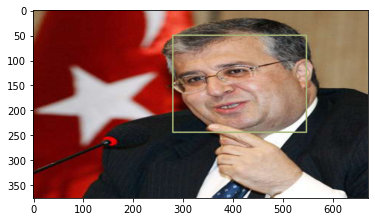

Done predictions with time 0.456 s
[[ 91.29375672  44.3232224  130.73284864 152.31571293]
 [239.44656765 104.52813339  72.7643373   93.38953733]
 [451.94564939  69.52171671 125.19642019 162.15468621]]
(3,)


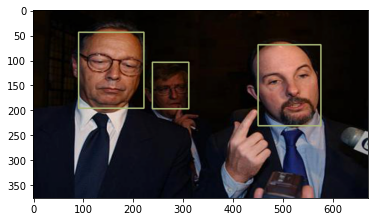

Done predictions with time 0.474 s
[[318.27131653  47.87022138 134.52171707 131.12448502]
 [  7.29973984  46.26297486  92.26142406 126.50495744]]
(2,)


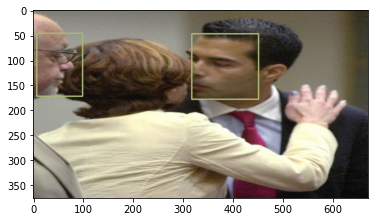

Done predictions with time 0.448 s
[[200.1269052   32.84859061 110.89123964  90.23486018]]
(1,)


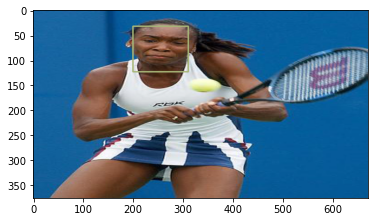

Done predictions with time 0.458 s
[[124.66990614  40.2954272  165.57717419 104.31477737]
 [  6.29018068   9.95293218  91.87747335  78.54089415]
 [378.1788801   -6.33354735  72.98586774  42.60219067]
 [124.66990614  40.2954272  165.57717419 104.31477737]]
(4,)


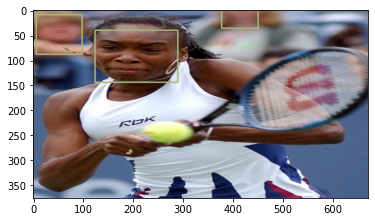

Done predictions with time 0.455 s
[[115.64007998  50.28272158 108.42390347  84.98571384]
 [421.77465677  14.96350694 129.38577175 102.14735365]]
(2,)


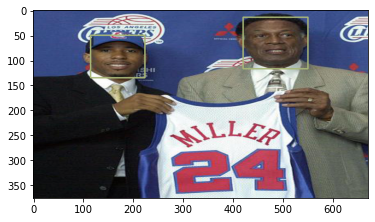

In [27]:
i=0


for valid_images, target_bbox, target_class, filename in dataset:
    
    start = time.time()
    m_outputs = detr(valid_images, training=False)
    predicted_bbox, predicted_labels, predicted_scores = get_model_inference(m_outputs, config.background_class, bbox_format="xy_center")
    now=(time.time()-start)
    print("Done predictions with time %.3f s"%now)

    boxes = boxes_output(valid_images[0], predicted_bbox, scores=predicted_scores)
        
    bboxes = xy_min_xy_max_to_xywh(boxes)#x_min, y_min, w, h
    print(bboxes)
    
    result = numpy_bbox_to_image(
        np.array(valid_images[0]),
        np.array(predicted_bbox),
        np.array(predicted_labels),
        scores=np.array(predicted_scores),
        class_name=['background', 'heads'], 
        config=config
    )
    plt.imshow(result)
    #plt.savefig("ex_%d.png"%i)
    plt.show()
    i+=1
    if i>5:
        break